
# FPV Time series forecasting

# Setup

In [ ]:

#from __future__ import print_function

# Drive mount

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!pip install darts
#!pip install git+https://github.com/keras-team/keras-tuner.git
#!pip install autokeras
!pip install pysolar
!pip install pvlib
!pip install keras-tuner 
!pip install EMD-signal  # for pyEmD
!pip install bayesian-optimization # for bayesian optimization

!nvidia-smi  # what gpu are in the system
!nvidia-smi -L
!pip install pyyaml h5py  # Required to save models in HDF5 format
#conda install git
!pip install git+https://github.com/tensorflow/docs
!pip install rpy2
!pip install vmdpy
!pip install antropy ## sample entropy calculation
!pip install ipynb
!pip install import-ipynb
!pip install permetrics #https://pypi.org/project/permetrics/
#!pip install attention
!pip install impyute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 3.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.0 MB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 19.5 MB/s 
     |████████████████████████████████| 1.6 MB 56.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 3.4 MB/s 
     |████████████████████████████████| 79 kB 9.5 MB/s 
     |████████████████████████████████| 52 kB 1.7 MB/s 
     |████████████████████████████████| 115 kB 91.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Sun Nov 27 10:31:25 2022       
+----------------

Saving and loading models

In [ ]:
#https://stackoverflow.com/questions/20186344/ipynb-import-another-ipynb-file

#py_file_location = "/content/drive/MyDrive/Colab Notebooks"
#sys.path.append(os.path.abspath(py_file_location))
#import DM_test.ipynb

#from ipynb.fs.full.DM_test import *
#import import_ipynb
#import DM_test

# predefine import all

In [4]:
#

#print(tf.__version__)

import os
import datetime
import sys
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns
import gdown
import pathlib
import shutil
import tempfile
import io

from impyute.imputation.cs import fast_knn
from google.colab import files


import sklearn.metrics as skm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler,PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression, mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_regression
from numpy import nan, isnan,split, array
from pandas import read_csv, to_numeric,DataFrame
import math
from math import sqrt
from matplotlib import pyplot, gridspec
import time
import timeit
from vmdpy import VMD  
import statsmodels.api as sm
from numpy import log
from statsmodels.tsa.stattools import adfuller
from rpy2.robjects import r, pandas2ri
import numpy as np
from rpy2.robjects.packages import importr
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import spearmanr, pearsonr
#from scipy.io import loadmat
import scipy.io as sio
#import scipy.io
import antropy as ant

from keras.models import Sequential
from tensorflow.keras.layers import PReLU, LeakyReLU
from keras.layers import Dense, Activation, Flatten, LSTM, GRU, Dropout,InputLayer, SimpleRNN
from keras.layers import BatchNormalization, RepeatVector, TimeDistributed
from keras import optimizers, regularizers, initializers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop # - Works
#from keras.optimizers import Adam  # does not work :https://stackoverflow.com/questions/62707558/importerror-cannot-import-name-adam-from-keras-optimizers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
#from attention import Attention


import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from pickle import dump,load
import pvlib
from numpy.random import randn
from numpy.random import seed 
import pickle
import tables

#from datetime import datetime
#from tensorflow.keras import layers
# tensorflow.keras import regularizers
# multivariate multi-step encoder-decoder lstm

from PyEMD import CEEMDAN, EMD, Visualisation

import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

## for bayes opt
from bayes_opt import BayesianOptimization
from scipy.stats import zscore
import keras.initializers
import statistics

from keras.callbacks import EarlyStopping
from bayes_opt import UtilityFunction
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf

# Supress NaN warnings
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
warnings.simplefilter("ignore", UserWarning)
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
device_name = tf.test.gpu_device_name()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [ ]:
!python --version

Python 3.7.15


In [ ]:
print(tf.__version__)
#print(python.__version__)

2.9.2


# Defining all function section

In [5]:
def group_data(df, minute):
  df.Time = pd.to_datetime(df.Time)
  #freq=minute
  #make the time the index. 
  df = df.set_index("Time")
  #'5Min'
  # group in 5-minute chunks. 
  t = df.groupby(pd.Grouper(freq=minute, closed='left',label='left')).agg({"Humidity": "mean", 
                                              "ambient Temperature_C": "mean", 
                                              "Solar Irradiance (tilted)W/m2": "mean", 
                                              "Wind speed m/s": "mean",
                                              "Wind direction degrees":"mean",
                                              "Total inverter power KW":"mean"})
  #Humidity	ambient Temperature_C	Solar Irradiance (horizontal)W/m2	Solar Irradiance (tilted)W/m2	Wind speed m/s	Wind direction degrees	total_inverter_power KW
  t.columns = ["Humidity",	"ambient Temperature_C",	
              "Solar Irradiance (tilted)W/m2",	"Wind speed m/s",
              "Wind direction degrees",	"total_inverter_power KW"]
  
  df=t


  

  date_time = df.index
  ## wind speed and direction as wind vector
  '''

  '''
  return df, date_time

def normalize(df):

  ## data normalization
  scaler = MinMaxScaler(feature_range=(0, 1))

  #scaler = MinMaxScaler()
  scaler = scaler.fit(df)
  print(scaler.data_max_)
  df = scaler.transform(df)
  dff=scaler.inverse_transform(df)
  '''
  # Creating a separate scaler that works on a single column for scaling predictions
  scaler_pred = MinMaxScaler(feature_range=(0, 1))
  df_total_power = pd.DataFrame(df['total_inverter_power KW'])
  df_total_power_scaled = scaler_pred.fit_transform(df_total_power)
  '''
  return df, scaler, dff


# split dataset into train/test sets
def split_dataset(df,minute):
  #n = len(data)
  #train = array(data[0:int(n*0.8)])
  #val = array(data[int(n*0.8):int(n*0.9)])
  #test = array(data[int(n*0.9):])
  #return train, val, test
  ### train test split
  #n = len(df)
  n=df.shape[0]
  total_days=int(df.shape[0]/((60/minute)*24))   ## 151 days
  total_mins=int(df.shape[0]/(60/minute))
  train_split_percent=0.8       # 0.7 previously
  val_split_percent=0.9 #previous 0.91
  train = df[0:int(total_days*(train_split_percent)*(24*(60/minute)))]   ## days 120 days/151
  val = df[int(total_days*(train_split_percent)*(24*(60/minute))):int(total_days*(val_split_percent)*(24*(60/minute)))]  ## 120 to 135 days
  test = df[int(total_days*(val_split_percent)*(24*(60/minute))):]  ## 135 to 151 days

  train_dates=date_time[0:int(total_days*(train_split_percent)*(24*(60/minute)))]
  val_dates=date_time[int(total_days*(train_split_percent)*(24*(60/minute))):int(total_days*(val_split_percent)*(24*(60/minute)))]
  test_dates = date_time[int(total_days*(val_split_percent)*(24*(60/minute))):]

  '''
  ## TIME as a feature
  timestamp_s = date_time.map(pd.Timestamp.timestamp)
  train_timestamp_s=timestamp_s[0:(int(total_days*(141/151)))*(24*60)]
  val_timestamp_s=timestamp_s[(int(total_days*(141/151)))*(24*60):(int(total_days*(146/151)))*(24*60)]
  test_timestamp_s = timestamp_s[(int(total_days*(146/151)))*(24*60):]
  #train_df = df[0:int(n*0.8)]
  #val_df = df[int(n*0.8):int(n*0.9)]
  #test_df = df[int(n*0.9):]
  '''
  # wind speed direction and horz and time eliminated from data frame 
  #as it starts from 0, 1, 2, 3 =3 no is the target total power inverter for multivariate and 0 for univariate
  return train, val, test, train_dates, val_dates, test_dates

def sliding_window(data, sw_width, n_out, in_start, increment,target_num):
    '''
         This function implements a sliding window with a window width of 240 and a sliding step of 1 to intercept sequence data
    '''

    X, y = [], []

        
    for _ in range(len(data)):
            in_end = in_start + sw_width
            out_end = in_end + n_out
            
            if out_end < len(data):
                # The training data is intercepted with a sliding step of 1
                X.append(data[in_start:in_end, :])
                y.append(data[in_end:out_end, target_num])
            
            in_start += increment   ## not sure if it is 1
            
    np.array(X), np.array(y) 
    return np.array(X), np.array(y)

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Attention layer

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [ ]:
### not worked
'''
import tensorflow as tf

class Attention(tf.keras.layers.Layer):

    def __init__(self, return_sequences=True, name=None, **kwargs):
        super(Attention, self).__init__(name=name)
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
    
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                           initializer="glorot_uniform", trainable=True)
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                           initializer="glorot_uniform", trainable=True)
    
        super(Attention, self).build(input_shape)

    def call(self, x):
    
        e = tf.keras.activations.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.activations.softmax(e, axis=1)
        output = x * a
    
        if self.return_sequences:
            return a, output
    
        return a, tf.keras.backend.sum(output, axis=1)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'return_sequences': self.return_sequences 
        })
        return config
'''

'\nimport tensorflow as tf\n\nclass Attention(tf.keras.layers.Layer):\n\n    def __init__(self, return_sequences=True, name=None, **kwargs):\n        super(Attention, self).__init__(name=name)\n        self.return_sequences = return_sequences\n        super(Attention, self).__init__(**kwargs)\n\n    def build(self, input_shape):\n    \n        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),\n                           initializer="glorot_uniform", trainable=True)\n        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),\n                           initializer="glorot_uniform", trainable=True)\n    \n        super(Attention, self).build(input_shape)\n\n    def call(self, x):\n    \n        e = tf.keras.activations.tanh(tf.keras.backend.dot(x, self.W) + self.b)\n        a = tf.keras.activations.softmax(e, axis=1)\n        output = x * a\n    \n        if self.return_sequences:\n            return a, output\n    \n        return a, tf.keras.backend.su

# Improved in loss for 48hours

In [ ]:
#!pip install attention

In [ ]:
#from attention import Attention

def get_optimizer(train,val):
  N_VALIDATION = val.shape[0]
  N_TRAIN = train.shape[0]
  BUFFER_SIZE = int(1e4)
  BATCH_SIZE = 32
  STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*50000,
    decay_rate=0.9,
    staircase=False)
  lr_schedule2 = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 10))
  
  #tf.keras.optimizers.Adam(lr_schedule), STEPS_PER_EPOCH 
  #f.keras.optimizers.Adam(lr=0.001), STEPS_PER_EPOCH 
  return tf.keras.optimizers.Adam(lr=2e-3), STEPS_PER_EPOCH,BATCH_SIZE, lr_schedule2

def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=75),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

#LeakyReLU()
#PReLU(alpha_initializer='zero')
#                   activation='relu',
def compile_and_fit_LSTM(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):
    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2]) 
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])
    

    #https://stackoverflow.com/questions/58966874/adding-attention-on-top-of-simple-lstm-layer-in-tensorflow-2-0
    #https://stackoverflow.com/questions/59811773/how-to-use-keras-attention-layer-on-top-of-lstm-gru
    
    '''
            model = tf.keras.models.Sequential()
        model.add(layers.LSTM(cfg.LSTM, input_shape=(cfg.SEQUENCES,
                  train_X.shape[2]),
                  return_sequences=True))
        model.add(Attention(name='attention_weight'))
        model.add(layers.Dense(train_Y.shape[2], activation='sigmoid'))
    '''


    #n_neurons = train_x.shape[1] * train_x.shape[2]
    #model = tf.keras.models.Sequential()

    model = Sequential()
    model.add(LSTM(64,   
                   kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features),
                   return_sequences=True)),
    
    model.add(Dropout(0.5)),

    # activation='relu',
    #model.add(attention(return_sequences=True))

    model.add(LSTM(64, 
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True)),
                 
    model.add(Dropout(0.4)),

    model.add(LSTM(32, 
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True)),
                 
    model.add(Dropout(0.4)),

    model.add(LSTM(32, 
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001))),
                 
    model.add(Dropout(0.2)),

    model.add(Dense(32, activation='relu')),
    #model.add(Dense(32, activation='relu')),
    #model.add(Attention(name='attention_weight', return_sequences=False))
    #model.add(Attention()),
    model.add(Dense(n_outputs,activation='linear'))
    #model.add(Dense(train_y.shape[1], activation='linear', kernel_constraint=tf.keras.constraints.NonNeg()))




    if optimizer is None:
      optimizer,STEPS_PER_EPOCH, BATCH_SIZE,lr_schedule2  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'multi_LSTM.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    path_checkpoint = "model_checkpoint_LSTM.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.Huber(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    #optimizer=keras.optimizers.Adam(0.001)
    #optimizer='relu'

    history = model.fit(
      train_x, train_y,
      batch_size= BATCH_SIZE,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback,lr_schedule2],
      verbose=1)
    return history, model


def compile_and_fit_GRU(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):


    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2]) 
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])

    #https://stackoverflow.com/questions/34717241/how-to-use-advanced-activation-layers-in-keras
    #https://www.machinecurve.com/index.php/2019/12/05/how-to-use-prelu-with-keras/

    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    #model = tf.keras.models.Sequential()
    model.add(GRU(64,   
                   kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features),
                   return_sequences=True)),
 
    model.add(Dropout(0.5)),

    # activation='relu',
    #model.add(attention(return_sequences=True))
    model.add(GRU(64, 
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True)),              
    model.add(Dropout(0.4)),
    model.add(GRU(32, 
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True)),              
    model.add(Dropout(0.4)),

    model.add(GRU(32, 
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001))),
                
    model.add(Dropout(0.2)),


    model.add(Dense(32, activation='relu')),
    #model.add(Dense(32, activation='relu')),
    #model.add(Attention(return_sequences=False)) 
    #model.add(Attention()),   
    model.add(Dense(train_y.shape[1], activation='linear'))

    if optimizer is None:
      optimizer,STEPS_PER_EPOCH, BATCH_SIZE,lr_schedule2  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'multi_GRU.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    
    path_checkpoint = "model_checkpoint_GRU.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    
    #callbacks=get_callbacks(name),
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.Huber(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      batch_size = BATCH_SIZE,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback,lr_schedule2],
      verbose=1)
    return history, model






def compile_and_fit_uni_LSTM(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):
    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])
    
    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    model.add(LSTM(64,
                   kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),
    model.add(Dropout(0.2)),

    #model.add(LSTM(64,kernel_initializer='normal', 
    #               kernel_regularizer=regularizers.l2(0.01))),
    #model.add(Dropout(0.1)),


    model.add(Dense(32, activation='relu')), 
    #model.add(Dense(32, activation='relu')),       
    model.add(Dense(train_y.shape[1], activation='linear', kernel_constraint=tf.keras.constraints.NonNeg()))
    if optimizer is None:
      optimizer,STEPS_PER_EPOCH, BATCH_SIZE,lr_schedule2  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'LSTM.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    path_checkpoint = "model_checkpoint_LSTM.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      batch_size = BATCH_SIZE,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback,lr_schedule2],
      verbose=1)
    return history, model


def compile_and_fit_uni_GRU(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):


    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2]) 
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])

    #https://stackoverflow.com/questions/34717241/how-to-use-advanced-activation-layers-in-keras
    #https://www.machinecurve.com/index.php/2019/12/05/how-to-use-prelu-with-keras/

    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    
    model.add(GRU(64,
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),
  
    model.add(Dropout(0.2)),

    #model.add(GRU(64,kernel_initializer='normal', 
    #               kernel_regularizer=regularizers.l2(0.01))),
    #model.add(Dropout(0.1)),


    model.add(Dense(32, activation='relu')), 
    #model.add(Dense(32, activation='relu')),     
    model.add(Dense(train_y.shape[1], activation='linear', kernel_constraint=tf.keras.constraints.NonNeg()))


    if optimizer is None:
      optimizer,STEPS_PER_EPOCH, BATCH_SIZE,lr_schedule2  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'GRU.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    
    path_checkpoint = "model_checkpoint_GRU.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    
    #callbacks=get_callbacks(name),
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      batch_size = BATCH_SIZE,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback,lr_schedule2],
      verbose=1)
    return history, model

'''
    model.add(GRU(400,kernel_initializer='normal', 
                  kernel_regularizer=regularizers.l2(0.001),
                  input_shape=(n_timesteps, n_features))),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.2)),

    model.add(RepeatVector(n_outputs)),

    model.add(GRU(400,kernel_initializer='normal',
                  kernel_regularizer=regularizers.l2(0.001),  
                  return_sequences=True)),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.3)),   
 

    model.add(TimeDistributed(Dense(100, activation='relu'))),
    model.add(TimeDistributed(Dense(1)))

    model.add(LSTM(128,  
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True)),
    model.add(Dropout(0.3)),


    model.add(Dense(64, activation='relu')), 
    model.add(Dense(64, activation=LeakyReLU())),     
    model.add(Dense(train_y.shape[1], activation='linear'))


        history = model.fit(
      train_x, train_y,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
'''


"\n    model.add(GRU(400,kernel_initializer='normal', \n                  kernel_regularizer=regularizers.l2(0.001),\n                  input_shape=(n_timesteps, n_features))),\n    model.add(PReLU(alpha_initializer='zero')),\n    model.add(Dropout(0.2)),\n\n    model.add(RepeatVector(n_outputs)),\n\n    model.add(GRU(400,kernel_initializer='normal',\n                  kernel_regularizer=regularizers.l2(0.001),  \n                  return_sequences=True)),\n    model.add(PReLU(alpha_initializer='zero')),\n    model.add(Dropout(0.3)),   \n \n\n    model.add(TimeDistributed(Dense(100, activation='relu'))),\n    model.add(TimeDistributed(Dense(1)))\n\n    model.add(LSTM(128,  \n                   kernel_initializer='normal',\n                   kernel_regularizer=regularizers.l2(0.001),\n                   return_sequences=True)),\n    model.add(Dropout(0.3)),\n\n\n    model.add(Dense(64, activation='relu')), \n    model.add(Dense(64, activation=LeakyReLU())),     \n    model.add(Dense(tr

## Time distributed layer --Worked Nov 26,2022

In [30]:

#https://www.tensorflow.org/api_docs/python/tf/compat/v1/reset_default_graph

#tf.compat.v1.reset_default_graph()
def get_optimizer(train,val):
  N_VALIDATION = val.shape[0]
  N_TRAIN = train.shape[0]
  BUFFER_SIZE = int(1e4)
  BATCH_SIZE = 50
  STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*5,
    decay_rate=0.9,
    staircase=False)
  #tf.keras.optimizers.Adam(lr_schedule,clipvalue=1), STEPS_PER_EPOCH 
  return tf.keras.optimizers.Adam(lr_schedule), STEPS_PER_EPOCH 

def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]


def compile_and_fit_LSTM(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):
    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2]) 
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])
    
    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    model.add(LSTM(400,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),   
    model.add(Dropout(0.1)),

    model.add(RepeatVector(n_outputs)),

    model.add(LSTM(400,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),                     
                   return_sequences=True)),
    model.add(Dropout(0.1)),


    model.add(TimeDistributed(Dense(32, 
                                    activation='linear',
                                    bias_regularizer=regularizers.l2(1e-4),
                                    activity_regularizer=regularizers.l2(1e-5)))),
    model.add(TimeDistributed(Dense(16, 
                                    activation='linear',
                                    bias_regularizer=regularizers.l2(1e-4),
                                    activity_regularizer=regularizers.l2(1e-5)))),
    
    model.add(TimeDistributed(Dense(1, activation='linear')))

    if optimizer is None:
      optimizer,STEPS_PER_EPOCH  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'LSTM.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    path_checkpoint = "model_checkpoint_LSTM.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


def compile_and_fit_GRU(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):


    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2]) 
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])

    #https://stackoverflow.com/questions/34717241/how-to-use-advanced-activation-layers-in-keras
    #https://www.machinecurve.com/index.php/2019/12/05/how-to-use-prelu-with-keras/

    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    #act = keras.layers.advanced_activations.PReLU(init='zero', weights=None)
    model.add(GRU(400,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),   
    model.add(Dropout(0.1)),

    model.add(RepeatVector(n_outputs)),

    model.add(GRU(400,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),                   
                   return_sequences=True)),
    model.add(Dropout(0.1)),


    model.add(TimeDistributed(Dense(32, 
                                    activation='linear',
                                    bias_regularizer=regularizers.l2(1e-4),
                                    activity_regularizer=regularizers.l2(1e-5)))),
    model.add(TimeDistributed(Dense(16, 
                                    activation='linear',
                                    bias_regularizer=regularizers.l2(1e-4),
                                    activity_regularizer=regularizers.l2(1e-5)))),
    
    model.add(TimeDistributed(Dense(1, activation='linear')))
    if optimizer is None:
      optimizer,STEPS_PER_EPOCH  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'GRU.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    
    path_checkpoint = "model_checkpoint_GRU.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    
    #callbacks=get_callbacks(name),
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model






def compile_and_fit_uni_LSTM(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):
    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])
    
    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    model.add(LSTM(256,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),   
    model.add(Dropout(0.1)),

    model.add(RepeatVector(n_outputs)),

    model.add(TimeDistributed(Dense(32, 
                                    activation='linear',
                                    bias_regularizer=regularizers.l2(1e-4),
                                    activity_regularizer=regularizers.l2(1e-5)))),
    model.add(TimeDistributed(Dense(16, 
                                    activation='linear',
                                    bias_regularizer=regularizers.l2(1e-4),
                                    activity_regularizer=regularizers.l2(1e-5)))),
    
    model.add(TimeDistributed(Dense(1, activation='linear')))

    if optimizer is None:
      optimizer,STEPS_PER_EPOCH  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'LSTM.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    path_checkpoint = "model_checkpoint_LSTM.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


def compile_and_fit_uni_GRU(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):


    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2]) 
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])

    #https://stackoverflow.com/questions/34717241/how-to-use-advanced-activation-layers-in-keras
    #https://www.machinecurve.com/index.php/2019/12/05/how-to-use-prelu-with-keras/

    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    #act = keras.layers.advanced_activations.PReLU(init='zero', weights=None)
    model.add(GRU(128,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),   
    model.add(Dropout(0.1)),

    model.add(RepeatVector(n_outputs)),

    model.add(TimeDistributed(Dense(32, 
                                    activation='linear',
                                    bias_regularizer=regularizers.l2(1e-4),
                                    activity_regularizer=regularizers.l2(1e-5)))),
    model.add(TimeDistributed(Dense(16, 
                                    activation='linear',
                                    bias_regularizer=regularizers.l2(1e-4),
                                    activity_regularizer=regularizers.l2(1e-5)))),
    
    model.add(TimeDistributed(Dense(1, activation='linear')))
    if optimizer is None:
      optimizer,STEPS_PER_EPOCH  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'GRU.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    
    path_checkpoint = "model_checkpoint_GRU.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    
    #callbacks=get_callbacks(name),
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


'''
multivar
    model.add(LSTM(300,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),  
                   return_sequences=True)),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.4)),

for the univariate
    model.add(LSTM(300,kernel_initializer='normal',
                  kernel_regularizer=regularizers.l2(0.001),  
                  return_sequences=True)),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.3)), 

    gru 

    model.add(GRU(300,kernel_initializer='normal',
                  kernel_regularizer=regularizers.l2(0.001),  
                  return_sequences=True)),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.3)), 
'''

"\nmultivar\n    model.add(LSTM(300,kernel_initializer='normal', \n                   kernel_regularizer=regularizers.l2(0.001),  \n                   return_sequences=True)),\n    model.add(PReLU(alpha_initializer='zero')),\n    model.add(Dropout(0.4)),\n\nfor the univariate\n    model.add(LSTM(300,kernel_initializer='normal',\n                  kernel_regularizer=regularizers.l2(0.001),  \n                  return_sequences=True)),\n    model.add(PReLU(alpha_initializer='zero')),\n    model.add(Dropout(0.3)), \n\n    gru \n\n    model.add(GRU(300,kernel_initializer='normal',\n                  kernel_regularizer=regularizers.l2(0.001),  \n                  return_sequences=True)),\n    model.add(PReLU(alpha_initializer='zero')),\n    model.add(Dropout(0.3)), \n"

### worked on nov 26, 2022 before night 8PM

In [ ]:
def get_optimizer(train,val):
  N_VALIDATION = val.shape[0]
  N_TRAIN = train.shape[0]
  BUFFER_SIZE = int(1e4)
  BATCH_SIZE = 64
  STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH,
    decay_rate=0.9,
    staircase=False)
  #tf.keras.optimizers.Adam(lr=1e-3), STEPS_PER_EPOCH, BATCH_SIZE
  return tf.keras.optimizers.Adam(lr_schedule), STEPS_PER_EPOCH, BATCH_SIZE 

def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]


def compile_and_fit_LSTM(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):
    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2]) 
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])
    
    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    model.add(LSTM(256,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),

    model.add(Dropout(0.2)),

    model.add(RepeatVector(n_outputs)),


    model.add(LSTM(128,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True)),

    model.add(Dropout(0.1)),


    model.add(TimeDistributed(Dense(32, activation='linear'))),
    #model.add(TimeDistributed(Dense(32, activation='relu'))),    
    model.add(TimeDistributed(Dense(1, activation='linear')))
    
    
    if optimizer is None:
      optimizer,STEPS_PER_EPOCH, BATCH_SIZE   = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'LSTM.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    path_checkpoint = "model_checkpoint_LSTM.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    #steps_per_epoch = STEPS_PER_EPOCH,
    #batch_size= BATCH_SIZE,

    history = model.fit(
      train_x, train_y,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


def compile_and_fit_GRU(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):


    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2]) 
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])

    #https://stackoverflow.com/questions/34717241/how-to-use-advanced-activation-layers-in-keras
    #https://www.machinecurve.com/index.php/2019/12/05/how-to-use-prelu-with-keras/

    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    #act = keras.layers.advanced_activations.PReLU(init='zero', weights=None)
    model.add(GRU(256,kernel_initializer='normal', 
                  kernel_regularizer=regularizers.l2(0.001),
                  input_shape=(n_timesteps, n_features))),

    model.add(Dropout(0.2)),

    model.add(RepeatVector(n_outputs)),   
 
    model.add(GRU(128,kernel_initializer='normal',
                  kernel_regularizer=regularizers.l2(0.001),
                  return_sequences=True)),

    model.add(Dropout(0.1)),   
 
    model.add(TimeDistributed(Dense(32, activation='linear'))),
    #model.add(TimeDistributed(Dense(32, activation='relu'))),    
    model.add(TimeDistributed(Dense(1, activation='linear')))
    if optimizer is None:
      optimizer,STEPS_PER_EPOCH, BATCH_SIZE   = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'GRU.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    
    path_checkpoint = "model_checkpoint_GRU.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    
    #callbacks=get_callbacks(name),
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    #steps_per_epoch = STEPS_PER_EPOCH,
    #batch_size= BATCH_SIZE,


    history = model.fit(
      train_x, train_y,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model






def compile_and_fit_uni_LSTM(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):
    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])
    
    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    model.add(LSTM(64,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),

    model.add(Dropout(0.2)),

    model.add(RepeatVector(n_outputs)),

    model.add(LSTM(32,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True)),

    model.add(Dropout(0.1)),


    #model.add(TimeDistributed(Dense(64, activation='relu'))),
    model.add(TimeDistributed(Dense(32, activation='linear'))),    
    model.add(TimeDistributed(Dense(1, activation='linear')))
    if optimizer is None:
      optimizer,STEPS_PER_EPOCH, BATCH_SIZE   = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'LSTM.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    path_checkpoint = "model_checkpoint_LSTM.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


def compile_and_fit_uni_GRU(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):


    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2]) 
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])

    #https://stackoverflow.com/questions/34717241/how-to-use-advanced-activation-layers-in-keras
    #https://www.machinecurve.com/index.php/2019/12/05/how-to-use-prelu-with-keras/

    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    model.add(GRU(64,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),

    model.add(Dropout(0.2)),

    model.add(RepeatVector(n_outputs)),

    model.add(GRU(32,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True)),

    model.add(Dropout(0.1)),


    #model.add(TimeDistributed(Dense(64, activation='relu'))),
    model.add(TimeDistributed(Dense(32, activation='linear'))),    
    model.add(TimeDistributed(Dense(1, activation='linear')))
    if optimizer is None:
      optimizer,STEPS_PER_EPOCH, BATCH_SIZE   = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'GRU.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    
    path_checkpoint = "model_checkpoint_GRU.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    
    #callbacks=get_callbacks(name),
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


'''
multivar
    model.add(LSTM(300,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),  
                   return_sequences=True)),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.4)),

for the univariate
    model.add(LSTM(300,kernel_initializer='normal',
                  kernel_regularizer=regularizers.l2(0.001),  
                  return_sequences=True)),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.3)), 

    gru 

    model.add(GRU(300,kernel_initializer='normal',
                  kernel_regularizer=regularizers.l2(0.001),  
                  return_sequences=True)),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.3)), 
'''

### worked before v99

In [ ]:

#https://www.tensorflow.org/api_docs/python/tf/compat/v1/reset_default_graph

#tf.compat.v1.reset_default_graph()
def get_optimizer(train,val):
  N_VALIDATION = val.shape[0]
  N_TRAIN = train.shape[0]
  BUFFER_SIZE = int(1e4)
  BATCH_SIZE = 128
  STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*5,
    decay_rate=0.5,
    staircase=False)
  return tf.keras.optimizers.Adam(lr_schedule,clipvalue=1), STEPS_PER_EPOCH 

def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]


def compile_and_fit_LSTM(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):
    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2]) 
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])
    
    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    model.add(LSTM(128,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   bias_regularizer=regularizers.l2(1e-4),
                   activity_regularizer=regularizers.l2(1e-5),
                   input_shape=(n_timesteps, n_features))),   
    model.add(Dropout(0.2)),

    model.add(RepeatVector(n_outputs)),

    model.add(LSTM(64,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),  
                   bias_regularizer=regularizers.l2(1e-4),
                   activity_regularizer=regularizers.l2(1e-5),                   
                   return_sequences=True)),
    model.add(Dropout(0.3)),


    model.add(TimeDistributed(Dense(16, 
                                    activation=LeakyReLU(),
                                    bias_regularizer=regularizers.l2(1e-4),
                                    activity_regularizer=regularizers.l2(1e-5),                                    ))),
    model.add(TimeDistributed(Dense(4, 
                                    activation=LeakyReLU(),
                                    bias_regularizer=regularizers.l2(1e-4),
                                    activity_regularizer=regularizers.l2(1e-5),                                    ))),
    
    model.add(TimeDistributed(Dense(1, activation='linear')))

    if optimizer is None:
      optimizer,STEPS_PER_EPOCH  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'LSTM.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    path_checkpoint = "model_checkpoint_LSTM.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


def compile_and_fit_GRU(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):


    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2]) 
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])

    #https://stackoverflow.com/questions/34717241/how-to-use-advanced-activation-layers-in-keras
    #https://www.machinecurve.com/index.php/2019/12/05/how-to-use-prelu-with-keras/

    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    #act = keras.layers.advanced_activations.PReLU(init='zero', weights=None)
    model.add(GRU(128,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   bias_regularizer=regularizers.l2(1e-4),
                   activity_regularizer=regularizers.l2(1e-5),
                   input_shape=(n_timesteps, n_features))),   
    model.add(Dropout(0.2)),

    model.add(RepeatVector(n_outputs)),

    model.add(GRU(64,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),  
                   bias_regularizer=regularizers.l2(1e-4),
                   activity_regularizer=regularizers.l2(1e-5),                   
                   return_sequences=True)),
    model.add(Dropout(0.3)),


    model.add(TimeDistributed(Dense(16, 
                                    activation=LeakyReLU(),
                                    bias_regularizer=regularizers.l2(1e-4),
                                    activity_regularizer=regularizers.l2(1e-5),                                    ))),
    model.add(TimeDistributed(Dense(4, 
                                    activation=LeakyReLU(),
                                    bias_regularizer=regularizers.l2(1e-4),
                                    activity_regularizer=regularizers.l2(1e-5),                                    ))),
    
    model.add(TimeDistributed(Dense(1, activation='linear')))
    if optimizer is None:
      optimizer,STEPS_PER_EPOCH  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'GRU.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    
    path_checkpoint = "model_checkpoint_GRU.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    
    #callbacks=get_callbacks(name),
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model






def compile_and_fit_uni_LSTM(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):
    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])
    
    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    model.add(LSTM(64,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   bias_regularizer=regularizers.l2(1e-4),
                   activity_regularizer=regularizers.l2(1e-5),
                   input_shape=(n_timesteps, n_features))),   
    model.add(Dropout(0.2)),

    model.add(RepeatVector(n_outputs)),

    model.add(TimeDistributed(Dense(16, 
                                    activation=LeakyReLU(),
                                    bias_regularizer=regularizers.l2(1e-4),
                                    activity_regularizer=regularizers.l2(1e-5),                                    ))),
    model.add(TimeDistributed(Dense(4, 
                                    activation=LeakyReLU(),
                                    bias_regularizer=regularizers.l2(1e-4),
                                    activity_regularizer=regularizers.l2(1e-5),                                    ))),
    
    model.add(TimeDistributed(Dense(1, activation='linear')))

    if optimizer is None:
      optimizer,STEPS_PER_EPOCH  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'LSTM.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    path_checkpoint = "model_checkpoint_LSTM.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


def compile_and_fit_uni_GRU(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):


    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2]) 
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])

    #https://stackoverflow.com/questions/34717241/how-to-use-advanced-activation-layers-in-keras
    #https://www.machinecurve.com/index.php/2019/12/05/how-to-use-prelu-with-keras/

    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    #act = keras.layers.advanced_activations.PReLU(init='zero', weights=None)
    model.add(GRU(64,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   bias_regularizer=regularizers.l2(1e-4),
                   activity_regularizer=regularizers.l2(1e-5),
                   input_shape=(n_timesteps, n_features))),   
    model.add(Dropout(0.2)),

    model.add(RepeatVector(n_outputs)),

    model.add(TimeDistributed(Dense(16, 
                                    activation=LeakyReLU(),
                                    bias_regularizer=regularizers.l2(1e-4),
                                    activity_regularizer=regularizers.l2(1e-5),                                    ))),
    model.add(TimeDistributed(Dense(4, 
                                    activation=LeakyReLU(),
                                    bias_regularizer=regularizers.l2(1e-4),
                                    activity_regularizer=regularizers.l2(1e-5),                                    ))),
    
    model.add(TimeDistributed(Dense(1, activation='linear')))
    if optimizer is None:
      optimizer,STEPS_PER_EPOCH  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'GRU.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    
    path_checkpoint = "model_checkpoint_GRU.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    
    #callbacks=get_callbacks(name),
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


'''
multivar
    model.add(LSTM(300,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),  
                   return_sequences=True)),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.4)),

for the univariate
    model.add(LSTM(300,kernel_initializer='normal',
                  kernel_regularizer=regularizers.l2(0.001),  
                  return_sequences=True)),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.3)), 

    gru 

    model.add(GRU(300,kernel_initializer='normal',
                  kernel_regularizer=regularizers.l2(0.001),  
                  return_sequences=True)),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.3)), 
'''

In [ ]:
## nov 26 2022
def get_optimizer(train,val):
  N_VALIDATION = val.shape[0]
  N_TRAIN = train.shape[0]
  BUFFER_SIZE = int(1e4)
  BATCH_SIZE = 32
  STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH,
    decay_rate=0.9,
    staircase=False)
  return tf.keras.optimizers.Adam(lr=1e-3), STEPS_PER_EPOCH, BATCH_SIZE 

def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]


def compile_and_fit_LSTM(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):
    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2]) 
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])
    
    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    model.add(LSTM(64,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),

    model.add(Dropout(0.2)),

    model.add(RepeatVector(n_outputs)),

    model.add(LSTM(32,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True)),

    model.add(Dropout(0.1)),

    model.add(LSTM(32,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True)),

    model.add(Dropout(0.3)),


    model.add(TimeDistributed(Dense(64, activation='relu'))),
    #model.add(TimeDistributed(Dense(32, activation='relu'))),    
    model.add(TimeDistributed(Dense(1, activation='linear')))
    
    
    if optimizer is None:
      optimizer,STEPS_PER_EPOCH, BATCH_SIZE   = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'LSTM.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    path_checkpoint = "model_checkpoint_LSTM.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      batch_size= BATCH_SIZE,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


def compile_and_fit_GRU(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):


    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2]) 
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])

    #https://stackoverflow.com/questions/34717241/how-to-use-advanced-activation-layers-in-keras
    #https://www.machinecurve.com/index.php/2019/12/05/how-to-use-prelu-with-keras/

    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    #act = keras.layers.advanced_activations.PReLU(init='zero', weights=None)
    model.add(GRU(64,kernel_initializer='normal', 
                  kernel_regularizer=regularizers.l2(0.001),
                  input_shape=(n_timesteps, n_features))),

    model.add(Dropout(0.2)),

    model.add(RepeatVector(n_outputs)),

    model.add(GRU(32,kernel_initializer='normal',
                  kernel_regularizer=regularizers.l2(0.001),
                  return_sequences=True)),

    model.add(Dropout(0.1)),   
 
    model.add(GRU(32,kernel_initializer='normal',
                  kernel_regularizer=regularizers.l2(0.001),
                  return_sequences=True)),

    model.add(Dropout(0.3)),   
 
    model.add(TimeDistributed(Dense(64, activation='relu'))),
    #model.add(TimeDistributed(Dense(32, activation='relu'))),    
    model.add(TimeDistributed(Dense(1, activation='linear')))
    if optimizer is None:
      optimizer,STEPS_PER_EPOCH, BATCH_SIZE   = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'GRU.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    
    path_checkpoint = "model_checkpoint_GRU.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    
    #callbacks=get_callbacks(name),
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      batch_size= BATCH_SIZE,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model






def compile_and_fit_uni_LSTM(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):
    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])
    
    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    model.add(LSTM(64,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),

    model.add(Dropout(0.2)),

    model.add(RepeatVector(n_outputs)),

    model.add(LSTM(32,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True)),

    model.add(Dropout(0.1)),


    #model.add(TimeDistributed(Dense(64, activation='relu'))),
    model.add(TimeDistributed(Dense(32, activation='relu'))),    
    model.add(TimeDistributed(Dense(1, activation='linear')))
    if optimizer is None:
      optimizer,STEPS_PER_EPOCH, BATCH_SIZE   = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'LSTM.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    path_checkpoint = "model_checkpoint_LSTM.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      batch_size= BATCH_SIZE,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


def compile_and_fit_uni_GRU(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):


    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2]) 
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])

    #https://stackoverflow.com/questions/34717241/how-to-use-advanced-activation-layers-in-keras
    #https://www.machinecurve.com/index.php/2019/12/05/how-to-use-prelu-with-keras/

    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    model.add(GRU(64,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),

    model.add(Dropout(0.2)),

    model.add(RepeatVector(n_outputs)),

    model.add(GRU(32,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True)),

    model.add(Dropout(0.1)),


    #model.add(TimeDistributed(Dense(64, activation='relu'))),
    model.add(TimeDistributed(Dense(32, activation='relu'))),    
    model.add(TimeDistributed(Dense(1, activation='linear')))
    if optimizer is None:
      optimizer,STEPS_PER_EPOCH, BATCH_SIZE   = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'GRU.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    
    path_checkpoint = "model_checkpoint_GRU.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    
    #callbacks=get_callbacks(name),
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      batch_size= BATCH_SIZE,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


'''
multivar
    model.add(LSTM(300,kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),  
                   return_sequences=True)),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.4)),

for the univariate
    model.add(LSTM(300,kernel_initializer='normal',
                  kernel_regularizer=regularizers.l2(0.001),  
                  return_sequences=True)),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.3)), 

    gru 

    model.add(GRU(300,kernel_initializer='normal',
                  kernel_regularizer=regularizers.l2(0.001),  
                  return_sequences=True)),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.3)), 
'''

## test

In [ ]:
#from attention import Attention
'''
def get_optimizer(train,val):
  N_VALIDATION = val.shape[0]
  N_TRAIN = train.shape[0]
  BUFFER_SIZE = int(1e4)
  BATCH_SIZE = 64
  STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*50000,
    decay_rate=0.9,
    staircase=False)
  #tf.keras.optimizers.Adam(lr_schedule), STEPS_PER_EPOCH 
  #f.keras.optimizers.Adam(lr=0.001), STEPS_PER_EPOCH 
  return tf.keras.optimizers.Adam(lr=0.001), STEPS_PER_EPOCH 

def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

#LeakyReLU()
#PReLU(alpha_initializer='zero')
#                   activation='relu',
def compile_and_fit_LSTM(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):
    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2]) 
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])
    

    #https://stackoverflow.com/questions/58966874/adding-attention-on-top-of-simple-lstm-layer-in-tensorflow-2-0
    #https://stackoverflow.com/questions/59811773/how-to-use-keras-attention-layer-on-top-of-lstm-gru
    
    '''
    '''
            model = tf.keras.models.Sequential()
        model.add(layers.LSTM(cfg.LSTM, input_shape=(cfg.SEQUENCES,
                  train_X.shape[2]),
                  return_sequences=True))
        model.add(Attention(name='attention_weight'))
        model.add(layers.Dense(train_Y.shape[2], activation='sigmoid'))
    '''
    '''


    #n_neurons = train_x.shape[1] * train_x.shape[2]
    #model = tf.keras.models.Sequential()

    model = Sequential()
    model.add(LSTM(32,   
                   kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features),
                   return_sequences=True)),
    model.add(Dropout(0.5)),



    # activation='relu',
    #model.add(attention(return_sequences=True))


    model.add(LSTM(32,  
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True)),
    model.add(Dropout(0.4)),

    model.add(LSTM(16,  
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001))),
    model.add(Dropout(0.4)),


    model.add(Dense(16, activation='relu')),
    model.add(Dense(16, activation='relu')),
    #model.add(Attention(name='attention_weight', return_sequences=False))
    #model.add(Attention()),
    model.add(Dense(n_outputs,activation='linear'))


    if optimizer is None:
      optimizer,STEPS_PER_EPOCH  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'multi_LSTM.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    path_checkpoint = "model_checkpoint_LSTM.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    #optimizer=keras.optimizers.Adam(0.001)
    #optimizer='relu'

    history = model.fit(
      train_x, train_y,
      batch_size= 64,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


def compile_and_fit_GRU(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):


    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2]) 
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])

    #https://stackoverflow.com/questions/34717241/how-to-use-advanced-activation-layers-in-keras
    #https://www.machinecurve.com/index.php/2019/12/05/how-to-use-prelu-with-keras/

    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    #model = tf.keras.models.Sequential()
    model.add(GRU(32,  
                   kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features),
                   return_sequences=True)),
    model.add(Dropout(0.5)),
    #model.add(attention(return_sequences=True))

    model.add(GRU(32,  
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True)),
    model.add(Dropout(0.4)),

    model.add(GRU(16,
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001))),
    model.add(Dropout(0.4)),

    model.add(Dense(16, activation='relu')),
    model.add(Dense(16, activation='relu')),
    #model.add(Attention(return_sequences=False)) 
    #model.add(Attention()),   
    model.add(Dense(train_y.shape[1], activation='linear'))

    if optimizer is None:
      optimizer,STEPS_PER_EPOCH  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'multi_GRU.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    
    path_checkpoint = "model_checkpoint_GRU.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    
    #callbacks=get_callbacks(name),
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      batch_size = 64,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model






def compile_and_fit_uni_LSTM(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):
    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])
    
    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    model.add(LSTM(64, 
                   kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),
    model.add(Dropout(0.5)),

    #model.add(LSTM(64,kernel_initializer='normal', 
    #               kernel_regularizer=regularizers.l2(0.01))),
    #model.add(Dropout(0.1)),


    model.add(Dense(32, activation='relu')), 
    model.add(Dense(32, activation='relu')),       
    model.add(Dense(train_y.shape[1], activation='linear'))
    if optimizer is None:
      optimizer,STEPS_PER_EPOCH  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'LSTM.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    path_checkpoint = "model_checkpoint_LSTM.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      batch_size = 64,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


def compile_and_fit_uni_GRU(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):


    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2]) 
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])

    #https://stackoverflow.com/questions/34717241/how-to-use-advanced-activation-layers-in-keras
    #https://www.machinecurve.com/index.php/2019/12/05/how-to-use-prelu-with-keras/

    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    
    model.add(GRU(64,
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),
    model.add(Dropout(0.5)),

    #model.add(GRU(64,kernel_initializer='normal', 
    #               kernel_regularizer=regularizers.l2(0.01))),
    #model.add(Dropout(0.1)),


    model.add(Dense(32, activation='relu')), 
    model.add(Dense(32, activation='relu')),     
    model.add(Dense(train_y.shape[1], activation='linear'))


    if optimizer is None:
      optimizer,STEPS_PER_EPOCH  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'GRU.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    
    path_checkpoint = "model_checkpoint_GRU.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    
    #callbacks=get_callbacks(name),
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      batch_size = 64,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model
'''




'''
    model.add(GRU(400,kernel_initializer='normal', 
                  kernel_regularizer=regularizers.l2(0.001),
                  input_shape=(n_timesteps, n_features))),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.2)),

    model.add(RepeatVector(n_outputs)),

    model.add(GRU(400,kernel_initializer='normal',
                  kernel_regularizer=regularizers.l2(0.001),  
                  return_sequences=True)),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.3)),   
 

    model.add(TimeDistributed(Dense(100, activation='relu'))),
    model.add(TimeDistributed(Dense(1)))

    model.add(LSTM(128,  
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True)),
    model.add(Dropout(0.3)),


    model.add(Dense(64, activation='relu')), 
    model.add(Dense(64, activation=LeakyReLU())),     
    model.add(Dense(train_y.shape[1], activation='linear'))


        history = model.fit(
      train_x, train_y,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
'''

## code worked on nov 1 22 for multivariate gru lowest rmse

In [ ]:
#from attention import Attention

def get_optimizer(train,val):
  N_VALIDATION = val.shape[0]
  N_TRAIN = train.shape[0]
  BUFFER_SIZE = int(1e4)
  BATCH_SIZE = 64
  STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*50000,
    decay_rate=0.9,
    staircase=False)
  #tf.keras.optimizers.Adam(lr_schedule), STEPS_PER_EPOCH 
  #f.keras.optimizers.Adam(lr=0.001), STEPS_PER_EPOCH 
  return tf.keras.optimizers.Adam(lr=0.001), STEPS_PER_EPOCH 

def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

#LeakyReLU()
#PReLU(alpha_initializer='zero')
#                   activation='relu',
def compile_and_fit_LSTM(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):
    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2]) 
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])
    

    #https://stackoverflow.com/questions/58966874/adding-attention-on-top-of-simple-lstm-layer-in-tensorflow-2-0
    #https://stackoverflow.com/questions/59811773/how-to-use-keras-attention-layer-on-top-of-lstm-gru
    
    '''
            model = tf.keras.models.Sequential()
        model.add(layers.LSTM(cfg.LSTM, input_shape=(cfg.SEQUENCES,
                  train_X.shape[2]),
                  return_sequences=True))
        model.add(Attention(name='attention_weight'))
        model.add(layers.Dense(train_Y.shape[2], activation='sigmoid'))
    '''


    #n_neurons = train_x.shape[1] * train_x.shape[2]
    #model = tf.keras.models.Sequential()

    model = Sequential()
    model.add(LSTM(32,   
                   kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features),
                   return_sequences=True)),
    model.add(Dropout(0.5)),



    # activation='relu',
    #model.add(attention(return_sequences=True))


    model.add(LSTM(32,  
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001))),
    model.add(Dropout(0.4)),


    model.add(Dense(32, activation='relu')),
    model.add(Dense(32, activation='relu')),
    #model.add(Attention(name='attention_weight', return_sequences=False))
    #model.add(Attention()),
    model.add(Dense(n_outputs,activation='linear'))


    if optimizer is None:
      optimizer,STEPS_PER_EPOCH  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'multi_LSTM.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    path_checkpoint = "model_checkpoint_LSTM.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    #optimizer=keras.optimizers.Adam(0.001)
    #optimizer='relu'

    history = model.fit(
      train_x, train_y,
      batch_size= 64,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


def compile_and_fit_GRU(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):


    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2]) 
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])

    #https://stackoverflow.com/questions/34717241/how-to-use-advanced-activation-layers-in-keras
    #https://www.machinecurve.com/index.php/2019/12/05/how-to-use-prelu-with-keras/

    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    #model = tf.keras.models.Sequential()
    model.add(GRU(32,  
                   kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features),
                   return_sequences=True)),
    model.add(Dropout(0.5)),
    #model.add(attention(return_sequences=True))

    model.add(GRU(32,
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001))),
    model.add(Dropout(0.4)),

    model.add(Dense(32, activation='relu')),
    model.add(Dense(32, activation='relu')),
    #model.add(Attention(return_sequences=False)) 
    #model.add(Attention()),   
    model.add(Dense(train_y.shape[1], activation='linear'))

    if optimizer is None:
      optimizer,STEPS_PER_EPOCH  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'multi_GRU.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    
    path_checkpoint = "model_checkpoint_GRU.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    
    #callbacks=get_callbacks(name),
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      batch_size = 64,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model






def compile_and_fit_uni_LSTM(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):
    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])
    
    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    model.add(LSTM(128, 
                   kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),
    model.add(Dropout(0.5)),

    #model.add(LSTM(64,kernel_initializer='normal', 
    #               kernel_regularizer=regularizers.l2(0.01))),
    #model.add(Dropout(0.1)),


    model.add(Dense(32, activation='relu')), 
    model.add(Dense(32, activation='relu')),       
    model.add(Dense(train_y.shape[1], activation='linear'))
    if optimizer is None:
      optimizer,STEPS_PER_EPOCH  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'LSTM.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    path_checkpoint = "model_checkpoint_LSTM.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      batch_size = 64,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


def compile_and_fit_uni_GRU(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):


    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2]) 
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])

    #https://stackoverflow.com/questions/34717241/how-to-use-advanced-activation-layers-in-keras
    #https://www.machinecurve.com/index.php/2019/12/05/how-to-use-prelu-with-keras/

    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    
    model.add(GRU(128,
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),
    model.add(Dropout(0.5)),

    #model.add(GRU(64,kernel_initializer='normal', 
    #               kernel_regularizer=regularizers.l2(0.01))),
    #model.add(Dropout(0.1)),


    model.add(Dense(32, activation='relu')), 
    model.add(Dense(32, activation='relu')),     
    model.add(Dense(train_y.shape[1], activation='linear'))


    if optimizer is None:
      optimizer,STEPS_PER_EPOCH  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'GRU.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    
    path_checkpoint = "model_checkpoint_GRU.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    
    #callbacks=get_callbacks(name),
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      batch_size = 64,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model

'''
    model.add(GRU(400,kernel_initializer='normal', 
                  kernel_regularizer=regularizers.l2(0.001),
                  input_shape=(n_timesteps, n_features))),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.2)),

    model.add(RepeatVector(n_outputs)),

    model.add(GRU(400,kernel_initializer='normal',
                  kernel_regularizer=regularizers.l2(0.001),  
                  return_sequences=True)),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.3)),   
 

    model.add(TimeDistributed(Dense(100, activation='relu'))),
    model.add(TimeDistributed(Dense(1)))

    model.add(LSTM(128,  
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True)),
    model.add(Dropout(0.3)),


    model.add(Dense(64, activation='relu')), 
    model.add(Dense(64, activation=LeakyReLU())),     
    model.add(Dense(train_y.shape[1], activation='linear'))


        history = model.fit(
      train_x, train_y,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
'''


In [ ]:
#worked nov 2
#from attention import Attention

def get_optimizer(train,val):
  N_VALIDATION = val.shape[0]
  N_TRAIN = train.shape[0]
  BUFFER_SIZE = int(1e4)
  BATCH_SIZE = 64
  STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*50000,
    decay_rate=0.9,
    staircase=False)
  #tf.keras.optimizers.Adam(lr_schedule), STEPS_PER_EPOCH 
  #f.keras.optimizers.Adam(lr=0.001), STEPS_PER_EPOCH 
  return tf.keras.optimizers.Adam(lr=0.001), STEPS_PER_EPOCH,BATCH_SIZE 

def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

#LeakyReLU()
#PReLU(alpha_initializer='zero')
#                   activation='relu',
def compile_and_fit_LSTM(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):
    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2]) 
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])
    

    #https://stackoverflow.com/questions/58966874/adding-attention-on-top-of-simple-lstm-layer-in-tensorflow-2-0
    #https://stackoverflow.com/questions/59811773/how-to-use-keras-attention-layer-on-top-of-lstm-gru
    
    '''
            model = tf.keras.models.Sequential()
        model.add(layers.LSTM(cfg.LSTM, input_shape=(cfg.SEQUENCES,
                  train_X.shape[2]),
                  return_sequences=True))
        model.add(Attention(name='attention_weight'))
        model.add(layers.Dense(train_Y.shape[2], activation='sigmoid'))
    '''


    #n_neurons = train_x.shape[1] * train_x.shape[2]
    #model = tf.keras.models.Sequential()

    model = Sequential()
    model.add(LSTM(32,   
                   kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features),
                   return_sequences=True)),
    model.add(Dropout(0.5)),



    # activation='relu',
    #model.add(attention(return_sequences=True))

    model.add(LSTM(32,  
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001))),
    model.add(Dropout(0.4)),


    model.add(Dense(32, activation='relu')),
    model.add(Dense(32, activation='relu')),
    #model.add(Attention(name='attention_weight', return_sequences=False))
    #model.add(Attention()),
    model.add(Dense(n_outputs,activation='linear'))


    if optimizer is None:
      optimizer,STEPS_PER_EPOCH, BATCH_SIZE  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'multi_LSTM.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    path_checkpoint = "model_checkpoint_LSTM.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    #optimizer=keras.optimizers.Adam(0.001)
    #optimizer='relu'

    history = model.fit(
      train_x, train_y,
      batch_size= BATCH_SIZE,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


def compile_and_fit_GRU(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):


    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2]) 
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])

    #https://stackoverflow.com/questions/34717241/how-to-use-advanced-activation-layers-in-keras
    #https://www.machinecurve.com/index.php/2019/12/05/how-to-use-prelu-with-keras/

    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    #model = tf.keras.models.Sequential()
    model.add(GRU(32,  
                   kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features),
                   return_sequences=True)),
    model.add(Dropout(0.5)),
    #model.add(attention(return_sequences=True))

    model.add(GRU(32,
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001))),
    model.add(Dropout(0.4)),

    model.add(Dense(32, activation='relu')),
    model.add(Dense(32, activation='relu')),
    #model.add(Attention(return_sequences=False)) 
    #model.add(Attention()),   
    model.add(Dense(train_y.shape[1], activation='linear'))

    if optimizer is None:
      optimizer,STEPS_PER_EPOCH, BATCH_SIZE  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'multi_GRU.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    
    path_checkpoint = "model_checkpoint_GRU.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    
    #callbacks=get_callbacks(name),
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      batch_size = BATCH_SIZE,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model






def compile_and_fit_uni_LSTM(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):
    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])
    
    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    model.add(LSTM(64, 
                   kernel_initializer='normal', 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),
    model.add(Dropout(0.5)),

    #model.add(LSTM(64,kernel_initializer='normal', 
    #               kernel_regularizer=regularizers.l2(0.01))),
    #model.add(Dropout(0.1)),


    model.add(Dense(32, activation='relu')), 
    model.add(Dense(32, activation='relu')),       
    model.add(Dense(train_y.shape[1], activation='linear'))
    if optimizer is None:
      optimizer,STEPS_PER_EPOCH, BATCH_SIZE  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'LSTM.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    path_checkpoint = "model_checkpoint_LSTM.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      batch_size = BATCH_SIZE,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model


def compile_and_fit_uni_GRU(imf, val, name, optimizer, max_epochs,target_num,sw_width,n_out, in_start, increment):


    train_x, train_y = sliding_window(imf, sw_width,n_out, in_start, increment,target_num)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    ## new addition
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2]) 
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])

    val_x, val_y = sliding_window(val, sw_width,n_out, in_start, increment,target_num)
    val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2])
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1])

    #https://stackoverflow.com/questions/34717241/how-to-use-advanced-activation-layers-in-keras
    #https://www.machinecurve.com/index.php/2019/12/05/how-to-use-prelu-with-keras/

    n_neurons = train_x.shape[1] * train_x.shape[2]
    model = Sequential()
    
    model.add(GRU(64,
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(n_timesteps, n_features))),
    model.add(Dropout(0.5)),

    #model.add(GRU(64,kernel_initializer='normal', 
    #               kernel_regularizer=regularizers.l2(0.01))),
    #model.add(Dropout(0.1)),


    model.add(Dense(32, activation='relu')), 
    model.add(Dense(32, activation='relu')),     
    model.add(Dense(train_y.shape[1], activation='linear'))


    if optimizer is None:
      optimizer,STEPS_PER_EPOCH, BATCH_SIZE  = get_optimizer(imf,val)
    
    # Returns weights and biases for second layer
    model.summary()
    tf.keras.utils.plot_model(model, 'GRU.png', show_shapes = True, show_layer_names=True)
    #model.layers[0].weights
    ##model.layers[1].bias
    #model.layers[3].weights
    ##model.layers[2].bias

    
    path_checkpoint = "model_checkpoint_GRU.h5"
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
      )
    
    #callbacks=get_callbacks(name),
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


    history = model.fit(
      train_x, train_y,
      batch_size = BATCH_SIZE,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
    return history, model

'''
    model.add(GRU(400,kernel_initializer='normal', 
                  kernel_regularizer=regularizers.l2(0.001),
                  input_shape=(n_timesteps, n_features))),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.2)),

    model.add(RepeatVector(n_outputs)),

    model.add(GRU(400,kernel_initializer='normal',
                  kernel_regularizer=regularizers.l2(0.001),  
                  return_sequences=True)),
    model.add(PReLU(alpha_initializer='zero')),
    model.add(Dropout(0.3)),   
 

    model.add(TimeDistributed(Dense(100, activation='relu'))),
    model.add(TimeDistributed(Dense(1)))

    model.add(LSTM(128,  
                   kernel_initializer='normal',
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True)),
    model.add(Dropout(0.3)),


    model.add(Dense(64, activation='relu')), 
    model.add(Dense(64, activation=LeakyReLU())),     
    model.add(Dense(train_y.shape[1], activation='linear'))


        history = model.fit(
      train_x, train_y,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=(val_x, val_y),
      callbacks=[get_callbacks(name),modelckpt_callback],
      verbose=1)
'''


# cloud cover and dataset reading if drive mounted

In [7]:
#previously used

##jan-aug
#cloudcover_d  = pd.read_csv('/content/drive/MyDrive/forecasting_data2/weather_power_cloud_dataset/allmonths5mindata_cloudcoverv13.csv')

##jan-oct
## missing data imputation needed
#cloudcover_d  = pd.read_csv('/content/drive/MyDrive/forecasting_data2/weather_power_cloud_dataset/allmonths5mindata_cloudcoverv14jan-oct.csv')

### collected from https://www.visualcrossing.com/weather/weather-data-services
##jan-dec
cloudcover_d  = pd.read_csv('/content/drive/MyDrive/forecasting_data2/weather_power_cloud_dataset/allmonths5mindata_cloudcover_v20jan-dec.csv')


cloudcover_d 

#nov20-mar22
## missing data imputation needed
#cloudcover_d  = pd.read_csv('/content/drive/MyDrive/forecasting_data2/weather_power_cloud_dataset/allmonths5mindata_cloudcover_v21nov20-jan-dec21-mar22.csv')


cloudcover_d 

#https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html
#sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# start the KNN training
#imputed_training=fast_knn(pd.DataFrame(cloudcover_d).values, k=30)
cloudcover_d = cloudcover_d.interpolate(method="akima")
### NaN or missing value filling
cloudcover_d=cloudcover_d.fillna(method='ffill')
cloudcover_d 

Date  CloudCover
0          1/1/2021 0:00   65.400000
1          1/1/2021 0:05   67.366667
2          1/1/2021 0:10   69.333333
3          1/1/2021 0:15   71.300000
4          1/1/2021 0:20   73.266667
...                  ...         ...
104254  12/31/2021 23:35   44.583333
104255  12/31/2021 23:40   43.866667
104256  12/31/2021 23:45   43.150000
104257  12/31/2021 23:50   42.433333
104258  12/31/2021 23:55   41.716667

[104259 rows x 2 columns]

In [ ]:
cloudcover_d.isnull().values.any()
print(cloudcover_d.isnull().sum())

Date          0
CloudCover    0
dtype: int64


# dataset reading

In [8]:
#dataset = pd.read_csv('/content/drive/My Drive/UFVPassaunaData2021-jan-may21_v19all.csv')
## Jan-aug 2021
#dataset = pd.read_csv('/content/drive/MyDrive/forecasting_data2/weather_power_cloud_dataset/UFVPassaunaData2021-jan-aug21_v21all.csv')

## jan-oct 2021
## missing data imputation needed
#dataset = pd.read_csv('/content/drive/MyDrive/forecasting_data2/weather_power_cloud_dataset/UFVPassaunaData2021-jan-oct21_v25_excluded_extra.csv')
#dataset



##imputed from jmp and data analysis excel
#UFVPassaunaData2021-jan-oct21_v27_water_temp_linearfiteqn
#dataset = pd.read_csv('/content/drive/MyDrive/forecasting_data2/weather_power_cloud_dataset/UFVPassaunaData2021-jan-oct21_v27_water_temp_linearfiteqn.csv')

## jan-dec21
##imputed from jmp and data analysis excel
#dataset = pd.read_csv('/content/drive/MyDrive/forecasting_data2/weather_power_cloud_dataset/UFVPassaunaData2021-jan-dec21_v32_water_temp_linearfiteqn.csv')


#mar22 COMSOL_UFVPassaunaData2021-all_min-Nov20-jan21-mar22_v15nulldel

#dataset = pd.read_csv('/content/drive/MyDrive/forecasting_data2/weather_power_cloud_dataset/COMSOL_UFVPassaunaData2021-all_min-Nov20-jan21-mar22_v15nulldel.csv')



# july 22

#dataset = pd.read_csv('/content/COMSOL_PassaunaData_all_min-may20may22_v20_calcexcel_all_min_for_15minconv.csv')
#dataset = pd.read_csv('/content/drive/MyDrive/forecasting_data2/weather_power_cloud_dataset/COMSOL_PassaunaData_all_min-may20may22_v20_calcexcel_all_min_for_15minconv.csv')


# till july 22data  (only csv format... not csv utf-8)
#https://www.edureka.co/community/52722/unicodedecodeerror-codec-decode-position-invalid-start-byte
#when reading from drive
#dataset = pd.read_csv('/content/drive/MyDrive/forecasting_data2/weather_power_cloud_dataset/COMSOL_PassaunaData_all_min_v23_may20jul22_calcexcel_all_min_for_15minconv.csv', encoding='latin1')

# till sep 22data  (only csv format... not csv utf-8)
#https://www.edureka.co/community/52722/unicodedecodeerror-codec-decode-position-invalid-start-byte
#when reading from drive
dataset = pd.read_csv('/content/drive/MyDrive/forecasting_data2/weather_power_cloud_dataset/COMSOL_PassaunaData_all_min_v24_may20sep22_calcexcel_all_min_for_15minconv.csv', encoding='latin1')




## reading from files using jupyter notebook
#dataset=pd.read_csv('D:\OneDrive - University of Louisiana Lafayette\FPV system collected data aug 2022/COMSOL_PassaunaData_all_min_v23_may20jul22_calcexcel_all_min_for_15minconv.csv', encoding='latin1')

import copy
#df=copy.deepcopy(dataset)


#dataset = dataset.interpolate(method="akima")
## 6/29/2021  5:18:00 AM  no inputs.. all are nill
## 5/24/2021  2:59:00 AM   no inputs.. all are nill
##4/8/2021  4:16:00 PM   4/8/2021  3:38:00 PM

dataset.isnull().values.any()
### NaN or missing value filling
dataset=dataset.fillna(method='ffill')
dataset
dataset.isnull().values
dataset.isnull().values.any()
print(dataset.isnull().sum())

Time                                 0
Humidity                             0
ambient Temperature_C                0
Solar Irradiance (tilted)W/m2        0
Water temperature sensor_new_eqn2    0
Wind speed m/s                       0
Wind direction degrees               0
Solar Irradiance (horizontal)W/m2    0
Total inverter power KW              0
Temperature Module 1 °C              0
Temperature Module 2 °C              0
Temperature Module 3 °C              0
 Temperature Module 4 °C             0
Temperature Module 5 °C              0
 Temperature Module 6 °C             0
dtype: int64


# initializer the data starts from here

In [9]:
#initializer
  
df=pd.DataFrame()
df['Time']=dataset['Time']
df['Humidity']=dataset['Humidity']
df['ambient Temperature_C']=dataset['ambient Temperature_C']
df['Solar Irradiance (horizontal)W/m2']=dataset['Solar Irradiance (horizontal)W/m2']
df['Solar Irradiance (tilted)W/m2']=dataset['Solar Irradiance (tilted)W/m2']
df['Wind speed m/s']=dataset['Wind speed m/s']
df['Wind direction degrees']=dataset['Wind direction degrees']
df['Water temperature sensor1_C']=dataset['Water temperature sensor_new_eqn2']
df['Total inverter power KW']=dataset['Total inverter power KW']

'''
df['Temperature Module 1 °C']= dataset['Temperature Module 1 °C']
df['Temperature Module 2 °C']= dataset['Temperature Module 2 °C']
df['Temperature Module 3 °C']= dataset['Temperature Module 3 °C']
df['Temperature Module 4 °C']= dataset[' Temperature Module 4 °C']
df['back of module temp']= dataset['Temperature Module 5 °C']
df['Temperature Module 6 °C']= dataset[' Temperature Module 6 °C']
'''





#Solar Irradiance (horizontal)W/m2


#horz=df.pop('Solar Irradiance (horizontal)W/m2')



data_minute='60min'
minute=60
hour_need_to_observed=24
hour_need_to_predict=1
sw_width=int((60/minute)*hour_need_to_observed)   ### for six hours 12 *6 when data is grouped as 5 min  $$ 48 means 48 hours
n_out=int((60/minute)*hour_need_to_predict)    ## 5 as in 5 min for one hour of prediction



###### group by 15 min or 60 min 
df['Time']=pd.to_datetime(df['Time'])
df=df.resample(data_minute,on='Time').mean()   #https://stackoverflow.com/questions/14861023/resampling-minute-data




df


##########  NOV 22,2022 NOT used the cloud cover data as it doesn't have the good correlation
#######33 cloud cover data
cloudcover_dataset=cloudcover_d
cloudcover_dataset['Date']=pd.to_datetime(cloudcover_dataset['Date'])
cloudcover_dataset=cloudcover_dataset.resample(data_minute,on='Date').mean()

#july 22
#df['cloudcover']=cloudcover_dataset['CloudCover']



## july 2022
df=df.dropna()   #https://www.journaldev.com/33492/pandas-dropna-drop-null-na-values-from-dataframe#:~:text=Pandas%20DataFrame%20dropna()%20function%20is%20used%20to%20remove%20rows,NaT%2C%20and%20numpy.
#possible values are {0 or ‘index’, 1 or ‘columns’}, default 0. If 0, drop rows with null values. If 1, drop columns with missing values.

date_time = df.index

#df['Time']=date_time 

#df.to_csv('COMSOL_PassaunaData_all_min-may20may22_v20_calcexcel_daytime_15_min_v6.csv')


#df=df.fillna(0)
## mar 2022

### NaN or missing value filling
df=df.fillna(method='ffill')
df
df.isnull().values.any()

False

In [ ]:
df.isnull().values
df.isnull().values.any()
print(df.isnull().sum())
### NaN or missing value filling
df=df.fillna(0)
df
df.isnull().values.any()

Humidity                             0
ambient Temperature_C                0
Solar Irradiance (horizontal)W/m2    0
Solar Irradiance (tilted)W/m2        0
Wind speed m/s                       0
Wind direction degrees               0
Water temperature sensor1_C          0
Total inverter power KW              0
dtype: int64


False

# Making 6AM to 6PM dataframe 

In [10]:
df.index
#df.drop(df[(df['Unit_Price'] >400) & (df['Unit_Price'] < 600)].index, inplace=True)


#df.drop(df[(df.index>='2021-11-21 00:00:00' )& (df.index< '2021-11-25 00:00:00')].index, inplace=True)

#nov 4 , 2022
df.drop(df[(df.index< '2020-11-01 00:00:00')].index, inplace=True)


#nov 22 , 2022
#df.drop(df[(df.index< '2021-01-01 00:00:00')].index, inplace=True)

#nov 26, 2022
#df.drop(df[(df.index> '2022-09-01 00:00:00')].index, inplace=True)  ## with the data of sep 2022 the error increases slightly

#nov 26, 2022
df.drop(df[(df.index> '2022-09-01 00:00:00')].index, inplace=True)  ## so excluded..

#df=df.between_time('05:00', '20:00')

#https://stackoverflow.com/questions/29370057/select-dataframe-rows-between-two-dates
#df.isnull().values.any()
#df[df.some_date.between(2021-01-01, 2021-08-01)]
#df=df.between_time('06:30', '18:00')
#df=df_total
#df.index
#df = df[(df['Time'] < '2021-11-21 00:00:00') & (df['Time'] >= '2021-11-25 00:00:00')]
df

Humidity  ambient Temperature_C  \
Time                                                    
2020-11-01 00:00:00  89.775666              12.639999   
2020-11-01 01:00:00  90.396331              12.515333   
2020-11-01 02:00:00  90.718164              12.328500   
2020-11-01 03:00:00  90.257667              11.615333   
2020-11-01 04:00:00  89.771330              11.766666   
...                        ...                    ...   
2022-08-31 20:00:00   0.000000               0.000000   
2022-08-31 21:00:00   0.000000               0.000000   
2022-08-31 22:00:00   0.000000               0.000000   
2022-08-31 23:00:00   0.000000               0.000000   
2022-09-01 00:00:00   0.000000               0.000000   

                     Solar Irradiance (horizontal)W/m2  \
Time                                                     
2020-11-01 00:00:00                           0.063215   
2020-11-01 01:00:00                           0.063215   
2020-11-01 02:00:00                           0.063215   
2020-11-01 03:00:00                           0.063215   
2020-11-01 04:00:00                           0.063215   
...                                                ...   
2022-08-31 20:00:00                           0.000000   
2022-08-31 21:00:00                           0.000000   
2022-08-31 22:00:00                           0.000000   
2022-08-31 23:00:00                           0.000000   
2022-09-01 00:00:00                           0.000000   

                     Solar Irradiance (tilted)W/m2  Wind speed m/s  \
Time                                                                 
2020-11-01 00:00:00                            0.0        1.063167   
2020-11-01 01:00:00                            0.0        0.969000   
2020-11-01 02:00:00                            0.0        1.289833   
2020-11-01 03:00:00                            0.0        1.187667   
2020-11-01 04:00:00                            0.0        0.895000   
...                                            ...             ...   
2022-08-31 20:00:00                            0.0        0.000000   
2022-08-31 21:00:00                            0.0        0.000000   
2022-08-31 22:00:00                            0.0        0.000000   
2022-08-31 23:00:00                            0.0        0.000000   
2022-09-01 00:00:00                            0.0        0.000000   

                     Wind direction degrees  Water temperature sensor1_C  \
Time                                                                       
2020-11-01 00:00:00              162.598830                    18.644434   
2020-11-01 01:00:00              143.074997                    18.652790   
2020-11-01 02:00:00              136.143663                    18.459955   
2020-11-01 03:00:00              171.703997                    17.939157   
2020-11-01 04:00:00              206.315829                    18.080626   
...                                     ...                          ...   
2022-08-31 20:00:00                0.000000                     0.000000   
2022-08-31 21:00:00                0.000000                     0.000000   
2022-08-31 22:00:00                0.000000                     0.000000   
2022-08-31 23:00:00                0.000000                     0.000000   
2022-09-01 00:00:00                0.000000                     0.000000   

                     Total inverter power KW  
Time                                          
2020-11-01 00:00:00                      0.0  
2020-11-01 01:00:00                      0.0  
2020-11-01 02:00:00                      0.0  
2020-11-01 03:00:00                      0.0  
2020-11-01 04:00:00                      0.0  
...                                      ...  
2022-08-31 20:00:00                      0.0  
2022-08-31 21:00:00                      0.0  
2022-08-31 22:00:00                      0.0  
2022-08-31 23:00:00                      0.0  
2022-09-01 00:00:00                      0.0  

[15286 rows x

In [ ]:
df_total

Humidity  ambient Temperature_C  \
Time                                                    
2020-11-01 05:00:00  90.138164              11.719333   
2020-11-01 06:00:00  87.629498              12.306000   
2020-11-01 07:00:00  82.884999              13.300833   
2020-11-01 08:00:00  79.551165              13.974000   
2020-11-01 09:00:00  76.716331              14.865500   
...                        ...                    ...   
2022-09-30 16:00:00  83.571832              14.623666   
2022-09-30 17:00:00  86.146165              14.138000   
2022-09-30 18:00:00  91.019498              13.370833   
2022-09-30 19:00:00  93.084331              12.981500   
2022-09-30 20:00:00  93.465665              12.896166   

                     Solar Irradiance (tilted)W/m2  Wind speed m/s  \
Time                                                                 
2020-11-01 05:00:00                       7.515781        0.773500   
2020-11-01 06:00:00                     100.392282        0.931667   
2020-11-01 07:00:00                     169.936357        1.296333   
2020-11-01 08:00:00                     248.181579        1.364833   
2020-11-01 09:00:00                     281.579489        1.568500   
...                                            ...             ...   
2022-09-30 16:00:00                      61.133344        1.518500   
2022-09-30 17:00:00                      27.999581        1.145333   
2022-09-30 18:00:00                       1.449987        0.606000   
2022-09-30 19:00:00                       0.237058        0.425833   
2022-09-30 20:00:00                       0.188070        0.695167   

                     Wind direction degrees  Water temperature sensor1_C  \
Time                                                                       
2020-11-01 05:00:00              194.461663                    18.121375   
2020-11-01 06:00:00              179.538496                    18.180032   
2020-11-01 07:00:00              155.344498                    18.231541   
2020-11-01 08:00:00              156.510830                    18.294677   
2020-11-01 09:00:00              136.940497                    18.540139   
...                                     ...                          ...   
2022-09-30 16:00:00              115.869498                    16.564532   
2022-09-30 17:00:00               86.778499                    16.506359   
2022-09-30 18:00:00              120.979498                    16.498553   
2022-09-30 19:00:00              134.075164                    16.488692   
2022-09-30 20:00:00              179.244997                    16.478192   

                            dhi  clearness_index  total_inverter_power  
Time                                                                    
2020-11-01 05:00:00    7.976049         0.088398              1.288332  
2020-11-01 06:00:00  110.217649         1.221529             13.282053  
2020-11-01 07:00:00  175.665083         1.946875             21.300279  
2020-11-01 08:00:00  257.209746         2.000000             31.367302  
2020-11-01 09:00:00  285.903467         2.000000             36.089797  
...                         ...              ...                   ...  
2022-09-30 16:00:00   62.660092         0.051332              8.005175  
2022-09-30 17:00:00   28.273590         0.025452              3.996663  
2022-09-30 18:00:00    1.244146         0.001343              0.809216  
2022-09-30 19:00:00    0.081540         0.000120              0.479000  
2022-09-30 20:00:00    0.094336         0.000244              0.479000  

[10609 rows x 9 columns]

# diffuse horrizontal by pvlib

In [11]:
date_time = df.index


coordinates = [(-25.512067, -49.369250,'Curitiba',886.0 , 'UTC/GMT-3')]  ##823 foot or 250 m
for location in coordinates:
  latitude, longitude, name, altitude, timezone = location
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

system = {'module': module, 'inverter': inverter, 'surface_tilt':15,
          'surface_azimuth': 0}
solpos = pvlib.solarposition.get_solarposition(
        time=date_time,
        latitude=latitude,
        longitude=longitude,
        altitude=altitude,
        method='nrel_numpy',
        pressure=pvlib.atmosphere.alt2pres(altitude),
    )
aoi = pvlib.irradiance.aoi(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos["apparent_zenith"],
        solpos["azimuth"],
    )
dataframe_dnidhi=pvlib.irradiance.gti_dirint(df['Solar Irradiance (tilted)W/m2'],
                                             aoi,solpos['zenith'],solpos['azimuth'],
                                             date_time,system['surface_tilt'],
                                             system['surface_azimuth'],
                                             albedo=0.2)

solpos2 =pvlib.solarposition.spa_python(date_time, latitude, longitude, 
                                        altitude=altitude, pressure=pvlib.atmosphere.alt2pres(altitude), 
                                        temperature=12, delta_t=67.0, 
                                        atmos_refract=None, how='numpy', numthreads=4)


dataframe_dnidhi2=pvlib.irradiance.erbs(df['Solar Irradiance (horizontal)W/m2'], solpos['zenith'], date_time, min_cos_zenith=0.99, max_zenith=187)


#dataframe_dni=pvlib.irradiance.disc(df['Solar Irradiance (horizontal)W/m2'], solpos['zenith'], date_time, pressure=pvlib.atmosphere.alt2pres(altitude), min_cos_zenith=0.99, max_zenith=187, max_airmass=12)
solpos2
df['dhi']=dataframe_dnidhi2['dhi'].fillna(0)
df['dni']=dataframe_dnidhi2['dni'].fillna(0)


#df['ghi']=dataframe_dnidhi['ghi'].fillna(0)

#### clearness index by PVLIB
#https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.irradiance.get_extra_radiation.html?highlight=extra%20terrestial%20radiation
extra_rad=pvlib.irradiance.get_extra_radiation(date_time)
clearness_index=pvlib.irradiance.clearness_index(df['Solar Irradiance (horizontal)W/m2'],solpos['zenith'],extra_rad,min_cos_zenith=0.065,max_clearness_index=2.0)
clearness_index.fillna(0)
df['clearness_index']=clearness_index


### NaN or missing value filling
df=df.fillna(method='ffill')
df
#https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.irradiance.clearness_index.html?highlight=clearness%20index#pvlib.irradiance.clearness_index

Humidity  ambient Temperature_C  \
Time                                                    
2020-11-01 00:00:00  89.775666              12.639999   
2020-11-01 01:00:00  90.396331              12.515333   
2020-11-01 02:00:00  90.718164              12.328500   
2020-11-01 03:00:00  90.257667              11.615333   
2020-11-01 04:00:00  89.771330              11.766666   
...                        ...                    ...   
2022-08-31 20:00:00   0.000000               0.000000   
2022-08-31 21:00:00   0.000000               0.000000   
2022-08-31 22:00:00   0.000000               0.000000   
2022-08-31 23:00:00   0.000000               0.000000   
2022-09-01 00:00:00   0.000000               0.000000   

                     Solar Irradiance (horizontal)W/m2  \
Time                                                     
2020-11-01 00:00:00                           0.063215   
2020-11-01 01:00:00                           0.063215   
2020-11-01 02:00:00                           0.063215   
2020-11-01 03:00:00                           0.063215   
2020-11-01 04:00:00                           0.063215   
...                                                ...   
2022-08-31 20:00:00                           0.000000   
2022-08-31 21:00:00                           0.000000   
2022-08-31 22:00:00                           0.000000   
2022-08-31 23:00:00                           0.000000   
2022-09-01 00:00:00                           0.000000   

                     Solar Irradiance (tilted)W/m2  Wind speed m/s  \
Time                                                                 
2020-11-01 00:00:00                            0.0        1.063167   
2020-11-01 01:00:00                            0.0        0.969000   
2020-11-01 02:00:00                            0.0        1.289833   
2020-11-01 03:00:00                            0.0        1.187667   
2020-11-01 04:00:00                            0.0        0.895000   
...                                            ...             ...   
2022-08-31 20:00:00                            0.0        0.000000   
2022-08-31 21:00:00                            0.0        0.000000   
2022-08-31 22:00:00                            0.0        0.000000   
2022-08-31 23:00:00                            0.0        0.000000   
2022-09-01 00:00:00                            0.0        0.000000   

                     Wind direction degrees  Water temperature sensor1_C  \
Time                                                                       
2020-11-01 00:00:00              162.598830                    18.644434   
2020-11-01 01:00:00              143.074997                    18.652790   
2020-11-01 02:00:00              136.143663                    18.459955   
2020-11-01 03:00:00              171.703997                    17.939157   
2020-11-01 04:00:00              206.315829                    18.080626   
...                                     ...                          ...   
2022-08-31 20:00:00                0.000000                     0.000000   
2022-08-31 21:00:00                0.000000                     0.000000   
2022-08-31 22:00:00                0.000000                     0.000000   
2022-08-31 23:00:00                0.000000                     0.000000   
2022-09-01 00:00:00                0.000000                     0.000000   

                     Total inverter power KW       dhi  dni  clearness_index  
Time                                                                          
2020-11-01 00:00:00                      0.0  0.063215  0.0         0.000701  
2020-11-01 01:00:00                      0.0  0.063215  0.0         0.000701  
2020-11-01 02:00:00                      0.0  0.063215  0.0         0.000701  
2020-11-01 03:00:00                      0.0  0.063215  0.0         0.000701  
2020-11-01 04:00:00                      0.0  0.063215  0.0         0.000701  
...                                      ...       ...  ...             

## albedo estimation

In [ ]:
df

In [ ]:
dni_extra=pvlib.irradiance.get_extra_radiation(date_time, solar_constant=1366.1, method='spencer', epoch_year=2021)

albedo=0.37
data_poa=pvlib.irradiance.get_total_irradiance(system['surface_tilt'],system['surface_azimuth'], solpos['zenith'],solpos['azimuth'], df['dni'], df['Solar Irradiance (horizontal)W/m2'], df['dhi'], dni_extra=None, airmass=None, albedo=albedo, surface_type=None, model='king', model_perez='allsitescomposite1990')
da_resample_poa=data_poa.resample('M').sum()
df_resample_month=df.resample('M').sum()
#('M', on='Date').sum() or mean()
RMSE = mean_squared_error(df_resample_month['Solar Irradiance (tilted)W/m2'], da_resample_poa['poa_global'], squared=False)
print('RMSE:',RMSE)

RMSE: 35398.31163459638


In [ ]:
poa_together=pd.DataFrame()
poa_together['actual_poa']= df_resample_month['Solar Irradiance (tilted)W/m2']
poa_together['equation_poa']= da_resample_poa['poa_global']

In [ ]:
poa_together


actual_poa   equation_poa
Time                                    
2020-11-30  637750.650747  629004.571328
2020-12-31  584136.463440  588702.200358
2021-01-31  517396.313344  521182.575765
2021-02-28  663035.808115  659846.066301
2021-03-31  602431.651436  591094.724322
2021-04-30  504144.293546  477016.557138
2021-05-31  493818.537185  456042.716021
2021-06-30  379419.132891  319838.802298
2021-07-31  596581.866380  527639.952039
2021-08-31  501924.019421  466613.041418
2021-09-30  573767.994758  575962.339271
2021-10-31  416552.558160  410580.882938
2021-11-30  582655.336964  573819.723140
2021-12-31  721633.562647  715810.434500
2022-01-31  652844.537269  649007.944196
2022-02-28  601654.786132  588249.789457
2022-03-31  549181.444657  535497.546542
2022-04-30  404286.889453  387379.624335
2022-05-31  478772.237882  422913.689363
2022-06-30  423691.844074  359883.290702
2022-07-31  556912.575373  469759.726819
2022-08-31  482966.799313  449572.505473
2022-09-30  341322.965172  329726.342771

In [ ]:
min = abs(df_resample_month['Solar Irradiance (tilted)W/m2'][1]- da_resample_poa['poa_global'][1])
print('minus two value:',min)

minus two value: 4565.736917985021


In [ ]:
import scipy

#Import all necessary modules from packages
from scipy.optimize import minimize

def objective(x):
    #tilt = x[0]
    #azimuth = x[1]
   

    albedo=x[0]
    data_poa=pvlib.irradiance.get_total_irradiance(system['surface_tilt'],system['surface_azimuth'], solpos['zenith'],solpos['azimuth'], df['dni'], df['Solar Irradiance (horizontal)W/m2'], df['dhi'], dni_extra=None, airmass=None, albedo=albedo, surface_type=None, model='king', model_perez='allsitescomposite1990')
    da_resample_poa=data_poa.resample('M').sum()
    df_resample_month=df.resample('M').sum()
    min = abs(df_resample_month['Solar Irradiance (tilted)W/m2'][2]- da_resample_poa['poa_global'][2])
    #print('minus two value:',min)   


    return min

bt = ((0.05,5),)
#bnds = (bt)
albedo = [0.1]
sol = minimize(fun=objective,x0=albedo, method='L-BFGS-B', bounds=bt, options={'maxiter':100})
print(sol)



'''

for albedo in range(0.1,0.5,0.01):

  #albedo=0.3
  data_poa=pvlib.irradiance.get_total_irradiance(system['surface_tilt'],system['surface_azimuth'], solpos['zenith'],solpos['azimuth'], df['dni'], df['Solar Irradiance (horizontal)W/m2'], df['dhi'], dni_extra=None, airmass=None, albedo=albedo, surface_type=None, model='king', model_perez='allsitescomposite1990')
  da_resample_poa=data_poa.resample('M').sum()
  df_resample_month=df.resample('M').sum()
  #('M', on='Date').sum() or mean()
  RMSE = mean_squared_error(df_resample_month['Solar Irradiance (tilted)W/m2'], da_resample_poa['poa_global'], squared=False)
  print('RMSE:',RMSE)
'''

      fun: 858.5700695458218
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([9149.03939548])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([0.05])


"\n\nfor albedo in range(0.1,0.5,0.01):\n\n  #albedo=0.3\n  data_poa=pvlib.irradiance.get_total_irradiance(system['surface_tilt'],system['surface_azimuth'], solpos['zenith'],solpos['azimuth'], df['dni'], df['Solar Irradiance (horizontal)W/m2'], df['dhi'], dni_extra=None, airmass=None, albedo=albedo, surface_type=None, model='king', model_perez='allsitescomposite1990')\n  da_resample_poa=data_poa.resample('M').sum()\n  df_resample_month=df.resample('M').sum()\n  #('M', on='Date').sum() or mean()\n  RMSE = mean_squared_error(df_resample_month['Solar Irradiance (tilted)W/m2'], da_resample_poa['poa_global'], squared=False)\n  print('RMSE:',RMSE)\n"

In [ ]:
0.37,0.4,0.5,0.5,0.5,0.5,0.05,0.5,0.5,0.5,0.5

(0.37, 0.4, 0.5, 0.5, 0.5, 0.5, 0.05, 0.5, 0.5, 0.5, 0.5)

In [ ]:
'''
from pysolar.solar import *
import datetime
#date = datetime.datetime(2007, 2, 18, 15, 13, 1, 130320, tzinfo=datetime.timezone.utc)
print(get_azimuth(latitude, longitude, date_time))

import pytz
pytz.all_timezones

#!git clone https://github.com/david-salac/Fast-SZA-and-SAA-computation.git

from sza_saa_grena import solar_zenith_and_azimuth_angle
# ...
# Some random time series:
time_array = pd.date_range("2021/1/1", periods=87_600, freq="60T", tz='Etc/GMT-3')
sza, saa = solar_zenith_and_azimuth_angle(longitude=longitude,  # London longitude
                                          latitude=latitude,   # London latitude
                                          time_utc=time_array)
sz_sa=pd.DataFrame()
sz_sa['sza']=sza
sz_sa['sa']=saa
sz_sa
'''

'\nfrom pysolar.solar import *\nimport datetime\n#date = datetime.datetime(2007, 2, 18, 15, 13, 1, 130320, tzinfo=datetime.timezone.utc)\nprint(get_azimuth(latitude, longitude, date_time))\n\nimport pytz\npytz.all_timezones\n\n#!git clone https://github.com/david-salac/Fast-SZA-and-SAA-computation.git\n\nfrom sza_saa_grena import solar_zenith_and_azimuth_angle\n# ...\n# Some random time series:\ntime_array = pd.date_range("2021/1/1", periods=87_600, freq="60T", tz=\'Etc/GMT-3\')\nsza, saa = solar_zenith_and_azimuth_angle(longitude=longitude,  # London longitude\n                                          latitude=latitude,   # London latitude\n                                          time_utc=time_array)\nsz_sa=pd.DataFrame()\nsz_sa[\'sza\']=sza\nsz_sa[\'sa\']=saa\nsz_sa\n'

# Ultimate dataframe df

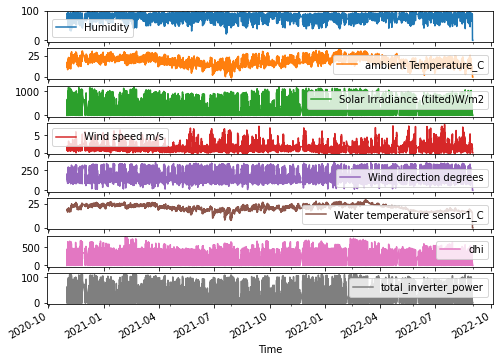

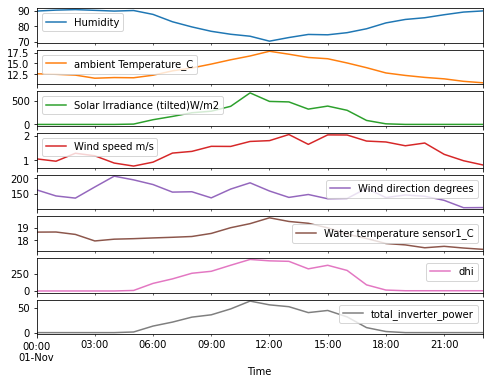

In [12]:
'''

wv = df.pop('Wind speed m/s')
# Convert to radians.
wd_rad = df.pop('Wind direction degrees')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)
'''
#wd_rad = df.pop('Wind direction degrees')*np.pi / 180




## TIME as a feature
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

#df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year)).values
#df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day)).values
#df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day)).values
#df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year)).values


#df['Hour']=df.index.hour
#df['Month']=df.index.month

# plot
#plot_cols = ['total_inverter_power KW' ]
  
#https://www.visualcrossing.com/weather/weather-data-services#/editDataDefinition
#### Cloud cover and type


### kW to W cinversion
#
#df['Solar Irradiance (horizontal)W/m2']=horz

## july 2022
horz=df.pop('Solar Irradiance (horizontal)W/m2')
dni=df.pop('dni')
clearness_index=df.pop('clearness_index')  ## excluded and in the iceemdan it is commented as the matlab df_total includes it butnot


#df['total_inverter_power']=(df.pop('Total inverter power KW'))*1000 ##W conversion
## should use in july as it is in kw
df['total_inverter_power']=(df.pop('Total inverter power KW'))*1 ##Kilo kW conversion

#df['Solar Irradiance (tilted)W/m2']=df.pop('Solar Irradiance (tilted)W/m2')

#df.columns = [c.lower().replace(' ', '_') for c in df.columns]
               

single_day=int(1440/minute)

plot_features = df
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[:single_day]
plot_features.index = date_time[:single_day]
_ = plot_features.plot(subplots=True)
  


import copy
df_total = copy.deepcopy(df)


date_time = df.index



In [ ]:
import copy
df_total = copy.deepcopy(df)

In [ ]:
#https://stackoverflow.com/questions/33959124/plot-pandas-dataframe-with-subplots-subplots-true-place-legend-and-use-tight
# Plotting
df.plot(kind='line', subplots=True, grid=True, title="Sample Data (Unit)",
    layout=(4, 3), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'g', 'g', 'b', 'b', 'b', 'r', 'r', 'r'])

for ax in plt.gcf().axes:
    ax.legend(loc=1)

plot_features = df
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


plot_features = df[17204:17204+single_day*2]
plot_features.index = date_time[17204:17204+single_day*2]
_ = plot_features.plot(subplots=True)
  


df_total=df
print(df)
df
df_total.isnull().values.any()

TypeError: ignored

In [ ]:
import plotly.express as px # to plot the time series plot

plt.figure(figsize=(16,9))
fig = px.line(df_total, x=date_time, y='total_inverter_power', title='inverter_power with slider')
fig.update_xaxes(rangeslider_visible=True)
fig.show() 

<Figure size 1152x648 with 0 Axes>

In [ ]:
#https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/time-series-rnn-full-predict.ipynb#scrollTo=Ffa-_1dBgqGs

cols_plot = ['Consumption', 'Solar', 'Wind']

axes = time_series_df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

axes = time_series_df.plot(marker='.', alpha=0.5, linestyle='None')
plt.ylabel('Daily Totals (GWh)');

# SAve the comsol model data

## 5 min and 15 min data conversion

In [ ]:
#df['solar zenith']=solpos['zenith'].fillna(0)
#df['solar azimuth']=solpos['azimuth'].fillna(0)

In [ ]:
df.to_csv('COMSOL_df_total_60min_jan-dec_sampvsyst.csv')

In [ ]:
from numpy import asarray
from numpy import savetxt
import pandas as pd 
#https://towardsdatascience.com/how-to-export-pandas-dataframe-to-csv-2038e43d9c03#:~:text=Exporting%20the%20DataFrame%20into%20a,a%20CSV%20format%20like%20string.&text=sep%3A%20Specify%20a%20custom%20delimiter,the%20default%20is%20a%20comma.



#df_total_multi=df_total
#df_multi, scaler_multi_ICEEMDAN, dff=normalize(df_total_multi)
#/content/COMSOL_UFVPassaunaData2021-jan-dec21_v3.csv


#dataset = pd.read_csv('/content/COMSOL_PassaunaData_all_min-may20may22_v20_calcexcel_all_min_for_15minconv.csv')

# till july 22data  (only csv format... not csv utf-8)
#https://www.edureka.co/community/52722/unicodedecodeerror-codec-decode-position-invalid-start-byte
#when reading from drive
#dataset = pd.read_csv('/content/drive/MyDrive/forecasting_data2/weather_power_cloud_dataset/COMSOL_PassaunaData_all_min_v23_may20jul22_calcexcel_all_min_for_15minconv.csv', encoding='latin1')

# till sep 22data  (only csv format... not csv utf-8)
#https://www.edureka.co/community/52722/unicodedecodeerror-codec-decode-position-invalid-start-byte
#when reading from drive
dataset = pd.read_csv('/content/drive/MyDrive/forecasting_data2/weather_power_cloud_dataset/COMSOL_PassaunaData_all_min_v24_may20sep22_calcexcel_all_min_for_15minconv.csv', encoding='latin1')




import copy
df=copy.deepcopy(dataset)
  



#Solar Irradiance (horizontal)W/m2

data_minute='15min'
minute=15
hour_need_to_observed=24
hour_need_to_predict=1
sw_width=int((60/minute)*hour_need_to_observed)   ### for six hours 12 *6 when data is grouped as 5 min  $$ 48 means 48 hours
n_out=int((60/minute)*hour_need_to_predict)    ## 5 as in 5 min for one hour of prediction



###### group by 15 min 
df['Time']=pd.to_datetime(df['Time'])
df=df.resample(data_minute,on='Time').mean()   #https://stackoverflow.com/questions/14861023/resampling-minute-data
#df=df.resample('M',on='Time').mean()   #https://stackoverflow.com/questions/14861023/resampling-minute-data
#horz=df.pop('Solar Irradiance (horizontal)W/m2')
df

## for day time only
#df=df.between_time('06:00', '18:00')


### NaN or missing value filling
#df=df.fillna(method='ffill')
#df
#df.isnull().values.any()

####################################################
########################################## dropping nan value
########### comment df.dropna()  ## that way the missing dates will be NaN and will not be plotted
######## uncomment df.dropna() that way it will not be included but also there will be a linear line
#df=df.dropna()   #https://www.journaldev.com/33492/pandas-dropna-drop-null-na-values-from-dataframe#:~:text=Pandas%20DataFrame%20dropna()%20function%20is%20used%20to%20remove%20rows,NaT%2C%20and%20numpy.
#possible values are {0 or ‘index’, 1 or ‘columns’}, default 0. If 0, drop rows with null values. If 1, drop columns with missing values.

date_time = df.index

#df['Time']=date_time 

df.to_csv('COMSOL_PassaunaData_all_min_v24_may20sep22_calcexcel_monthly_v9.csv')
#dataset COMSOL_PassaunaData_all_min_v23_may20jul22_calcexcel_all_min_for_15minconv
#COMSOL_UFVPassaunaData2021-jan-dec21_v3
#savetxt('COMSOL_UFVPassaunaData2021-jan-dec21_v3.csv', df_total, delimiter=',')

## plot

<Figure size 864x720 with 0 Axes>

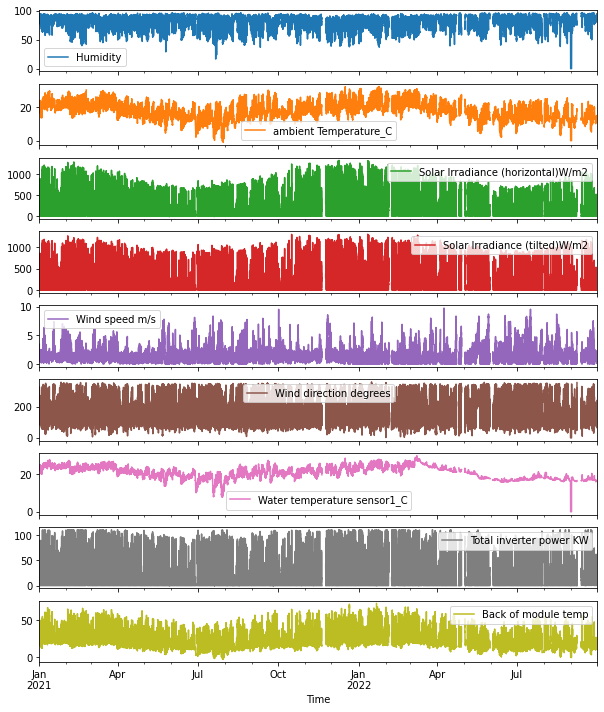

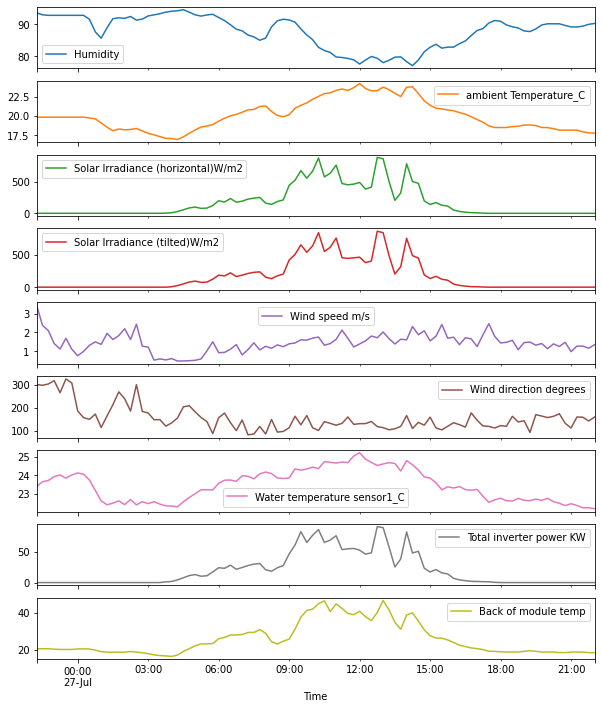

In [ ]:
         
import numpy as np
import matplotlib.pyplot as plt

df1=pd.DataFrame()
#df1['Time']=df['Time']
df1['Humidity']=df['Humidity']
df1['ambient Temperature_C']=df['ambient Temperature_C']
df1['Solar Irradiance (horizontal)W/m2']=df['Solar Irradiance (horizontal)W/m2']
df1['Solar Irradiance (tilted)W/m2']=df['Solar Irradiance (tilted)W/m2']
df1['Wind speed m/s']=df['Wind speed m/s']
df1['Wind direction degrees']=df['Wind direction degrees']
df1['Water temperature sensor1_C']=df['Water temperature sensor_new_eqn2']
df1['Total inverter power KW']=df['Total inverter power KW']


#df['Temperature Module 1 °C']= dataset['Temperature Module 1 °C']
#df['Temperature Module 2 °C']= dataset['Temperature Module 2 °C']
#df['Temperature Module 3 °C']= dataset['Temperature Module 3 °C']
#df['Temperature Module 4 °C']= dataset[' Temperature Module 4 °C']
df1['Back of module temp']= df['Temperature Module 5 °C']
#df['Temperature Module 6 °C']= dataset[' Temperature Module 6 °C']





#plt.figure(figsize=(16,9))
## only making 2021 onwards data set 
##df.drop(df[(df.index>='2021-11-21 00:00:00' )& (df.index< '2021-11-25 00:00:00')].index, inplace=True)

df1=df1[(df1.index>='2021-01-01 00:00:00' )]
date_time = df1.index

import copy
df_total = copy.deepcopy(df)

###  https://stackoverflow.com/questions/41890749/how-not-to-plot-missing-periods
#df1 = df1.reindex(pd.DatetimeIndex(df1.index), fill_value=np.nan )
fig = plt.figure(figsize=(12,10))

single_day=int(1440/minute)

plot_features = df1
plot_features.index = date_time
_ = plot_features.plot(figsize=(10,12),subplots=True)

plot_features = df1[:single_day]
plot_features.index = date_time[19865:19865+single_day]
_ = plot_features.plot(figsize=(10,12),subplots=True)
  


#https://stackoverflow.com/questions/34092343/dataframe-plot-exclude-missing-data
import matplotlib.pyplot as plt
#fig, ax = plt.subplots()
#ax.plot_date(date_time, df1['Humidity'],df1['ambient Temperature_C'])

## 3D plot with INOCT condition

In [ ]:
#plt.figure(figsize=(16,9))
## only making 2021 onwards data set 
##df.drop(df[(df.index>='2021-11-21 00:00:00' )& (df.index< '2021-11-25 00:00:00')].index, inplace=True)
#df.drop(df[(df['Unit_Price'] >400) & (df['Unit_Price'] < 600)].index, inplace=True)
######https://www.freecodecamp.org/news/drop-list-of-rows-from-pandas-dataframe/

         
import numpy as np
import matplotlib.pyplot as plt
dataset = pd.read_csv('/content/drive/MyDrive/forecasting_data2/weather_power_cloud_dataset/COMSOL_PassaunaData_all_min_v24_may20sep22_calcexcel_all_min_for_15minconv.csv', encoding='latin1')

import copy
df=copy.deepcopy(dataset)
  
data_minute='1min'
minute=1



###### group by 15 min 
df['Time']=pd.to_datetime(df['Time'])
df=df.resample(data_minute,on='Time').mean()   #https://stackoverflow.com/questions/14861023/resampling-minute-data
#df=df.resample('M',on='Time').mean()   #https://stackoverflow.com/questions/14861023/resampling-minute-data
#horz=df.pop('Solar Irradiance (horizontal)W/m2')
df

In [ ]:



#df1.drop(df1[(df1['Wind speed m/s']<0.95) & (df1['Wind speed m/s']>1.05)].index, axis=0, inplace=True)
#df1=df1[(df1['Wind speed m/s']>=0.95 & df1['Wind speed m/s']<=1.05 )]
df1=pd.DataFrame()
#df1['Time']=df['Time']
df1['Humidity']=df['Humidity']
df1['ambient Temperature_C']=df['ambient Temperature_C']
df1['Solar Irradiance (horizontal)W/m2']=df['Solar Irradiance (horizontal)W/m2']
df1['Solar Irradiance (tilted)W/m2']=df['Solar Irradiance (tilted)W/m2']
df1['Wind speed m/s']=df['Wind speed m/s']
df1['Wind direction degrees']=df['Wind direction degrees']
df1['Water temperature sensor1_C']=df['Water temperature sensor_new_eqn2']
df1['Total inverter power KW']=df['Total inverter power KW']


#df['Temperature Module 1 °C']= dataset['Temperature Module 1 °C']
#df['Temperature Module 2 °C']= dataset['Temperature Module 2 °C']
#df['Temperature Module 3 °C']= dataset['Temperature Module 3 °C']
#df['Temperature Module 4 °C']= dataset[' Temperature Module 4 °C']
df1['Back of module temp']= df['Temperature Module 5 °C']
#df['Temperature Module 6 °C']= dataset[' Temperature Module 6 °C']
df1

df1.drop(df1[(df1['Wind speed m/s']<0.95)].index, axis=0, inplace=True)

df1.drop(df1[(df1['Wind speed m/s']>1.05)].index, axis=0, inplace=True)

df1.drop(df1[(df1['ambient Temperature_C']<19.5)].index, axis=0, inplace=True)
df1.drop(df1[(df1['ambient Temperature_C']>20.5)].index, axis=0, inplace=True)

df1.drop(df1[(df1['Solar Irradiance (tilted)W/m2']<795)].index, axis=0, inplace=True)
df1.drop(df1[(df1['Solar Irradiance (tilted)W/m2']>805)].index, axis=0, inplace=True)
df1.dropna() 

Humidity  ambient Temperature_C  \
Time                                                    
2020-06-08 11:08:00  68.680000              19.869999   
2020-06-08 11:09:00  68.099998              19.920000   
2021-02-09 09:02:00  75.459999              19.889999   
2021-05-27 10:50:00  57.899998              19.600000   
2021-05-27 10:51:00  60.639999              19.820000   
2021-09-02 10:56:00  62.739998              20.059999   

                     Solar Irradiance (horizontal)W/m2  \
Time                                                     
2020-06-08 11:08:00                         606.720764   
2020-06-08 11:09:00                         607.154236   
2021-02-09 09:02:00                         859.668030   
2021-05-27 10:50:00                         618.286926   
2021-05-27 10:51:00                         618.286926   
2021-09-02 10:56:00                         678.348328   

                     Solar Irradiance (tilted)W/m2  Wind speed m/s  \
Time                                                                 
2020-06-08 11:08:00                     795.172974            1.03   
2020-06-08 11:09:00                     796.514954            0.97   
2021-02-09 09:02:00                     802.249268            1.04   
2021-05-27 10:50:00                     803.191956            1.02   
2021-05-27 10:51:00                     803.191956            1.05   
2021-09-02 10:56:00                     796.058960            0.98   

                     Wind direction degrees  Water temperature sensor1_C  \
Time                                                                       
2020-06-08 11:08:00              241.169998                    21.243549   
2020-06-08 11:09:00              288.279999                    21.233401   
2021-02-09 09:02:00              247.849991                    21.912676   
2021-05-27 10:50:00              324.139984                    19.878028   
2021-05-27 10:51:00              221.479996                    20.322318   
2021-09-02 10:56:00              312.529999                    20.721788   

                     Total inverter power KW  Back of module temp  
Time                                                               
2020-06-08 11:08:00                86.704913            42.030663  
2020-06-08 11:09:00                86.442913            42.438171  
2021-02-09 09:02:00                95.391903            33.781902  
2021-05-27 10:50:00                89.443909            41.396336  
2021-05-27 10:51:00                89.865910            41.396336  
2021-09-02 10:56:00                68.746929            50.912937

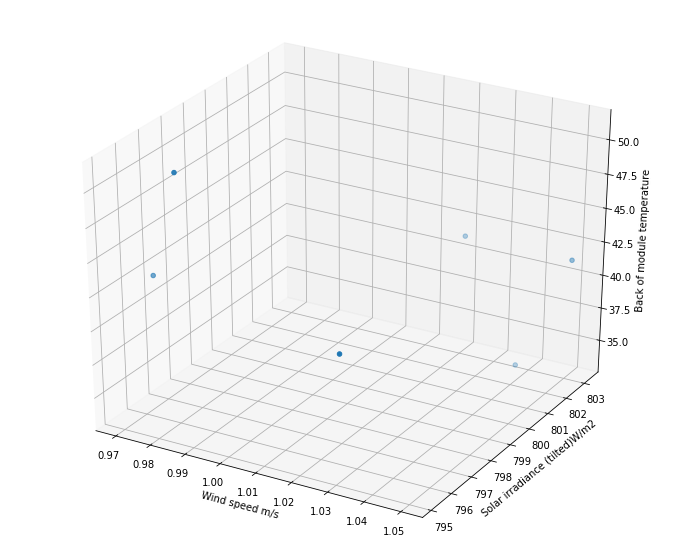

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')
ax.scatter3D(df1['Wind speed m/s'], df1['Solar Irradiance (tilted)W/m2'], df1['Back of module temp'], cmap='viridis')
ax.set_xlabel('Wind speed m/s')
ax.set_ylabel('Solar irradiance (tilted)W/m2')
ax.set_zlabel('Back of module temperature');

## 3D graph creation

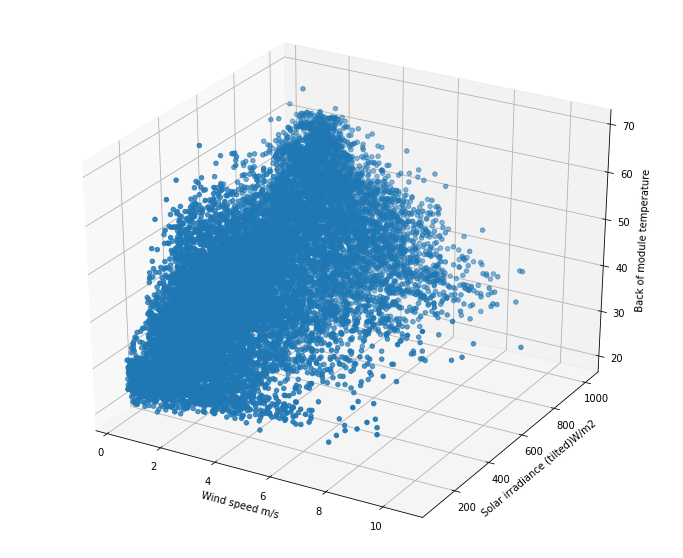

In [ ]:
from numpy import asarray
from numpy import savetxt
import pandas as pd 
#https://towardsdatascience.com/how-to-export-pandas-dataframe-to-csv-2038e43d9c03#:~:text=Exporting%20the%20DataFrame%20into%20a,a%20CSV%20format%20like%20string.&text=sep%3A%20Specify%20a%20custom%20delimiter,the%20default%20is%20a%20comma.
from mpl_toolkits import mplot3d
#https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#fig = plt.figure()
#ax = plt.axes(projection='3d')

#dataset = pd.read_csv('/content/COMSOL_PassaunaData_all_min-may20may22_v20_calcexcel_all_min_for_15minconv.csv')
# oct 22 (only csv format... not csv utf-8)
#https://www.edureka.co/community/52722/unicodedecodeerror-codec-decode-position-invalid-start-byte
#when reading from drive
'''
df['Time']=dataset['Time']
df['Humidity']=dataset['Humidity']
df['ambient Temperature_C']=dataset['ambient Temperature_C']
df['Solar Irradiance (horizontal)W/m2']=dataset['Solar Irradiance (horizontal)W/m2']
df['Solar Irradiance (tilted)W/m2']=dataset['Solar Irradiance (tilted)W/m2']
df['Wind speed m/s']=dataset['Wind speed m/s']
df['Wind direction degrees']=dataset['Wind direction degrees']
df['Water temperature sensor1_C']=dataset['Water temperature sensor_new_eqn2']
df['Total inverter power KW']=dataset['Total inverter power KW']


df['Temperature Module 1 °C']= dataset['Temperature Module 1 °C']
df['Temperature Module 2 °C']= dataset['Temperature Module 2 °C']
df['Temperature Module 3 °C']= dataset['Temperature Module 3 °C']
df['Temperature Module 4 °C']= dataset[' Temperature Module 4 °C']
df['back of module temp']= dataset['Temperature Module 5 °C']
df['Temperature Module 6 °C']= dataset[' Temperature Module 6 °C']

'''




dataset = pd.read_csv('/content/COMSOL_PassaunaData_all_min_v23_may20jul22_powerBI_filter.csv')




#plt.figure(figsize=(16,9))

fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')
ax.scatter3D(dataset['Wind speed m/s'], dataset['Solar Irradiance (tilted)W/m2'], dataset['Temperature Module 5 °C'], cmap='viridis')
ax.set_xlabel('Wind speed m/s')
ax.set_ylabel('Solar irradiance (tilted)W/m2')
ax.set_zlabel('Back of module temperature');


In [ ]:
dataset

Time   Humidity  ambient Temperature_C  \
0      5/19/2020 14:02  52.559998                  23.61   
1      5/19/2020 14:03  52.529999                  23.69   
2      5/19/2020 14:04  52.239998                  23.79   
3      5/19/2020 14:05  50.950001                  23.80   
4      5/19/2020 14:06  51.139999                  23.61   
...                ...        ...                    ...   
15587   5/2/2022 13:44  68.379997                  24.47   
15588   5/2/2022 13:54  73.849998                  23.57   
15589   5/2/2022 14:50  74.849998                  23.55   
15590   5/2/2022 14:57  74.180000                  23.97   
15591   5/2/2022 14:59  74.180000                  23.97   

       Solar Irradiance (tilted)W/m2  Water temperature sensor_new_eqn2  \
0                         805.183716                          22.341955   
1                         802.339050                          22.280230   
2                         801.840515                          22.400763   
3                         805.134094                          21.871164   
4                         804.472534                          21.611482   
...                              ...                                ...   
15587                     296.934387                          23.165930   
15588                     198.294128                          23.165930   
15589                     800.191345                          22.564981   
15590                     289.446991                          22.564981   
15591                     708.587219                          22.564981   

       Wind speed m/s  Wind direction degrees  \
0                0.64              173.669998   
1                1.22               15.110000   
2                0.80              216.909988   
3                2.71               52.379997   
4                3.45               10.190000   
...               ...                     ...   
15587            1.89               57.299999   
15588            1.10              357.529999   
15589            1.32              109.329994   
15590            1.28              287.570007   
15591            0.95              138.509995   

       Solar Irradiance (horizontal)W/m2  Total inverter power KW  \
0                             603.207825                80.216920   
1                             600.843994                80.825919   
2                             598.841431                80.743919   
3                             599.234253                79.838920   
4                             598.568237                80.050920   
...                                  ...                      ...   
15587                         279.436768                34.881966   
15588                         204.820053                22.357978   
15589                         629.467041                81.591915   
15590                         247.592010                24.843975   
15591                         556.202698                73.147926   

       Temperature Module 1 °C  ...  \
0                    45.198017  ...   
1                    45.302734  ...   
2                    45.299301  ...   
3                    45.056068  ...   
4                    44.654526  ...   
...                        ...  ...   
15587                37.335827  ...   
15588                33.625263  ...   
15589                35.490994  ...   
15590                39.990173  ...   
15591                39.399258  ...   

       for 15 min data 2020-2022 all data linear fit eqn mod temp  \
0                                              44.598633            
1                                              44.405004            
2                                              44.619498            
3                                              44.085834            
4                                              43.650838            
...                                                  ...            
15587                     

In [ ]:
df1=df.dropna()
df1.to_csv('COMSOL_PassaunaData_all_min-may20may22_v20_calcexcel_15_min_v2.csv')



dataset = pd.read_csv('/content/COMSOL_PassaunaData_all_min-may20may22_v20_calcexcel_daytime_15_min.csv')
import copy
df=copy.deepcopy(dataset)
  



#Solar Irradiance (horizontal)W/m2

data_minute='15min'
minute=15
hour_need_to_observed=24
hour_need_to_predict=1
sw_width=int((60/minute)*hour_need_to_observed)   ### for six hours 12 *6 when data is grouped as 5 min  $$ 48 means 48 hours
n_out=int((60/minute)*hour_need_to_predict)    ## 5 as in 5 min for one hour of prediction



###### group by 15 min 
df['Time']=pd.to_datetime(df['Time'])
#df=df.resample(data_minute,on='Time').mean()   #https://stackoverflow.com/questions/14861023/resampling-minute-data
df=df.resample('M',on='Time').mean()   #https://stackoverflow.com/questions/14861023/resampling-minute-data
#horz=df.pop('Solar Irradiance (horizontal)W/m2')
df
#df=df.between_time('06:30', '18:00')


### NaN or missing value filling
#df=df.fillna(method='ffill')
#df
#df.isnull().values.any()




date_time = df.index

#df['Time']=date_time 

df.to_csv('COMSOL_PassaunaData_all_min-may20may22_v20_calcexcel_daytime_15_min_to_monthly.csv')
#dataset
#COMSOL_UFVPassaunaData2021-jan-dec21_v3
#savetxt('COMSOL_UFVPassaunaData2021-jan-dec21_v3.csv', df_total, delimiter=',')

# Linear regression

# Save as csv file

In [ ]:

from numpy import asarray
from numpy import savetxt
 
df_total_multi=copy.deepcopy(df_total)
#df_multi, scaler_multi_ICEEMDAN, dff=normalize(df_total_multi)


#savetxt('df_total.csv', df_total, delimiter=',')
#df_total_multi.to_csv('/content/drive/MyDrive/forecasting_data2/df_data_save_nov22/df_total_v24_nov1_22_15min_24h_10var.csv')
df_total_multi.to_csv('/content/df_total_formatlab_v24_nov1_22_60min_24h_9var_daytime.csv')


# Lag time selection- hour data and ACF, PCAF-partial auto correlation function

In [ ]:
### heat map of the data
'''
n = 7
df4=pd.concat([df2] * (n+1), axis=1, ignore_index=True)
(pd.concat([df4] * (n+1), axis=1, ignore_index=True)
   .rename(lambda x: chr(ord('A')+x), axis=1))
n = 7
df4=pd.concat([df2] * (n+1), axis=1, ignore_index=True)
df4=(pd.concat([df4], axis=1, ignore_index=True)
   .rename(lambda x: chr(ord('A')+x), axis=1))
df5=df2.T
df5

df6=df_total[0:24]
df6=df6.T
df2['mean']= df_total.mean(axis=1)
df2[0:24]
df7=df_total[24:48].T
https://pandas.pydata.org/pandas-docs/dev/reference/api/pandas.DataFrame.reset_index.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html
https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

https://stackoverflow.com/questions/27736267/pandas-reset-index-is-not-taking-effect
need to have same index than they can be in the column

df8=df_total[0:24*3]
df8=df8.reset_index(drop=True)
df9=df_total[24*3:24*6]
df9=df9.reset_index(drop=True)
df10=df_total[24*6:24*9]
df10=df10.reset_index(drop=True)
df11=df_total[24*9:24*12]
df11=df11.reset_index(drop=True)
result = pd.concat([df8, df9,df10,df11], axis=1)
df12=result.T
'''



'''

######## no need to run npw
### required to know what is the best previous hour data to predict next hour

df8=df_total[0:24*3]
df8=df8.reset_index(drop=True)
df9=df_total[24*3:24*6]
df9=df9.reset_index(drop=True)
df10=df_total[24*6:24*9]
df10=df10.reset_index(drop=True)
df11=df_total[24*9:24*12]
df11=df11.reset_index(drop=True)
result = pd.concat([df8, df9,df10,df11], axis=1)
df12=result.T

day=24*1

df2=df[day*0:day*(0+1)]
df2=df2.reset_index(drop=True)
for i in np.arange(df_total.shape[0]):
  df3=df[day*(i+1):day*(i+2)]
  df3=df3.reset_index(drop=True)
  df4=pd.concat([df2,df3],axis=1)
  df2=df4
  #print(i)
#########https://stackoverflow.com/questions/54563388/how-to-repeat-a-pandas-data-frame-column-x-amount-of-times
#https://seaborn.pydata.org/generated/seaborn.heatmap.html

df12=df2.T
#['total_inverter_power']
df1=df[['total_inverter_power']]

corr = df12.corr()
plt.figure(figsize=(45,45))
sns.heatmap(corr, annot=True, square=True, cmap="YlGnBu");


'''


############## work to do

#1. PCF first
### PCAF or ACF is god to know the exact value of previous lags
#https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8
#https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
#paper: two layer ICEEMDAN vmd
#Design and implementation of a hybrid model based on two-layerdecomposition method coupled with extreme learning machines tosupport real-time environmental monitoring of water
#quality parameters
#multicollinearity issues



y=df_total['total_inverter_power']
lag_acf = acf(df_total['total_inverter_power'], nlags=300)
plt.figure(figsize=(16, 7))
plt.plot(lag_acf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

#calling partial correlation function
lag_pacf = pacf(df_total['total_inverter_power'], nlags=100, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()
# 2. bayesian optimization: using just hidden layer neurons and batch size,,, 
#so lower search space

#https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/
#number of intervals between the two observations is the lag.... lag=1
#https://timeseriesreasoning.com/contents/partial-auto-correlation/
#the current value can be expressed as a function of the previous value, the value before that one and so forth

plot_pacf(y, lags=60)
pyplot.show()
#drop the top two rows as they contain NaNs
#df = df.drop(df.index[[0,1]])

# heat map correlation

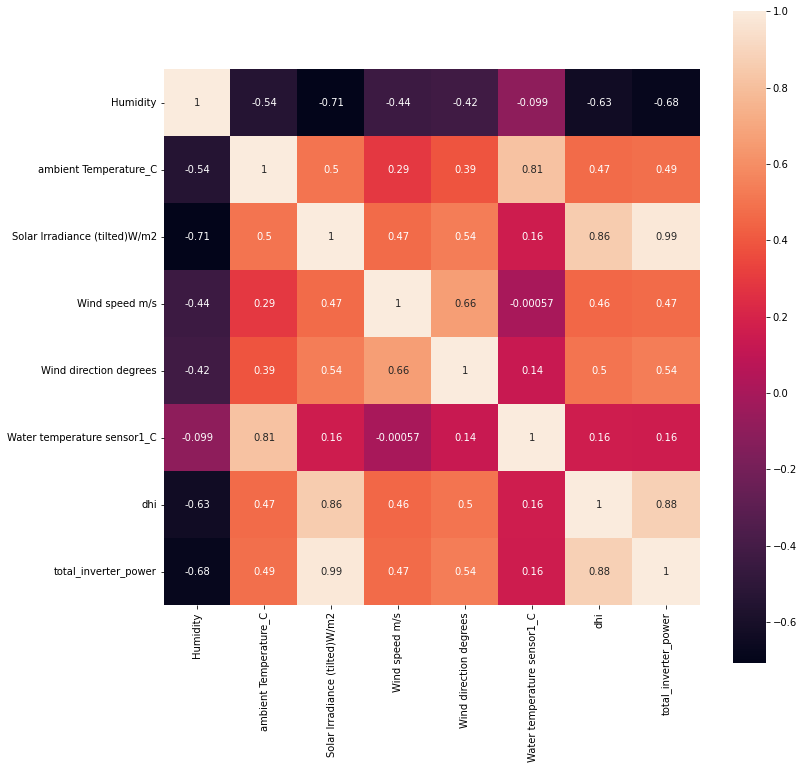

In [ ]:
### heat map of the data
#df_total['back of module temp']= dataset['Temperature Module 5 °C'].resample('60min').mean()
import seaborn as sns
corr = df_total.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, annot=True, square=True);

# timestamp train test split code

In [ ]:
n=df.shape[0]
total_days=int(df.shape[0]/((60/minute)*24))   ## 151 days
total_mins=int(df.shape[0]/(60/minute))
train_split_percent=0.7  ## previous 0.7
val_split_percent=0.91   #.91
'''
train = df[0:int(total_days*(train_split_percent)*(24*(60/minute)))]   ## days 120 days/151
val = df[int(total_days*(train_split_percent)*(24*(60/minute))):int(total_days*(val_split_percent)*(24*(60/minute)))]  ## 120 to 135 days
test = df[int(total_days*(val_split_percent)*(24*(60/minute))):]  ## 135 to 151 days

train_dates=date_time[0:int(total_days*(train_split_percent)*(24*(60/minute)))]
val_dates=date_time[int(total_days*(train_split_percent)*(24*(60/minute))):int(total_days*(val_split_percent)*(24*(60/minute)))]
test_dates = date_time[int(total_days*(val_split_percent)*(24*(60/minute))):]

df_total_power_unscaled1=df_total_power_unscaled[int(total_days*(val_split_percent)*(24*(60/minute))):]

y_test_unscaled = scaler_pred.inverse_transform(test_y.reshape(-1, 1))
RMSE = mean_squared_error(y_test_unscaled, df_total_power_unscaled1[sw_width:n_out], squared=False)

'''

timestamp_s = date_time.map(pd.Timestamp.timestamp)
train_timestamp_s=timestamp_s[0:int(total_days*(train_split_percent)*(24*(60/minute)))]
val_timestamp_s=timestamp_s[int(total_days*(train_split_percent)*(24*(60/minute))):int(total_days*(val_split_percent)*(24*(60/minute)))]
test_timestamp_s = timestamp_s[int(total_days*(val_split_percent)*(24*(60/minute))):]

print(timestamp_s.shape,train_timestamp_s.shape,val_timestamp_s.shape,test_timestamp_s.shape)
total_days
T=timestamp_s

(23328,) (16329,) (4899,) (2100,)


# Pair plot

In [ ]:


%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
# Plot the pairplot to discover correlation between power generation and other variables.
sns.set(style="ticks")
sns.pairplot(df_total)
#https://github.com/chezou/solar-power-prediction/blob/master/Power_generation.ipynb


# Feature selection: select k best, f regression

In [ ]:
### feature selection
##https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
#https://machinelearningmastery.com/feature-selection-machine-learning-python/
#https://www.datacamp.com/community/tutorials/feature-selection-python




X = df.iloc[:,:]  #independent columns
y = df.iloc[:,-1]    #target column i.e power


bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(df.shape[1],'Score'))  #print 10 best features

#https://machinelearningmastery.com/feature-selection-for-regression-data/
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X, y)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()


fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(X, y)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()
'''
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest('all','Score'))  #print 10 best features

from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()
'''



# PCA analysis of data

In [ ]:

### PCA analysis of data
# feature extraction
pca = PCA(n_components=3)
fit = pca.fit(X)
# summarize components
print("Explained Variance: %s" % fit.explained_variance_ratio_)
print(fit.components_)

'''
# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, y)
print(model.feature_importances_)
'''

Explained Variance: [9.99984859e-01 1.08675006e-05 3.11555018e-06]
[[-2.29811707e-04  7.58124303e-05  9.35675736e-03  1.54388155e-05
  -1.32080681e-04  1.71881625e-03  1.38173806e-05  9.99954709e-01]
 [-3.99639519e-02  1.46052864e-02  1.06944340e-01  1.19859541e-03
   2.55853212e-02  9.93017884e-01 -2.13176253e-03 -2.71449162e-03]
 [-3.67506622e-02  1.43050913e-03  9.91940214e-01 -4.62773130e-04
  -5.64916297e-02 -1.06898073e-01 -4.14529787e-04 -9.11402130e-03]]


'\n# feature extraction\nmodel = ExtraTreesClassifier(n_estimators=10)\nmodel.fit(X, y)\nprint(model.feature_importances_)\n'

f regresion

In [ ]:

# generate dataset
#X, y = make_regression(n_samples=100, n_features=100, n_informative=10)
# define feature selection
fs = SelectKBest(score_func=f_regression, k='all')
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(43488, 7)


# feature importance

In [ ]:
lasso = Lasso(alpha = 0.001)
X = df.iloc[:,0:(df.shape[1]-1)]  #independent columns
y = df.iloc[:,-1]    #target column i.e power

lasso.fit(X, y)
y_pred_lasso = lasso.predict(X)
lasso_coeff = pd.DataFrame({'Feature Importance':lasso.coef_}, index=df.columns[:-1])
lasso_coeff.sort_values('Feature Importance', ascending=False)
g = lasso_coeff[lasso_coeff['Feature Importance']!=0].sort_values('Feature Importance').plot(kind='barh',figsize=(6,6), cmap='winter')


# seasonality trending unit root non stationary test

In [ ]:
#### seasonality trending unit root non stationary of time series data
#https://analystprep.com/study-notes/frm/part-1/quantitative-analysis/nonstationary-time-series/
#https://machinelearningmastery.com/time-series-data-stationary-python/



series=df_total
series.hist()
pyplot.show()
#Below is an example of the Airline Passengers dataset that is non-stationary,
# showing both trend and seasonal components.

# an obvious seasonality component, and it looks like the seasonality component is growing.
#A log transform can be used to flatten out exponential change back to a linear relationship.

#Next, we can split the time series into two contiguous sequences. 
#We can then calculate the mean and variance of each group of numbers and compare the values.
X = series.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

#same histogram with a log transform of the time series.
#X = series.values

#mean and standard deviation of the values of the log transformed dataset.
#https://www.researchgate.net/post/can_we_replace-Inf_values_after_log_transformations_with_zero
#if true zeros are abundant, consider box-cox instead of a log, 
#a more generic transform that has a log as a particular case
#https://stats.stackexchange.com/questions/1444/how-should-i-transform-non-negative-data-including-zeros
#It is a bad statistical practice to use a transformation that causes to lose data points,
# you can add a constant term such as log(x + 1)
#https://machinelearningmastery.com/power-transforms-with-scikit-learn/
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html

# power transform the raw data
'''
# perform a box-cox transform of the dataset
scaler = MinMaxScaler(feature_range=(1, 2))
power = PowerTransformer(method='box-cox')
pipeline = Pipeline(steps=[('s', scaler),('p', power)])
data = pipeline.fit_transform(data)
power = PowerTransformer(method='yeo-johnson', standardize=True)
data_trans = power.fit_transform(X)
# histogram of the transformed data
pyplot.hist(data_trans, bins=25)
pyplot.show()


X = log(X)
pyplot.hist(X)
pyplot.show()
pyplot.plot(X)
pyplot.show()


X = log(X)
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

'''
scaler_log_scale = MinMaxScaler(feature_range=(1, 2))
power_log = PowerTransformer(method='box-cox')
pipeline = Pipeline(steps=[('s', scaler_log_scale),('p', power_log)])
data_log = pipeline.fit_transform(X)
# convert the array back to a dataframe
dataset_log = DataFrame(data_log)
# histograms of the variables
dataset_log.hist()
pyplot.show()


split = round(len(data_log) / 2)
X1, X2 = data_log[0:split], data_log[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))


'''
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.
The intuition behind a unit root test is that it 
determines how strongly a time series is defined by a trend.
The null hypothesis of the test is that the time series can be represented by a unit root, 
that it is not stationary (has some time-dependent structure). 
The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, 
it suggests the time series has a unit root, meaning it is non-stationary. 
It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; 
it suggests the time series does not have a unit root, meaning it is stationary.
 It does not have time-dependent structure
 We interpret this result using the p-value from the test.
  A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary),
   otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0),
 the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), 
the data does not have a unit root and is stationary.
'''
#https://pythondata.com/stationary-data-tests-for-time-series-forecasting/
#https://machinelearningmastery.com/time-series-data-stationary-python/
#Augmented Dickey-Fuller test
X = series.values

for i in np.arange(X.shape[1]):

  result = adfuller(X[:,i])
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

#We can see that the value is larger than the critical values, again, 
#meaning that we can fail to reject the null hypothesis 
#and in turn that the time series is non-stationary.



#https://machinelearningmastery.com/time-series-seasonality-with-python/
#The model of seasonality can be removed from the time series. 
#This process is called Seasonal Adjustment, or Deseasonalizing.



#Time Series Decomposition function in Python
#https://stackoverflow.com/questions/20672236/time-series-decomposition-function-in-python
#https://www.statsmodels.org/stable/examples/notebooks/generated/stl_decomposition.html
#dta = sm.datasets.co2.load_pandas().df_total
#dta =df_total
# deal with missing values. see issue
#dta.co2.interpolate(inplace=True)
#dta=df
#dta.index = pd.DatetimeIndex(date_time, freq=data_minute)
#res = sm.tsa.seasonal_decompose(dta)
#resplot = res.plot()
#res.resid
#res.seasonal
#res.trend

#https://stackoverflow.com/questions/34457281/decomposing-trend-seasonal-and-residual-time-series-elements?noredirect=1&lq=1

#dta=dfmine
#dta=dta.reset_index(drop=True,inplace=True)
'''
dta=dfmine
dta.reset_index(inplace=True)
#dta['Time'] = pd.to_datetime(dta['Time'])
dta.index.asfreq(freq='d')
s=sm.tsa.seasonal_decompose(ts1)
dta = dta.set_index('Time')
s=sm.tsa.seasonal_decompose(ts1,freq='15min')

dfmine=df
dfmine.reset_index(inplace=True)
dfmine['Date'] = pd.to_datetime(dfmine['Time'])
dfmine = dfmine.set_index('Date')
s=seasonal_decompose(dfmine.Humidity)
plt.plot(s.trend)
s.plot()
'''
#pip install rpy2
#https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
#https://stackoverflow.com/questions/64025453/attributeerror-rangeindex-object-has-no-attribute-inferred-freq

#data_minute='1440min'
#minute=1440

## only monthly or daily prediction is possible
if minute==1440:
  dfmine=df
  dfmine.reset_index(inplace=True)

  dfmine['Time'] = pd.to_datetime(date_time)
  dfmine = dfmine.set_index('Time')
  # Specify datetime frequency
  dfmine.index
  dfmine = dfmine.asfreq('d')
  dfmine.index

  result = seasonal_decompose(dfmine.humidity, model='additive')
  print(result.trend)
  print(result.seasonal)
  print(result.resid)
  print(result.observed)
  result.plot()
  pyplot.show()

  #series=dfmine
  #X = series.values
  for i in np.arange(dfmine.shape[1]):
    result = seasonal_decompose(dfmine.iloc[:,i], model='additive')
    print(result.trend)
    print(result.seasonal)
    print(result.resid)
    print(result.observed)
    result.plot()
    pyplot.show()

#df.pop('Time')
#s.resid
#s.seasonal
#s.trend

'''
#df_total['total_inverter_power']
def decompose(series, frequency, s_window = 'periodic',  **kwargs):

    df = pd.DataFrame()
    df['date'] = series.index
    
    s = [x for x in series.values]
    length = len(series)
    s = r.ts(s, frequency=frequency)
    decomposed = [x for x in r.stl(s, s_window).rx2('time.series')]
    df['observed'] = series.values
    df['trend'] = decomposed[length:2*length]
    df['seasonal'] = decomposed[0:length]
    df['residuals'] = decomposed[2*length:3*length]
    return df


obs_per_cycle = 52
observations = obs_per_cycle * 3
#data = [v+2*i for i,v in enumerate(np.random.normal(5, 1, observations))]
#tidx = pd.date_range('2016-07-01', periods=observations, freq='w')
#series1=df.iloc[:,0]
#type(series1)
tidx =date_time
ts1 = pd.Series(data=series1, index=tidx)
df_decomposed = decompose(ts1, frequency=obs_per_cycle, s_window = 'periodic')
df_decomposed
'''

'''
    Decompose a time series into seasonal, trend and irregular components using loess, 
    acronym STL.
    https://www.rdocumentation.org/packages/stats/versions/3.4.3/topics/stl

    params:
        series: a time series

        frequency: the number of observations per “cycle” 
                   (normally a year, but sometimes a week, a day or an hour)
                   https://robjhyndman.com/hyndsight/seasonal-periods/

        s_window: either the character string "periodic" or the span 
                 (in lags) of the loess window for seasonal extraction, 
                 which should be odd and at least 7, according to Cleveland 
                 et al.




        log:    boolean.  take log of series



        **kwargs:  See other params for stl at 
           https://www.rdocumentation.org/packages/stats/versions/3.4.3/topics/stl
'''

# Defining the matrix 

In [31]:

target_num= -1   # was 3 if the  conversion has not done but now it is at the end 0 to 7

#df=df_total[df_total['total_inverter_power KW']!=0]
#transpose=df.describe().transpose()
# We add a prediction column and set dummy values to prepare the data for scaling
#data_filtered_ext = data_filtered.copy()
#data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
#data_filtered_ext.tail() 
  
df=copy.deepcopy(df_total)

#cloud=df.pop('cloudcover') 
# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler(feature_range=(0, 1))
df_total_power = pd.DataFrame(df_total.iloc[: , -1])
df_total_power_scaled = scaler_pred.fit_transform(df_total_power)
df_total_power_unscaled = scaler_pred.inverse_transform(df_total_power_scaled)



#df = pd.DataFrame(my_array, columns = ['Column_A','Column_B','Column_C'])
    
#main_run(df)
#main_run(dataset, sliding_window_width, name, input_sequence_start, verbose_set, epochs_num, batch_size_set)
# normalize
df, scaler_multi, dff=normalize(df)
# Divide training set and test set
train, val, test, train_dates, val_dates, test_dates=split_dataset(df,minute)   

print(train.shape,val.shape,test.shape)
#total_days   

[  96.37049713   32.41183236 1182.34913942    8.14199982  353.3458262
   29.72374344  788.85840251  111.14263929]
(12211, 8) (1526, 8) (1549, 8)


In [ ]:
test_dates.shape

(1593,)

In [ ]:
'''
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_total_power_unscaled,minute) 
test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out,
                                in_start=0, increment=n_out,target_num=target_num)
test_y.reshape(-1,1)
max(test_y_unscaled-test_y.reshape(-1,1)) 
'''

# Define matrix 2

In [32]:
history={}
model={}
training_time_took={}

val_performance = {}
test_performance = {}
RMSE={}
sMAPE={}
MAAPE={}
MAE={}
R2={}
RMSE_scaled={}
y_pred_scaled={}
y_pred_unscaled={}
timestamp_s = date_time.map(pd.Timestamp.timestamp)
T=timestamp_s
#sd=pd.DataFrame(numparraypredictions_multi_GRU.reshape(-1,1), columns = ['Column_A'])
#sd
#https://towardsdatascience.com/7-popular-activation-functions-you-should-know-in-deep-learning-and-how-to-use-them-with-keras-and-27b4d838dfe6
#leaky_relu = LeakyReLU(alpha=0.01)
#para_relu = PReLU()
#Dense(10, activation=para_relu)
#Dense(10, activation=leaky_relu)
#dfdfff = pd.DataFrame(df_total_power_unscaled, columns = ['Column_A'])

# Analysis starts

# DARTS

In [ ]:
#https://unit8co.github.io/darts/examples/04-RNN-examples.html
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)



ModuleNotFoundError: ignored

In [ ]:
type(series.squeeze())

In [ ]:
# Read data:
series = copy.deepcopy(df_total)

# Create training and validation sets:
train, val = series.squeeze().split_after(pd.Timestamp("19590101"))

In [ ]:


# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create month and year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp("19590101"))

my_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Air_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True,
)

my_model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True,
)

def eval_model(model):
    pred_series = model.predict(n=26, future_covariates=covariates)
    plt.figure(figsize=(8, 5))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))
    plt.legend()


eval_model(my_model)

best_model = RNNModel.load_from_checkpoint(model_name="Air_RNN", best=True)
eval_model(best_model)

backtest_series = my_model.historical_forecasts(
    series_transformed,
    future_covariates=covariates,
    start=pd.Timestamp("19590101"),
    forecast_horizon=6,
    retrain=False,
    verbose=True,
)

plt.figure(figsize=(8, 5))
series_transformed.plot(label="actual")
backtest_series.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 1959, 6-months horizon")
print(
    "MAPE: {:.2f}%".format(
        mape(
            transformer.inverse_transform(series_transformed),
            transformer.inverse_transform(backtest_series),
        )
    )
)

# Multivariate GRU Lstm code running code

In [27]:
## check if required
hour_need_to_observed=24
hour_need_to_predict=1

sw_width=int((60/minute)*hour_need_to_observed)   ### for six hours 12 *6 when data is grouped as 5 min  $$ 48 means 48 hours
n_out=int((60/minute)*hour_need_to_predict)    ## 5 as in 5 min for one hour of prediction


[  96.37049713   32.41183236 1182.34913942    8.14199982  353.3458262
   29.72374344  788.85840251  111.14263929]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 400)               654400    
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 400)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 1, 400)            1281600   
                                                                 
 dropout_1 (Dropout)         (None, 1, 400)            0         
                                                                 
 time_di

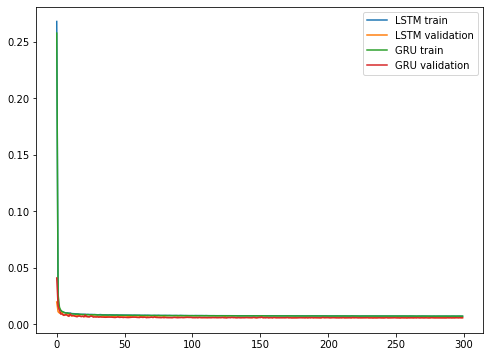

In [33]:
#### multivariate data
tf.compat.v1.reset_default_graph()
import copy
df=copy.deepcopy(df_total)
    
#main_run(df)
#main_run(dataset, sliding_window_width, name, input_sequence_start, verbose_set, epochs_num, batch_size_set)

df, scaler_multi, dff=normalize(df)
# Divide training set and test set
train, val, test, train_dates, val_dates, test_dates=split_dataset(df,minute)   

# normalize
#train, scaler_multi, dff=normalize(train) ## fitted on the training data set.. as scaler_multi.fit (train)
#val=scaler_multi.transform(val)
#test=scaler_multi.transform(test)


max_epochs=300

name='multivariate_LSTM'
start_time = time.time()
history[name], model[name] = compile_and_fit_LSTM(
      train, val, name, optimizer=None, max_epochs=max_epochs,target_num=target_num,
      sw_width=sw_width,n_out=n_out, in_start=0, increment=1)
training_time_took[name] = time.time() - start_time
#save_model(model[name],'multiLSTM5min.h5')

val_x, val_y = sliding_window(val, sw_width=sw_width,n_out=n_out, 
                              in_start=0, increment=n_out,target_num=target_num)

val_x = val_x.reshape((val_x.shape[0], val_x.shape[1], val_x.shape[2])) 
val_y = val_y.reshape((val_y.shape[0], val_y.shape[1]))

test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out,
                                in_start=0, increment=n_out,target_num=target_num)

test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1]))
#old_weights=model[name].get_weights

val_performance[name] = model[name].evaluate(val_x, val_y, verbose=1)
test_performance[name] =model[name].evaluate(test_x, test_y, verbose=1)

plt.plot(history[name].history['loss'], label='LSTM train')
plt.plot(history[name].history['val_loss'], label='LSTM validation')
plt.legend();

name='multivariate_GRU'
start_time = time.time()
history[name], model[name] = compile_and_fit_GRU(
      train, val, name, optimizer=None, max_epochs=max_epochs,target_num=target_num,
      sw_width=sw_width,n_out=n_out, in_start=0, increment=1)
training_time_took[name] = time.time() - start_time
#save_model(model[name],'multiGRU5min.h5') 


val_performance[name] = model[name].evaluate(val_x, val_y, verbose=1)
test_performance[name] =model[name].evaluate(test_x, test_y, verbose=1)

plt.plot(history[name].history['loss'], label='GRU train')
plt.plot(history[name].history['val_loss'], label='GRU validation')
plt.legend();


#plt.plot(history.history[name]['loss'], label='train')
#plt.plot(history.history[name]['val_loss'], label='test')
#plt.legend();

KeyError: ignored

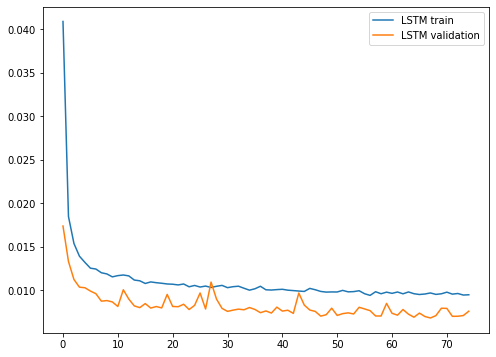

In [ ]:
##Model Fit
#history_simple = model_simple.fit(X1, y1, epochs=200, batch_size=32,callbacks=[lr_schedule],validation_split=0.3,shuffle=False)
name="multivariate_LSTM"
plt.plot(history[name].history["loss"], label="LSTM train")
plt.plot(history[name].history["val_loss"], label="LSTM validation")
plt.legend();


plt.semilogx(history[name].history["lr"], history[name].history["loss"])
plt.axis([1e-8, 100, 0, 60])
plt.ylim(0,0.5)
plt.ylabel("d/loss")
plt.xlabel("learning rate (log scale)")
plt.title("Learning Rate vs Loss")


name="multivariate_GRU"
plt.semilogx(history[name].history["lr"], history[name].history["loss"])
plt.axis([1e-8, 100, 0, 60])
plt.ylim(0,0.5)
plt.ylabel("d/loss")
plt.xlabel("learning rate (log scale)")
plt.title('Learning Rate vs Loss')


(1e-05, 100)

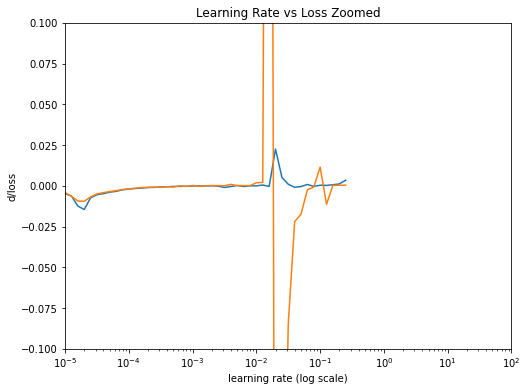

In [ ]:
name="multivariate_LSTM"

sma=1
n_skip=1
y_lim=(-0.1,0.1)
"""
Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
derivatives = [0] * (sma + 1)
for i in range(1 + sma,len(history[name].history["loss"])):
  derivative = (history[name].history["loss"][i] - history[name].history["loss"][i - sma]) / sma
  derivatives.append(derivative)
        
plt.ylabel("d/loss")
plt.xlabel("learning rate (log scale)")
plt.title('Learning Rate vs Loss Zoomed')
plt.plot(history[name].history["lr"][10:], derivatives[10:])
plt.xscale('log')
plt.ylim(y_lim)
plt.xlim(1e-5,100)


name="multivariate_GRU"

sma=1
n_skip=1
y_lim=(-0.1,0.1)
"""
Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
derivatives = [0] * (sma + 1)
for i in range(1 + sma,len(history[name].history["loss"])):
  derivative = (history[name].history["loss"][i] - history[name].history["loss"][i - sma]) / sma
  derivatives.append(derivative)
        
plt.ylabel("d/loss")
plt.xlabel("learning rate (log scale)")
plt.title('Learning Rate vs Loss Zoomed')
plt.plot(history[name].history["lr"][20:], derivatives[20:])
plt.xscale('log')
plt.ylim(y_lim)
plt.xlim(1e-5,100)




# Univariate GRU LSTM code running code

                     total_inverter_power
Time                                     
2020-11-01 00:00:00                   0.0
2020-11-01 01:00:00                   0.0
2020-11-01 02:00:00                   0.0
2020-11-01 03:00:00                   0.0
2020-11-01 04:00:00                   0.0
...                                   ...
2022-08-31 20:00:00                   0.0
2022-08-31 21:00:00                   0.0
2022-08-31 22:00:00                   0.0
2022-08-31 23:00:00                   0.0
2022-09-01 00:00:00                   0.0

[15286 rows x 1 columns]
[111.14263929]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                             

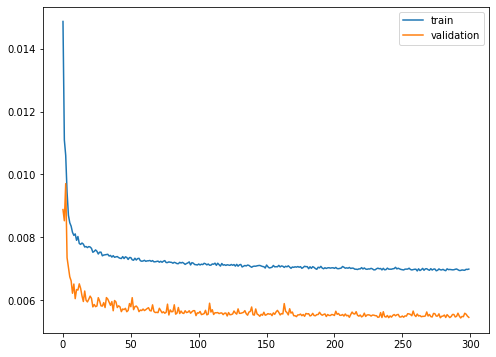

In [34]:
#univariate
univariate=1
if univariate== True:
    df_uni = pd.DataFrame(df_total.iloc[: , -1])
    #target_num=0
print(df_uni)
df_uni, scaler, dff=normalize(df_uni)
# Divide training set and test set
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_uni,minute)   

# normalize
#train, scaler_multi, dff=normalize(train) ## fitted on the training data set.. as scaler_multi.fit (train)
#val=scaler_multi.transform(val)
#test=scaler_multi.transform(test)


name='univariate_LSTM'
start_time = time.time()
history['univariate_LSTM'], model['univariate_LSTM'] = compile_and_fit_uni_LSTM(
      train, val, name, optimizer=None, max_epochs=max_epochs,target_num=target_num,
      sw_width=sw_width,n_out=n_out, in_start=0, increment=1)
training_time_took['univariate_LSTM'] = time.time() - start_time
save_model(model['univariate_LSTM'],'uniLSTM5min.h5')



name='univariate_GRU'  
start_time = time.time()
history['univariate_GRU'], model['univariate_GRU'] = compile_and_fit_uni_GRU(
      train, val, name, optimizer=None, max_epochs=max_epochs,target_num=target_num,
      sw_width=sw_width,n_out=n_out, in_start=0, increment=1)
training_time_took['univariate_GRU'] = time.time() - start_time
save_model(model['univariate_GRU'],'uniGRU5min.h5')  

val_x, val_y = sliding_window(val, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
val_x = val_x.reshape((val_x.shape[0], val_x.shape[1], val_x.shape[2])) 
val_y = val_y.reshape((val_y.shape[0], val_y.shape[1]))

test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1]))
val_performance['univariate_LSTM'] = model['univariate_LSTM'].evaluate(val_x, val_y, verbose=1)
test_performance['univariate_LSTM'] =model['univariate_LSTM'].evaluate(test_x, test_y, verbose=1)
val_performance['univariate_GRU'] = model['univariate_GRU'].evaluate(val_x, val_y, verbose=1)
test_performance['univariate_GRU'] =model['univariate_GRU'].evaluate(test_x, test_y, verbose=1)


plt.plot(history[name].history['loss'], label='train')
plt.plot(history[name].history['val_loss'], label='validation')
plt.legend()

## rmse bar plot

In [ ]:
x = np.arange(len(test_performance))
width = 0.2
metric_name = 'root_mean_squared_error'
#metric_index=['loss', 'root_mean_squared_error']
metric_index = model['multivariate_LSTM'].metrics_names.index('root_mean_squared_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in test_performance.values()]
#training_time= [v[metric_index] for v in training_time_took.values()]

plt.ylabel('root_mean_squared_error [total_inverter_power, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
#plt.bar(x + 0.40, training_time, width, label='training_time')
plt.xticks(ticks=x, labels=test_performance.keys(),
            rotation=45)
_ = plt.legend()




# imf trainer for gru and lstm code

In [18]:
#https://github.com/k3dves/Foreign-exchange-rates-forecasting




#https://github.com/k3dves/Foreign-exchange-rates-forecasting


def imf_trainer_LSTM(df,name):

    scaler_imf = MinMaxScaler(feature_range=(0,1))
    df_total_power_1 = pd.DataFrame(df[:,-1])
    df_total_power_scaled1 = scaler_imf.fit_transform(df_total_power_1)

    df_multi_imf, scaler_multi_ICEEMDAN_imf, dff=normalize(df)

    train, val, test, train_dates, val_dates, test_dates=split_dataset(df_multi_imf,minute)
    start_time = time.time()
    history, model = compile_and_fit_LSTM(
      train, val, name, optimizer=None, max_epochs=max_epochs,target_num=target_num,
      sw_width=sw_width,n_out=n_out, in_start=0, increment=1)
    training_time_t=time.time() - start_time

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()


    test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
    test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
    test_y = test_y.reshape((test_y.shape[0], test_y.shape[1]))
    start_time = time.time()
    predictions= model.predict(test_x)

    predictions = scaler_imf.inverse_transform(predictions.reshape(-1,1))


    prediction_time_t=time.time() - start_time
    #predictions_GRU = model_GRU.predict(test_x)
    # predictions = sc.inverse_transform(predictions)
    return  predictions



#https://github.com/k3dves/Foreign-exchange-rates-forecasting


def imf_trainer_GRU(df,name):

    scaler_imf = MinMaxScaler(feature_range=(0,1))
    df_total_power_1 = pd.DataFrame(df[:,-1])
    df_total_power_scaled1 = scaler_imf.fit_transform(df_total_power_1)

    df_multi_imf, scaler_multi_ICEEMDAN_imf, dff=normalize(df)
    train, val, test, train_dates, val_dates, test_dates=split_dataset(df_multi_imf,minute)
    
    start_time = time.time()
    history, model = compile_and_fit_GRU(
      train, val, name, optimizer=None, max_epochs=max_epochs,
      target_num=target_num,
      sw_width=sw_width,n_out=n_out, in_start=0, increment=1)
    training_time_t=time.time() - start_time

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()

    test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
    test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
    test_y = test_y.reshape((test_y.shape[0], test_y.shape[1]))
    start_time = time.time()
    predictions= model.predict(test_x)
    predictions = scaler_imf.inverse_transform(predictions.reshape(-1,1))

    prediction_time_t=time.time() - start_time
    
    #predictions_GRU = model_GRU.predict(test_x)
    # predictions = sc.inverse_transform(predictions)
    return  predictions


#https://github.com/k3dves/Foreign-exchange-rates-forecasting


def imf_trainer_uni_LSTM(df,name):

    scaler_imf = MinMaxScaler(feature_range=(0,1))
    df_total_power_1 = pd.DataFrame(df[:,-1])
    df_total_power_scaled1 = scaler_imf.fit_transform(df_total_power_1)

    df_multi_imf, scaler_multi_ICEEMDAN_imf, dff=normalize(df)
    train, val, test, train_dates, val_dates, test_dates=split_dataset(df_multi_imf,minute)



    start_time = time.time()
    history, model = compile_and_fit_uni_LSTM(
      train, val, name, optimizer=None, 
      max_epochs=max_epochs,target_num=target_num,
      sw_width=sw_width,n_out=n_out, in_start=0, increment=1)
    training_time_t=time.time() - start_time

    test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
    test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
    test_y = test_y.reshape((test_y.shape[0], test_y.shape[1]))
    start_time = time.time()
    predictions= model.predict(test_x)
    predictions = scaler_imf.inverse_transform(predictions.reshape(-1,1))

    prediction_time_t=time.time() - start_time
    #predictions_GRU = model_GRU.predict(test_x)
    # predictions = sc.inverse_transform(predictions)
    return  predictions



#https://github.com/k3dves/Foreign-exchange-rates-forecasting


def imf_trainer_uni_GRU(df,name):

    scaler_imf = MinMaxScaler(feature_range=(0,1))
    df_total_power_1 = pd.DataFrame(df[:,-1])
    df_total_power_scaled1 = scaler_imf.fit_transform(df_total_power_1)

    df_multi_imf, scaler_multi_ICEEMDAN_imf, dff=normalize(df)
    train, val, test, train_dates, val_dates, test_dates=split_dataset(df_multi_imf,minute)

    start_time = time.time()
    history, model = compile_and_fit_uni_GRU(
      train, val, name, optimizer=None, 
      max_epochs=max_epochs,target_num=target_num,
      sw_width=sw_width,n_out=n_out, in_start=0, increment=1)
    training_time_t=time.time() - start_time





    test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
    test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
    test_y = test_y.reshape((test_y.shape[0], test_y.shape[1]))
    start_time = time.time()
    predictions= model.predict(test_x)
    predictions = scaler_imf.inverse_transform(predictions.reshape(-1,1))

    prediction_time_t=time.time() - start_time
    
    #predictions_GRU = model_GRU.predict(test_x)
    # predictions = sc.inverse_transform(predictions)
    return  predictions

# Performance evaluation code

In [19]:
## all metrics
##https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9

def smape(actual, forecast):
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast))*100)


def maape(actual, predicted):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    ##https://www.sciencedirect.com/science/article/pii/S0169207016000121
    EPSILON= 1e-10
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))

def performance_eval(prediction_output,test_y):
  #y_pred_unscaled = scaler_pred.inverse_transform(prediction_output.reshape(-1,1))
  #y_pred_unscaled=predictions[2].reshape(-1,1)
  #y_test_unscaled = scaler_pred.inverse_transform(test_y.reshape(-1,1))

  y_pred_unscaled=prediction_output.reshape(-1,1)
  y_test_unscaled=test_y.reshape(-1,1)

  RMSE = mean_squared_error(y_test_unscaled, y_pred_unscaled, squared=False)
  #sMAPE: symmetric mean absolute percentage error

  sMAPE=smape(y_test_unscaled, y_pred_unscaled)
  MAAPE=maape(y_test_unscaled, y_pred_unscaled)
  # Mean Absolute Error (MAE)
  MAE = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
  #print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

  R2=r2_score(y_pred_unscaled, y_test_unscaled)

  #performance ratio
  RMSE_scaled=mean_squared_error(scaler_pred.transform(y_test_unscaled), scaler_pred.transform(y_pred_unscaled), squared=False)
  return RMSE, sMAPE, MAAPE, MAE, R2, RMSE_scaled, y_pred_unscaled



array([111.08102213])

## result for multi uni gru lstm

[  96.37049713   32.41183236 1182.34913942    8.14199982  353.3458262
   29.72374344  788.85840251  111.14263929]
48/48 [==============================] - 1s 3ms/step
[1.]
48/48 [==============================] - 0s 2ms/step
RMSE: {'multivariate_GRU': 6.538021107241641, 'multivariate_LSTM': 6.49696124194349, 'univariate_GRU': 6.79645946641124, 'univariate_LSTM': 6.748843700568783}
MAE:{'multivariate_GRU': 3.6159635584184913, 'multivariate_LSTM': 3.346353911112387, 'univariate_GRU': 3.5194308792948426, 'univariate_LSTM': 3.4062344642150424}
sMAPE: {'multivariate_GRU': 119.98215605394037, 'multivariate_LSTM': 118.47030589975599, 'univariate_GRU': 120.73777853600434, 'univariate_LSTM': 118.51206721052019}
MAAPE:{'multivariate_GRU': 0.9681794535718765, 'multivariate_LSTM': 0.9451741808770969, 'univariate_GRU': 0.9820914754885591, 'univariate_LSTM': 0.971136463640412}
R2 score:{'multivariate_GRU': 0.9514334646368912, 'multivariate_LSTM': 0.951102131737931, 'univariate_GRU': 0.94191484691520

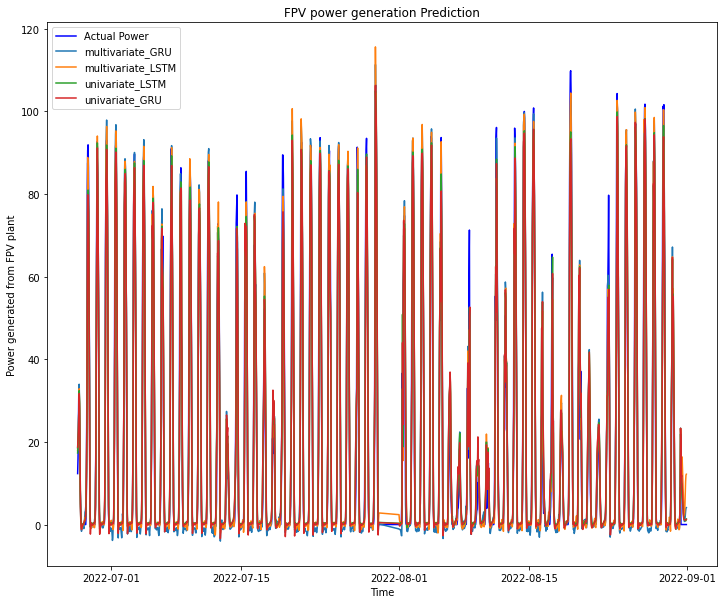

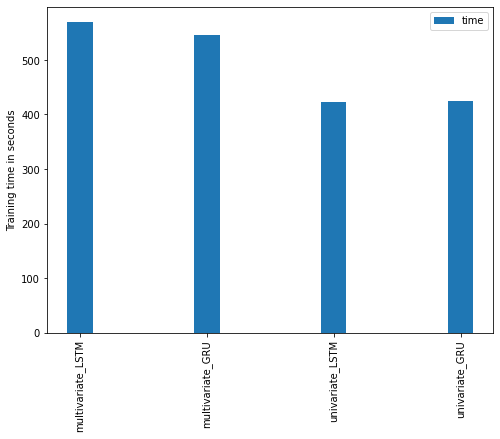

In [35]:
# without  iceemdan lstm gru

test_y_scaled=test_y
test_y_unscaled = scaler_pred.inverse_transform(test_y_scaled.reshape(-1,1))

name='multivariate_GRU'
df_total_multi=df_total
df_multi, scaler_multi, dff=normalize(df_total_multi)
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_multi,minute) 
test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2]))

y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)

name='multivariate_LSTM'
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
nl = '\n'

name='univariate_GRU'
df_total_uni=df_uni
df_uni, scaler_uni, dff=normalize(df_total_uni)
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_uni,minute) 
test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)

name='univariate_LSTM'
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)


print(f"RMSE: {RMSE}")

print(f"MAE:{MAE}")

print(f"sMAPE: {sMAPE}")

print(f"MAAPE:{MAAPE}")

print(f"R2 score:{R2}")

print(f"rmse_scaled:{RMSE_scaled}")


print(f"Total runtime for {'multivariate_GRU'}: {hms_string(training_time_took['multivariate_GRU'])}")
print(f"Total runtime for {'multivariate_LSTM'}: {hms_string(training_time_took['multivariate_LSTM'])}")



print(f"Total runtime for {'univariate_GRU'}: {hms_string(training_time_took['univariate_GRU'])}")
print(f"Total runtime for {'univariate_LSTM'}: {hms_string(training_time_took['univariate_LSTM'])}")

#sd=pd.DataFrame(y_pred_scaled['univariate_GRU'].reshape(-1,1), columns = ['Column_A'])
#sd

# without multivariate iccemdan gru all
#y_test_unscaled = scaler_pred.inverse_transform(test_y.reshape(-1, 1))
plt.figure(figsize=(12,10))
testing_figure=test_dates[sw_width:-n_out]


plt.plot(test_dates[sw_width:-n_out],test_y_unscaled, color='blue', label='Actual Power')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_GRU'],label='multivariate_GRU')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_LSTM'],label='multivariate_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_LSTM'],label='univariate_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_GRU'],label='univariate_GRU')




plt.title('FPV power generation Prediction')
plt.xlabel('Time')
plt.ylabel('Power generated from FPV plant')
plt.legend()
plt.show()

width = 0.2
x = np.arange(len(training_time_took))
Training_time=[v for v in training_time_took.values()]
plt.ylabel('Training time in seconds')
plt.bar(x , Training_time, width, label='time')
plt.xticks(ticks=x, labels=training_time_took.keys(),
            rotation=90)
_ = plt.legend()




In [ ]:
RMSE: {'multivariate_GRU': 7.535837452561398, 'multivariate_LSTM': 7.808207132372808, 'univariate_GRU': 8.98581723826577, 'univariate_LSTM': 7.927687076723164}
MAE:{'multivariate_GRU': 3.9644045190191335, 'multivariate_LSTM': 4.153372352279312, 'univariate_GRU': 5.165483704412393, 'univariate_LSTM': 4.3263089604659495}
sMAPE: {'multivariate_GRU': 104.07943620357337, 'multivariate_LSTM': 113.03749102778352, 'univariate_GRU': 99.20873443493893, 'univariate_LSTM': 104.3344077936464}
MAAPE:{'multivariate_GRU': 0.8497574731293446, 'multivariate_LSTM': 0.8808508039504338, 'univariate_GRU': 0.8434558091471724, 'univariate_LSTM': 0.8662430105150454}
R2 score:{'multivariate_GRU': 0.9281057773142227, 'multivariate_LSTM': 0.910863824452327, 'univariate_GRU': 0.9170160126874061, 'univariate_LSTM': 0.9213941787980274}
rmse_scaled:{'multivariate_GRU': 0.06780329818994289, 'multivariate_LSTM': 0.07025392936832224, 'univariate_GRU': 0.08084941399388532, 'univariate_LSTM': 0.07132894409151379}
Total runtime for multivariate_GRU: 0:04:23.37
Total runtime for multivariate_LSTM: 0:04:44.09
Total runtime for univariate_GRU: 0:03:37.58
Total runtime for univariate_LSTM: 0:03:29.05

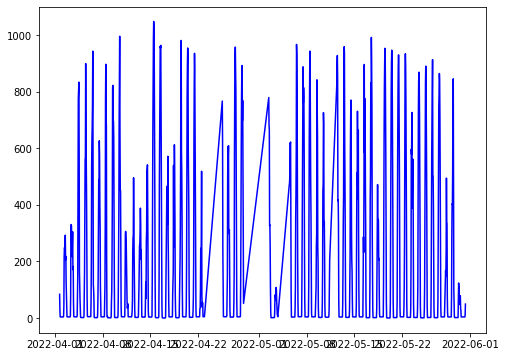

In [ ]:
test_dates[sw_width:-n_out].shape
#test_y_unscaled.shape
plt.plot(test_dates[sw_width:-n_out],test_y_unscaled, color='blue', label='Actual Power')

In [ ]:
plt.plot(np.arange(0, len(y_train)), train_y, 'g', label="history")
plt.plot(np.arange(len(y_train), len(val_y) + len(test_y_unscaled)), test_y_unscaled, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(val_y) + len(test_y_unscaled)), y_pred_unscaled['multivariate_GRU'], 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

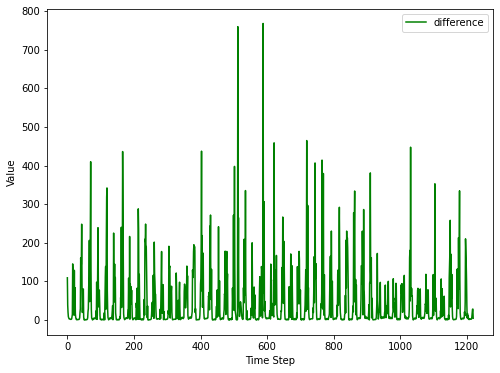

In [ ]:
#plt.plot(test_y_unscaled, marker='.', label="true")
#plt.plot(y_pred_unscaled['multivariate_GRU'], 'r', label="prediction")
plt.plot(abs(test_y_unscaled-y_pred_unscaled['multivariate_GRU']), 'g', label="difference")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

## only plot

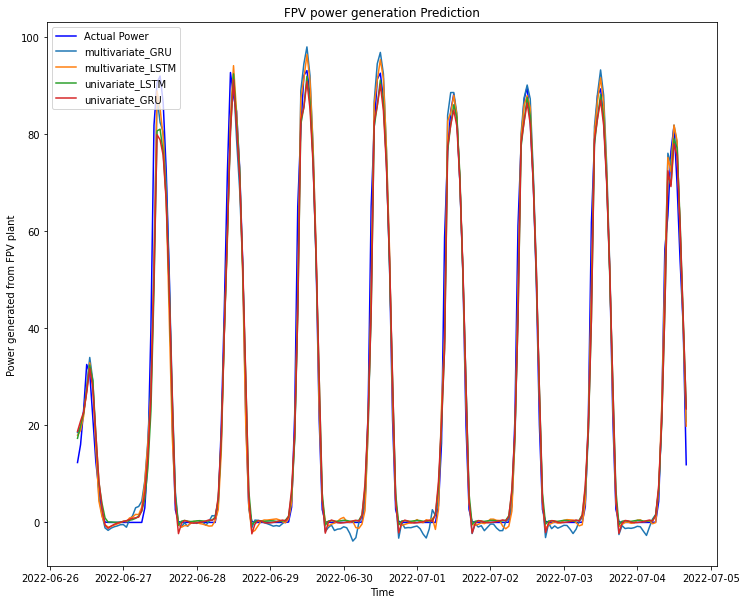

In [36]:
plt.figure(figsize=(12,10))
#testing_figure=test_dates[sw_width:-20*n_out+1]


plt.plot(test_dates[0:200],test_y_unscaled[0:200], color='blue', label='Actual Power')

plt.plot(test_dates[0:200],y_pred_unscaled['multivariate_GRU'][0:200],label='multivariate_GRU')

plt.plot(test_dates[0:200],y_pred_unscaled['multivariate_LSTM'][0:200],label='multivariate_LSTM')
plt.plot(test_dates[0:200],y_pred_unscaled['univariate_LSTM'][0:200],label='univariate_LSTM')
plt.plot(test_dates[0:200],y_pred_unscaled['univariate_GRU'][0:200],label='univariate_GRU')




plt.title('FPV power generation Prediction')
plt.xlabel('Time')
plt.ylabel('Power generated from FPV plant')
plt.legend()
plt.show()

[9.66601652e+01 3.24118324e+01 1.16374611e+03 1.18234914e+03
 1.04293331e+01 3.53345826e+02 3.03208771e+01 7.88858403e+02
 3.06671244e+05 2.00000000e+00 1.11142639e+02]
[1.]
RMSE: {'multivariate_GRU': 9.545517459025634, 'multivariate_LSTM': 10.195798201190094, 'univariate_GRU': 9.698248676313487, 'univariate_LSTM': 9.570372291777415}
MAE:{'multivariate_GRU': 4.995529575695146, 'multivariate_LSTM': 5.573690356428561, 'univariate_GRU': 5.140194861959567, 'univariate_LSTM': 5.180533999479437}
sMAPE: {'multivariate_GRU': 109.108165364251, 'multivariate_LSTM': 111.82339960985642, 'univariate_GRU': 107.74222871690696, 'univariate_LSTM': 109.38465352689627}
MAAPE:{'multivariate_GRU': 0.8784362191048132, 'multivariate_LSTM': 0.9186973282335805, 'univariate_GRU': 0.8789630789319177, 'univariate_LSTM': 0.8982919928843554}
R2 score:{'multivariate_GRU': 0.9022726832326196, 'multivariate_LSTM': 0.8774424054629903, 'univariate_GRU': 0.8859064184541001, 'univariate_LSTM': 0.900297297215246}
rmse_scal

ValueError: ignored

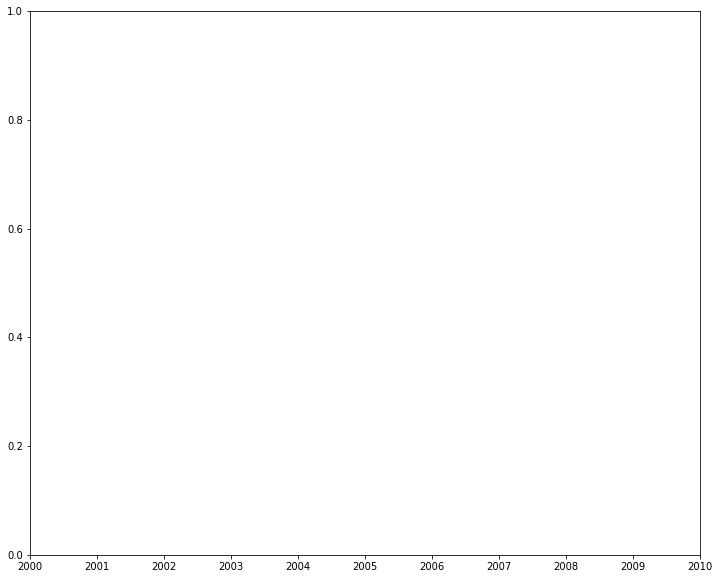

In [ ]:
# without  iceemdan lstm gru

name='multivariate_GRU'
df_total_multi=df_total
df_multi, scaler_multi, dff=normalize(df_total_multi)
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_multi,minute) 
test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2]))

val_x, val_y = sliding_window(val, sw_width=sw_width,n_out=n_out, 
                              in_start=0, increment=n_out,target_num=target_num)

val_x = val_x.reshape((val_x.shape[0], val_x.shape[1], val_x.shape[2])) 
val_y = val_y.reshape((val_y.shape[0], val_y.shape[1]))

test_y_scaled=val_y 
test_y_unscaled = scaler_pred.inverse_transform(test_y_scaled.reshape(-1,1))

y_pred_scaled[name] = model[name].predict(val_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)

name='multivariate_LSTM'
y_pred_scaled[name] = model[name].predict(val_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
nl = '\n'

name='univariate_GRU'
df_total_uni=df_uni
df_uni, scaler_uni, dff=normalize(df_total_uni)
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_uni,minute) 
test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2]))

val_x, val_y = sliding_window(val, sw_width=sw_width,n_out=n_out, 
                              in_start=0, increment=n_out,target_num=target_num)

val_x = val_x.reshape((val_x.shape[0], val_x.shape[1], val_x.shape[2])) 


y_pred_scaled[name] = model[name].predict(val_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)

name='univariate_LSTM'
y_pred_scaled[name] = model[name].predict(val_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)


print(f"RMSE: {RMSE}")

print(f"MAE:{MAE}")

print(f"sMAPE: {sMAPE}")

print(f"MAAPE:{MAAPE}")

print(f"R2 score:{R2}")

print(f"rmse_scaled:{RMSE_scaled}")


print(f"Total runtime for {'multivariate_GRU'}: {hms_string(training_time_took['multivariate_GRU'])}")
print(f"Total runtime for {'multivariate_LSTM'}: {hms_string(training_time_took['multivariate_LSTM'])}")



print(f"Total runtime for {'univariate_GRU'}: {hms_string(training_time_took['univariate_GRU'])}")
print(f"Total runtime for {'univariate_LSTM'}: {hms_string(training_time_took['univariate_LSTM'])}")

#sd=pd.DataFrame(y_pred_scaled['univariate_GRU'].reshape(-1,1), columns = ['Column_A'])
#sd

# without multivariate iccemdan gru all
#y_test_unscaled = scaler_pred.inverse_transform(test_y.reshape(-1, 1))
plt.figure(figsize=(12,10))
testing_figure=test_dates[sw_width:-n_out]


plt.plot(val_dates[sw_width:-n_out+1],test_y_unscaled, color='blue', label='Actual Power')
plt.plot(val_dates[sw_width:-n_out+1],y_pred_unscaled['multivariate_LSTM'],label='multivariate_LSTM')
plt.plot(val_dates[sw_width:-n_out+1],y_pred_unscaled['multivariate_GRU'],label='multivariate_GRU')
plt.plot(val_dates[sw_width:-n_out+1],y_pred_unscaled['univariate_LSTM'],label='univariate_LSTM')
plt.plot(val_dates[sw_width:-n_out+1],y_pred_unscaled['univariate_GRU'],label='univariate_GRU')



plt.title('FPV power generation Prediction')
plt.xlabel('Time')
plt.ylabel('Power generated from FPV plant')
plt.legend()
plt.show()

width = 0.2
x = np.arange(len(training_time_took))
Training_time=[v for v in training_time_took.values()]
plt.ylabel('Training time in seconds')
plt.bar(x , Training_time, width, label='time')
plt.xticks(ticks=x, labels=training_time_took.keys(),
            rotation=90)
_ = plt.legend()




# save as csv file for MATLAB CEEMDAN

In [ ]:

from numpy import asarray
from numpy import savetxt
 
df_total_multi=copy.deepcopy(df_total)
#df_multi, scaler_multi_ICEEMDAN, dff=normalize(df_total_multi)


#savetxt('df_total.csv', df_total, delimiter=',')
#df_total_multi.to_csv('/content/drive/MyDrive/forecasting_data2/df_data_save_nov22/df_total_v24_nov1_22_15min_24h_10var.csv')
#df_total_for_matlab_v24_nov1_22_60min_24h_9var

#savetxt('df_total.csv', df_total, delimiter=',')
df_total_multi.to_csv('/content/drive/MyDrive/forecasting_data2/df_data_save_nov22/df_total_for_matlab_v25_nov1_20_aug20_60min_24h_9var.csv')

In [ ]:

from numpy import asarray
from numpy import savetxt
 
df_total_multi=copy.deepcopy(df_total)
#df_multi, scaler_multi_ICEEMDAN, dff=normalize(df_total_multi)


#savetxt('df_total.csv', df_total, delimiter=',')
df_total_multi.to_csv('/content/drive/MyDrive/forecasting_data2/df_data_save_nov22/df_total_v24_nov1_22_15min_24h_10var.csv')

NameError: ignored

# DM_test

In [ ]:
#https://stackoverflow.com/questions/20186344/ipynb-import-another-ipynb-file
#https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab
#/content/drive/MyDrive/forecasting_data2
#https://github.com/johntwk/Diebold-Mariano-Test/blob/master/dm_test.py


py_file_location = "/content/drive/MyDrive/forecasting_data2"
sys.path.append(os.path.abspath(py_file_location))

import DM_test

from DM_test import dm_test
#from ipynb.fs.full.DM_test import *
#import import_ipynb
#import DM_test

# Timestamp

In [ ]:
df_total_multi=df_total
df_multi, scaler_multi_ICEEMDAN, dff=normalize(df_total_multi)

[  96.41999817   30.71799965 1272.36211753    8.34999975  355.30665689
  100.          558.2507018     2.          111.10715713]


# ICEEMDAN imfs

In [ ]:
#######
#    MULtivariate ICEEMDAN GRU LSTM

#df_total_multi=df_total
#df_multi, scaler_multi_ICEEMDAN, dff=normalize(df_total_multi)




# Extract imfs and residue
# In case of EMD
#emd = EMD(DTYPE=np.float16)
#eemd = EEMD(spline_kind='akima')
#emd = EMD()
#emd.emd(S)
#imfs, res = emd.get_imfs_and_residue()

'''
emd1=EMD()
im=emd1.emd(cimfs0[0])
if __name__ == '__main__': 
  ICEEMDAN = ICEEMDAN(trials=20,DTYPE=np.float16,spline_kind='akima')
    if i==0:
      S=df_multi[:,i]
      ICEEMDAN.ICEEMDAN(S=S.squeeze(),T=T, max_imf=4)
      cimfs0,res0 =ICEEMDAN.get_imfs_and_residue()
Improved ICEEMDAN–wavelet transform
de-noising method and its application
in well logging noise reduction
max_imf=-1
if __name__ == '__main__':

  ceemdan= CEEMDAN(trials=200,parallel=True, noise_scale =0.4,processes=16)  #

S=df_total.iloc[:,0]
ceemdan.ceemdan(S=S.squeeze(),T=T, max_imf=max_imf)
cimfs0,cres0 =ceemdan.get_imfs_and_residue()

'''
max_imf=-1
#mimfs=[]
#emd = EMD()
#emd.MAX_ITERATION = 10000
#  ICEEMDAN = ICEEMDAN(trials=100,parallel=True,ext_EMD=
if __name__ == '__main__':

  ceemdan= CEEMDAN(trials=200,parallel=True, noise_scale =0.4,processes=16)  #
  #A ICEEMDAN-Assisted Deep Learning Model for the RUL Estimation of Solenoid Pumps
  #An ensemble value of 100 was set while the shifting iterations ranged between 15to 20 to compute one IMF
  #white Gaussian noise was set to have a maximumamplitude of 0.25
for i in range(df_multi.shape[1]):
    print(i)
    
    if i==0:
      S=df_total.iloc[:,i].values
      ceemdan.ceemdan(S=S.squeeze(),T=T, max_imf=max_imf)
      cimfs0,cres0 =ceemdan.get_imfs_and_residue()
    elif i==1:
      S=df_total.iloc[:,i].values
      ceemdan.ceemdan(S=S.squeeze(),T=T, max_imf=max_imf)
      cimfs1,cres1 =ceemdan.get_imfs_and_residue()
    elif i==2:
      S=df_total.iloc[:,i].values
      ceemdan.ceemdan(S=S.squeeze(),T=T, max_imf=max_imf)
      cimfs2,cres2 =ceemdan.get_imfs_and_residue()
    elif i==3:
      S=df_total.iloc[:,i].values
      ceemdan.ceemdan(S=S.squeeze(),T=T, max_imf=max_imf)
      cimfs3,cres3=ceemdan.get_imfs_and_residue()
    elif i==4:
      S=df_total.iloc[:,i].values
      ceemdan(S=S.squeeze(),T=T, max_imf=max_imf)
      cimfs4,cres4 =ceemdan.get_imfs_and_residue()
    elif i==5:
      S=df_total.iloc[:,i].values
      ceemdan.ceemdan(S=S.squeeze(),T=T, max_imf=max_imf)
      cimfs5,cres5 =ceemdan.get_imfs_and_residue()
    elif i==6:
      S=df_total.iloc[:,i].values
      ceemdan.ceemdan(S=S.squeeze(),T=T, max_imf=max_imf)
      cimfs6,cres6 =ceemdan.get_imfs_and_residue()  ## inverter power
    elif i==7:
      S=df_total.iloc[:,i].values
      ceemdan.ceemdan(S=S.squeeze(),T=T, max_imf=max_imf)
      cimfs7,cres7 =ceemdan.get_imfs_and_residue()
    elif i==8:
      S=df_total.iloc[:,i].values
      ceemdan.ceemdan(S=S.squeeze(),T=T, max_imf=max_imf)
      cimfs8,cres8 =ceemdan.get_imfs_and_residue()
    elif i==9:
      S=df_total.iloc[:,i].values
      ceemdan.ceemdan(S=S.squeeze(),T=T, max_imf=max_imf)
      cimfs9,cres9 =ceemdan.get_imfs_and_residue()
    elif i==10:
      S=df_total.iloc[:,i].values
      ceemdan.ceemdan(S=S.squeeze(),T=T, max_imf=max_imf)
      cimfs10,cres10 =ceemdan.get_imfs_and_residue()


'''
for i in np.arange(10):
    print(i)
    mimfs =np.arange(10) 
    print(mimfs)
dtto=[imfs[1,:] imfs[2,:]]
for i in np.arange(10):
    print(i)
    if i==0:
      mimfs0 =np.arange(3) 
      print(mimfs0)
    elif i==1:
      mimfs1 =np.arange(4) 
      print(mimfs1)
    elif i==2:
      mimfs2 =np.arange(5) 
      print(mimfs2)
    else:
      mimfs3 =np.arange(6) 
      print(mimfs3)
'''

# reading cimfs mat file

In [ ]:
# power as kW
#/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw
## for 60 min resolution
## cimfs 7 is the clearness index so is not used later but here read
import scipy.io as sio
mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs0.mat')
cimfs0= mat_contents['cimfs0']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs1.mat')
cimfs1= mat_contents['cimfs1']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs2.mat')
cimfs2= mat_contents['cimfs2']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs3.mat')
cimfs3= mat_contents['cimfs3']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs4.mat')
cimfs4= mat_contents['cimfs4']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs5.mat')
cimfs5= mat_contents['cimfs5']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs6.mat')
cimfs6= mat_contents['cimfs6']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs7.mat')
cimfs7= mat_contents['cimfs7']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs8.mat')
cimfs8= mat_contents['cimfs8']

#mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs9.mat')
#cimfs9= mat_contents['cimfs9']





In [ ]:
cimfs0.shape

(14, 15892)

In [ ]:
#/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15min

import scipy.io as sio
mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15min/cimfs0.mat')
cimfs0= mat_contents['cimfs0']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15min/cimfs1.mat')
cimfs1= mat_contents['cimfs1']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15min/cimfs2.mat')
cimfs2= mat_contents['cimfs2']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15min/cimfs3.mat')
cimfs3= mat_contents['cimfs3']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15min/cimfs4.mat')
cimfs4= mat_contents['cimfs4']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15min/cimfs5.mat')
cimfs5= mat_contents['cimfs5']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15min/cimfs6.mat')
cimfs6= mat_contents['cimfs6']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15min/cimfs7.mat')
cimfs7= mat_contents['cimfs7']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15min/cimfs8.mat')
cimfs8= mat_contents['cimfs8']







# Savings imf to drive-15 min resolution

In [ ]:
#### save in the drive

### using df_total to make it and after we normalize in the function later
## from matlab
#/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min
dump(cimfs0, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs0.pkl', 'wb'))
#dump(cres0, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres0.pkl', 'wb'))
dump(cimfs1, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs1.pkl', 'wb'))
#dump(cres1, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres1.pkl', 'wb'))
dump(cimfs2, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs2.pkl', 'wb'))
#dump(cres2, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres2.pkl', 'wb'))
dump(cimfs3, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs3.pkl', 'wb'))
#dump(cres3, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres3.pkl', 'wb'))
dump(cimfs4, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs4.pkl', 'wb'))
#dump(cres4, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres4.pkl', 'wb'))
dump(cimfs5, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs5.pkl', 'wb'))
#dump(cres5, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres5.pkl', 'wb'))
dump(cimfs6, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs6.pkl', 'wb'))
#dump(cres6, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres6.pkl', 'wb'))
dump(cimfs7, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs7.pkl', 'wb'))
#dump(cres7, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres7.pkl', 'wb'))
dump(cimfs8, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs8.pkl', 'wb'))
#dump(cres8, open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres8.pkl', 'wb'))

In [ ]:
#### save in the drive all imf
#/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug
dump(cimfs0, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs0.pkl', 'wb'))
dump(cres0, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres0.pkl', 'wb'))
dump(cimfs1, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs1.pkl', 'wb'))
dump(cres1, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres1.pkl', 'wb'))
dump(cimfs2, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs2.pkl', 'wb'))
dump(cres2, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres2.pkl', 'wb'))
dump(cimfs3, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs3.pkl', 'wb'))
dump(cres3, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres3.pkl', 'wb'))
dump(cimfs4, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs4.pkl', 'wb'))
dump(cres4, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres4.pkl', 'wb'))
dump(cimfs5, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs5.pkl', 'wb'))
dump(cres5, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres5.pkl', 'wb'))
dump(cimfs6, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs6.pkl', 'wb'))
dump(cres6, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres6.pkl', 'wb'))
dump(cimfs7, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs7.pkl', 'wb'))
dump(cres7, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres7.pkl', 'wb'))
dump(cimfs8, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs8.pkl', 'wb'))
dump(cres8, open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres8.pkl', 'wb'))

In [ ]:
#### save in the drive
#/content/drive/MyDrive/forecasting_data2/15minresolution/
dump(cimfs0, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs0.pkl', 'wb'))
dump(cres0, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres0.pkl', 'wb'))
dump(cimfs1, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs1.pkl', 'wb'))
dump(cres1, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres1.pkl', 'wb'))
dump(cimfs2, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs2.pkl', 'wb'))
dump(cres2, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres2.pkl', 'wb'))
dump(cimfs3, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs3.pkl', 'wb'))
dump(cres3, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres3.pkl', 'wb'))
dump(cimfs4, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs4.pkl', 'wb'))
dump(cres4, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres4.pkl', 'wb'))
dump(cimfs5, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs5.pkl', 'wb'))
dump(cres5, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres5.pkl', 'wb'))
dump(cimfs6, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs6.pkl', 'wb'))
dump(cres6, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres6.pkl', 'wb'))
dump(cimfs7, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs7.pkl', 'wb'))
dump(cres7, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres7.pkl', 'wb'))
dump(cimfs8, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs8.pkl', 'wb'))
dump(cres8, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres8.pkl', 'wb'))

# saving imf in drive-5 min resolution

In [ ]:
#### save in the drive
#/content/drive/MyDrive/forecasting_data2/5minresolution/
dump(cimfs0, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs0.pkl', 'wb'))
dump(cres0, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres0.pkl', 'wb'))
dump(cimfs1, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs1.pkl', 'wb'))
dump(cres1, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres1.pkl', 'wb'))
dump(cimfs2, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs2.pkl', 'wb'))
dump(cres2, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres2.pkl', 'wb'))
dump(cimfs3, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs3.pkl', 'wb'))
dump(cres3, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres3.pkl', 'wb'))
dump(cimfs4, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs4.pkl', 'wb'))
dump(cres4, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres4.pkl', 'wb'))
dump(cimfs5, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs5.pkl', 'wb'))
dump(cres5, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres5.pkl', 'wb'))
dump(cimfs6, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs6.pkl', 'wb'))
dump(cres6, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres6.pkl', 'wb'))
dump(cimfs7, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs7.pkl', 'wb'))
dump(cres7, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres7.pkl', 'wb'))
dump(cimfs8, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs8.pkl', 'wb'))
dump(cres8, open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres8.pkl', 'wb'))

# utilize imf data from drive if not trained 

In [ ]:
df_multi.shape


#all_imf_before_normalize_15min

## first imf then need to normalize in the fucntion
## Jan-aug data
##  15 min resolution
## all imf
#/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min


with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs0.pkl', 'rb') as f:
  cimfs0 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs1.pkl', 'rb') as f:
  cimfs1 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs2.pkl', 'rb') as f:
  cimfs2 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs3.pkl', 'rb') as f:
  cimfs3 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs4.pkl', 'rb') as f:
  cimfs4 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs5.pkl', 'rb') as f:
  cimfs5 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs6.pkl', 'rb') as f:
  cimfs6 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs7.pkl', 'rb') as f:
  cimfs7 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cimfs8.pkl', 'rb') as f:
  cimfs8 = load(f)

with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres0.pkl', 'rb') as f:
  cres0 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres1.pkl', 'rb') as f:
  cres1 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres2.pkl', 'rb') as f:
  cres2 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres3.pkl', 'rb') as f:
  cres3 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres4.pkl', 'rb') as f:
  cres4 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres5.pkl', 'rb') as f:
  cres5 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres6.pkl', 'rb') as f:
  cres6 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres7.pkl', 'rb') as f:
  cres7 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_before_normalize_15min/cres8.pkl', 'rb') as f:
  cres8 = load(f)

(11421, 9)

In [ ]:
## Jan-aug data

##  15 min resolution


## only all imf
## for 6:30AM to 6PM data
##/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug

with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs0.pkl', 'rb') as f:
  cimfs0 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs1.pkl', 'rb') as f:
  cimfs1 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs2.pkl', 'rb') as f:
  cimfs2 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs3.pkl', 'rb') as f:
  cimfs3 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs4.pkl', 'rb') as f:
  cimfs4 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs5.pkl', 'rb') as f:
  cimfs5 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs6.pkl', 'rb') as f:
  cimfs6 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs7.pkl', 'rb') as f:
  cimfs7 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cimfs8.pkl', 'rb') as f:
  cimfs8 = load(f)

with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres0.pkl', 'rb') as f:
  cres0 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres1.pkl', 'rb') as f:
  cres1 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres2.pkl', 'rb') as f:
  cres2 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres3.pkl', 'rb') as f:
  cres3 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres4.pkl', 'rb') as f:
  cres4 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres5.pkl', 'rb') as f:
  cres5 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres6.pkl', 'rb') as f:
  cres6 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres7.pkl', 'rb') as f:
  cres7 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/all_imf_0_remove_15min_jan_aug/cres8.pkl', 'rb') as f:
  cres8 = load(f)

In [ ]:
## Jan-aug data

##  15 min resolution


## only 5 imf
#/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug



with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cimfs0.pkl', 'rb') as f:
  cimfs0 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cimfs1.pkl', 'rb') as f:
  cimfs1 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cimfs2.pkl', 'rb') as f:
  cimfs2 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cimfs3.pkl', 'rb') as f:
  cimfs3 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cimfs4.pkl', 'rb') as f:
  cimfs4 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cimfs5.pkl', 'rb') as f:
  cimfs5 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cimfs6.pkl', 'rb') as f:
  cimfs6 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cimfs7.pkl', 'rb') as f:
  cimfs7 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cimfs8.pkl', 'rb') as f:
  cimfs8 = load(f)

with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cres0.pkl', 'rb') as f:
  cres0 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cres1.pkl', 'rb') as f:
  cres1 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cres2.pkl', 'rb') as f:
  cres2 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cres3.pkl', 'rb') as f:
  cres3 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cres4.pkl', 'rb') as f:
  cres4 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cres5.pkl', 'rb') as f:
  cres5 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cres6.pkl', 'rb') as f:
  cres6 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cres7.pkl', 'rb') as f:
  cres7 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5imf_15min_jan_aug/cres8.pkl', 'rb') as f:
  cres8 = load(f)

In [ ]:
## Jan-aug data

##  15 min resolution


## only 9 imf
#/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug



with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cimfs0.pkl', 'rb') as f:
  cimfs0 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cimfs1.pkl', 'rb') as f:
  cimfs1 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cimfs2.pkl', 'rb') as f:
  cimfs2 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cimfs3.pkl', 'rb') as f:
  cimfs3 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cimfs4.pkl', 'rb') as f:
  cimfs4 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cimfs5.pkl', 'rb') as f:
  cimfs5 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cimfs6.pkl', 'rb') as f:
  cimfs6 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cimfs7.pkl', 'rb') as f:
  cimfs7 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cimfs8.pkl', 'rb') as f:
  cimfs8 = load(f)

with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cres0.pkl', 'rb') as f:
  cres0 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cres1.pkl', 'rb') as f:
  cres1 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cres2.pkl', 'rb') as f:
  cres2 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cres3.pkl', 'rb') as f:
  cres3 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cres4.pkl', 'rb') as f:
  cres4 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cres5.pkl', 'rb') as f:
  cres5 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cres6.pkl', 'rb') as f:
  cres6 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cres7.pkl', 'rb') as f:
  cres7 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/9imf_15min_jan_aug/cres8.pkl', 'rb') as f:
  cres8 = load(f)

In [ ]:
## Jan-aug data

##  15 min resolution

## all imf

#/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug


with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cimfs0.pkl', 'rb') as f:
  cimfs0 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cimfs1.pkl', 'rb') as f:
  cimfs1 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cimfs2.pkl', 'rb') as f:
  cimfs2 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cimfs3.pkl', 'rb') as f:
  cimfs3 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cimfs4.pkl', 'rb') as f:
  cimfs4 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cimfs5.pkl', 'rb') as f:
  cimfs5 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cimfs6.pkl', 'rb') as f:
  cimfs6 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cimfs7.pkl', 'rb') as f:
  cimfs7 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cimfs8.pkl', 'rb') as f:
  cimfs8 = load(f)

with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cres0.pkl', 'rb') as f:
  cres0 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cres1.pkl', 'rb') as f:
  cres1 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cres2.pkl', 'rb') as f:
  cres2 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cres3.pkl', 'rb') as f:
  cres3 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cres4.pkl', 'rb') as f:
  cres4 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cres5.pkl', 'rb') as f:
  cres5 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cres6.pkl', 'rb') as f:
  cres6 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cres7.pkl', 'rb') as f:
  cres7 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/imf_15min_jan_aug/cres8.pkl', 'rb') as f:
  cres8 = load(f)

In [ ]:
cimfs0[12]=cimfs0[12]+cimfs0[13]+cimfs0[14]
cimfs1[12]=cimfs1[12]+cimfs1[13]
cimfs2[12]=cimfs2[12]+cimfs2[13]
cimfs3[12]=cimfs3[12]+cimfs3[13]
cimfs4[12]=cimfs4[12]+cimfs4[13]
cimfs5[12]=cimfs5[12]
cimfs6[12]=cimfs6[12]+cimfs6[13]
cimfs7[12]=cimfs7[12]+cimfs7[13]
cimfs8[12]=cimfs8[12]+cimfs8[13]

In [ ]:
cimfs0=cimfs0[0:13,:]
cimfs1=cimfs1[0:13,:]
cimfs2=cimfs2[0:13,:]
cimfs3=cimfs3[0:13,:]
cimfs4=cimfs4[0:13,:]
cimfs5=cimfs5[0:13,:]
cimfs6=cimfs6[0:13,:]
cimfs7=cimfs7[0:13,:]
cimfs8=cimfs8[0:13,:]

In [ ]:
x = 120
result = 10 + (10 if x > 100 else 0)
print(result)

20


In [ ]:
#c12=cimfs3[12]+cimfs3[13] if cimfs3[13] else None+cimfs3[14]if cimfs3[14] else None
#c12=cimfs3[14] if cimfs3.shape[0]>12  else 0
#c12
#if cimfs3[14]:  
# c12=1
#else: 
#  0
#if cimfs1[13]

IndexError: ignored

In [ ]:
#### 5 min resolution



#/content/drive/MyDrive/forecasting_data2/5minresolution
with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs0.pkl', 'rb') as f:
  cimfs0 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs1.pkl', 'rb') as f:
  cimfs1 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs2.pkl', 'rb') as f:
  cimfs2 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs3.pkl', 'rb') as f:
  cimfs3 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs4.pkl', 'rb') as f:
  cimfs4 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs5.pkl', 'rb') as f:
  cimfs5 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs6.pkl', 'rb') as f:
  cimfs6 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs7.pkl', 'rb') as f:
  cimfs7 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cimfs8.pkl', 'rb') as f:
  cimfs8 = load(f)

with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres0.pkl', 'rb') as f:
  cres0 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres1.pkl', 'rb') as f:
  cres1 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres2.pkl', 'rb') as f:
  cres2 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres3.pkl', 'rb') as f:
  cres3 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres4.pkl', 'rb') as f:
  cres4 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres5.pkl', 'rb') as f:
  cres5 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres6.pkl', 'rb') as f:
  cres6 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres7.pkl', 'rb') as f:
  cres7 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/5minresolution/cres8.pkl', 'rb') as f:
  cres8 = load(f)

In [ ]:
##  15 min resolution



#/content/drive/MyDrive/forecasting_data2/15minresolution
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs0.pkl', 'rb') as f:
  cimfs0 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs1.pkl', 'rb') as f:
  cimfs1 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs2.pkl', 'rb') as f:
  cimfs2 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs3.pkl', 'rb') as f:
  cimfs3 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs4.pkl', 'rb') as f:
  cimfs4 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs5.pkl', 'rb') as f:
  cimfs5 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs6.pkl', 'rb') as f:
  cimfs6 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs7.pkl', 'rb') as f:
  cimfs7 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs8.pkl', 'rb') as f:
  cimfs8 = load(f)

with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres0.pkl', 'rb') as f:
  cres0 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres1.pkl', 'rb') as f:
  cres1 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres2.pkl', 'rb') as f:
  cres2 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres3.pkl', 'rb') as f:
  cres3 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres4.pkl', 'rb') as f:
  cres4 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres5.pkl', 'rb') as f:
  cres5 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres6.pkl', 'rb') as f:
  cres6 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres7.pkl', 'rb') as f:
  cres7 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres8.pkl', 'rb') as f:
  cres8 = load(f)

In [ ]:
#### save in the drive
#/content/drive/MyDrive/forecasting_data2/15minresolution/
dump(cimfs0, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs0.pkl', 'wb'))
dump(cres0, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres0.pkl', 'wb'))
dump(cimfs1, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs1.pkl', 'wb'))
dump(cres1, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres1.pkl', 'wb'))
dump(cimfs2, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs2.pkl', 'wb'))
dump(cres2, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres2.pkl', 'wb'))
dump(cimfs3, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs3.pkl', 'wb'))
dump(cres3, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres3.pkl', 'wb'))
dump(cimfs4, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs4.pkl', 'wb'))
dump(cres4, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres4.pkl', 'wb'))
dump(cimfs5, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs5.pkl', 'wb'))
dump(cres5, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres5.pkl', 'wb'))
dump(cimfs6, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs6.pkl', 'wb'))
dump(cres6, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres6.pkl', 'wb'))
dump(cimfs7, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs7.pkl', 'wb'))
dump(cres7, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres7.pkl', 'wb'))
dump(cimfs8, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs8.pkl', 'wb'))
dump(cres8, open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres8.pkl', 'wb'))

In [ ]:
#/content/drive/MyDrive/forecasting_data2/15minresolution
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs0.pkl', 'rb') as f:
  cimfs0 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs1.pkl', 'rb') as f:
  cimfs1 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs2.pkl', 'rb') as f:
  cimfs2 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs3.pkl', 'rb') as f:
  cimfs3 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs4.pkl', 'rb') as f:
  cimfs4 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs5.pkl', 'rb') as f:
  cimfs5 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs6.pkl', 'rb') as f:
  cimfs6 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs7.pkl', 'rb') as f:
  cimfs7 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cimfs8.pkl', 'rb') as f:
  cimfs8 = load(f)

with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres0.pkl', 'rb') as f:
  cres0 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres1.pkl', 'rb') as f:
  cres1 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres2.pkl', 'rb') as f:
  cres2 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres3.pkl', 'rb') as f:
  cres3 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres4.pkl', 'rb') as f:
  cres4 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres5.pkl', 'rb') as f:
  cres5 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres6.pkl', 'rb') as f:
  cres6 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres7.pkl', 'rb') as f:
  cres7 = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15minresolution/cres8.pkl', 'rb') as f:
  cres8 = load(f)

# Plot of imfs

In [ ]:
S= cimfs8
res=cres8
vis = Visualisation()
vis.plot_imfs(imfs=S,residue=res, t=T, include_residue=True)
vis.plot_instant_freq(T, imfs=S)
vis.show()



imfNo  = cimfs8.shape[0]
# Plot results in a grid
c = np.floor(np.sqrt(imfNo+2))
r = np.ceil((imfNo+2)/c)
tMin, tMax = 0, 2*np.pi
plt.ioff()
plt.subplot(r, c, 1)
plt.plot(T, df_multi[:,8], 'r')
#plt.xlim((tMin, tMax))
plt.title("Original signal")

plt.subplot(r, c, 2)
plt.plot(T, df_multi[:,8]-np.sum(S, axis=0), 'r')
#plt.xlim((tMin, tMax))
plt.title("Residual")

for num in range(imfNo):
        plt.subplot(r, c, num+3)
        plt.plot(T, S[num],'g')
        #plt.xlim((tMin, tMax))
        plt.title("Imf "+str(num+1))

plt.show()

NameError: ignored

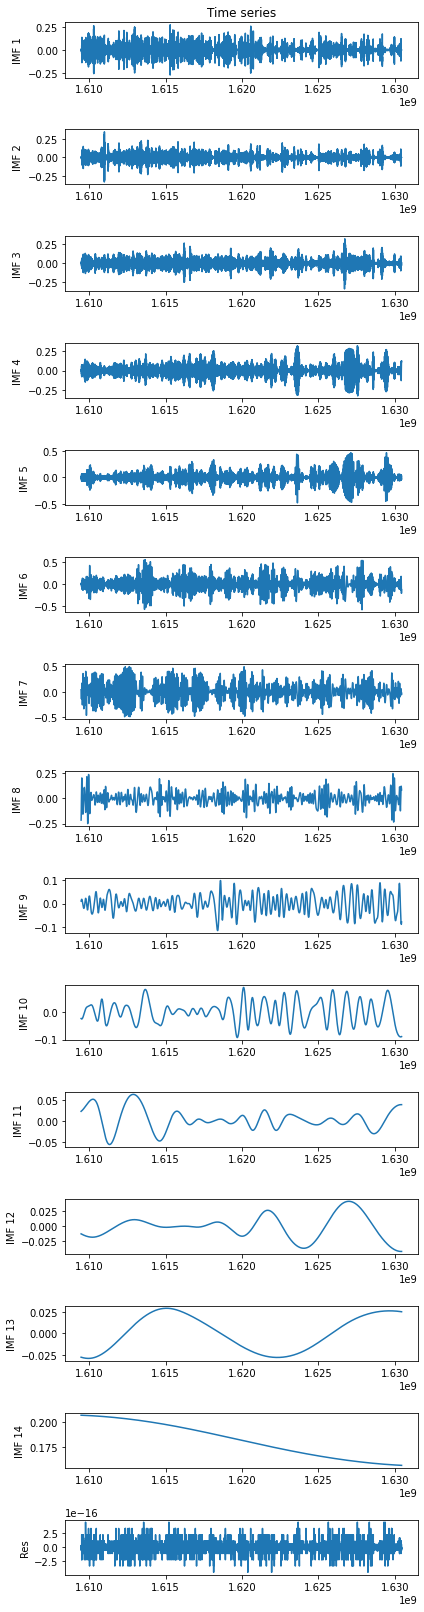

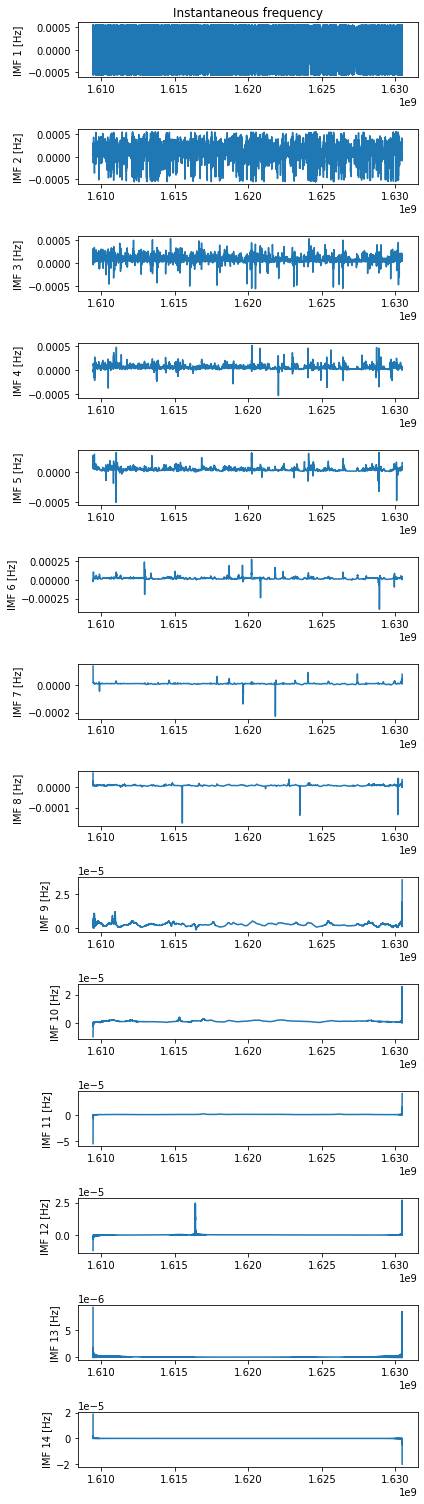

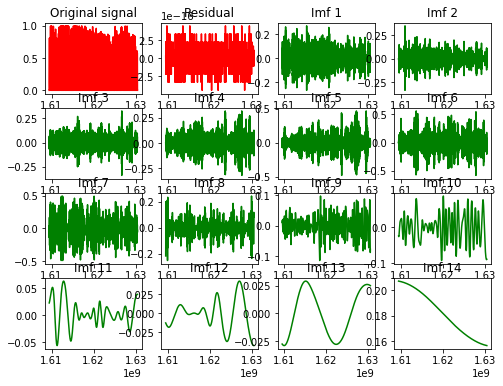

In [ ]:
S= cimfs8
res=cres8
vis = Visualisation()
vis.plot_imfs(imfs=S,residue=res, t=T, include_residue=True)
vis.plot_instant_freq(T, imfs=S)
vis.show()



imfNo  = cimfs8.shape[0]
# Plot results in a grid
c = np.floor(np.sqrt(imfNo+2))
r = np.ceil((imfNo+2)/c)
tMin, tMax = 0, 2*np.pi
plt.ioff()
plt.subplot(r, c, 1)
plt.plot(T, df_multi[:,8], 'r')
#plt.xlim((tMin, tMax))
plt.title("Original signal")

plt.subplot(r, c, 2)
plt.plot(T, df_multi[:,8]-np.sum(S, axis=0), 'r')
#plt.xlim((tMin, tMax))
plt.title("Residual")

for num in range(imfNo):
        plt.subplot(r, c, num+3)
        plt.plot(T, S[num],'g')
        #plt.xlim((tMin, tMax))
        plt.title("Imf "+str(num+1))

plt.show()

# Correlation and Series or numpy array to dataframe

In [ ]:
## convert to data frame to find out the energy

## pearson correlation

# calculate Pearson's correlation between cimfs and original data

corr0=[]
for i in np.arange(len(cimfs8)):
  corr, _ = pearsonr(df_multi[:,8], cimfs8[i])
  corr0.append(corr)
  print('Pearsons correlation: %.3f' % corr)
for i in np.arange(len(corr0)):

  if corr0[i]>=max(corr0)/((10*max(corr0))-3):
      print('Pearsons correlation: %.3f' % corr0[i])
      print(i)

#corr7, _ = pearsonr(df_multi[:,7], cimfs7[0])
#print('Pearsons correlation: %.3f' % corr7)


corrdf = pd.DataFrame(cimfs6)
corrdf=corrdf.T
corrdf['original']=df_multi[:,6]
#cr=corrdf.corr()
#plt.figure(figsize=(22,22))
#sns.heatmap(cr, annot=True, square=True);

#https://stackoverflow.com/questions/41340023/pandas-sort-column-by-correlation-to-first-column
ix = corrdf.corr().sort_values('original', ascending=False).index
df_sorted = corrdf.loc[:, ix]
df_sorted

# Not this one Multivariate ICEEMDAN LSTM GRU

In [ ]:


def convert_13_imfs(cimf):
      cimf_allnew=[]
      cimf0= cimf[0]
      cimf1=cimf[1]
      cimf2= cimf[2]
      cimf3=cimf[3]
      cimf4= cimf[4]
      cimf5=cimf[5]
      cimf6=cimf[6]
      cimf7=cimf[7]
      cimf8= cimf[8]
      cimf9=cimf[9]
      cimf10=cimf[10]
      cimf11=cimf[11]

      if cimf.shape[0]==15:
        cimf12=cimf[12]+cimf[13]+cimf[14]
      elif cimf.shape[0]==13:
        cimf12=cimf[12]
      else:
        cimf12=cimf[12]+cimf[13]
      cimf_allnew.append((cimf0,cimf1,cimf2,
                          cimf3,cimf4,cimf5,
                          cimf6,cimf7,cimf8,
                          cimf9,cimf10, cimf11,
                          cimf12))
      return np.array(cimf_allnew)

cimfs0=convert_13_imfs(cimfs0)
cimfs0=cimfs0.reshape(cimfs0.shape[1],cimfs0.shape[2])

cimfs1=convert_13_imfs(cimfs1)
cimfs1=cimfs1.reshape(cimfs1.shape[1],cimfs1.shape[2])

cimfs2=convert_13_imfs(cimfs2)
cimfs2=cimfs2.reshape(cimfs2.shape[1],cimfs2.shape[2])

cimfs3=convert_13_imfs(cimfs3)
cimfs3=cimfs3.reshape(cimfs3.shape[1],cimfs3.shape[2])

cimfs4=convert_13_imfs(cimfs4)
cimfs4=cimfs4.reshape(cimfs4.shape[1],cimfs4.shape[2])

cimfs5=convert_13_imfs(cimfs5)
cimfs5=cimfs5.reshape(cimfs5.shape[1],cimfs5.shape[2])

cimfs6=convert_13_imfs(cimfs6)
cimfs6=cimfs6.reshape(cimfs6.shape[1],cimfs6.shape[2])

cimfs7=convert_13_imfs(cimfs7)
cimfs7=cimfs7.reshape(cimfs7.shape[1],cimfs7.shape[2])

cimfs8=convert_13_imfs(cimfs8)
cimfs8=cimfs8.reshape(cimfs8.shape[1],cimfs8.shape[2])


In [ ]:

# chnaged on 11/8/22 cimfs7
#                           cimfs7[i].reshape(-1,1),    cimfs 7 is the clearness index so is not used
tf.compat.v1.reset_default_graph()



predictions_multi_LSTM=[]

start_time = time.time()
name='multivariate_ICEEMDAN_LSTM'
#for i in np.arange(len(cimfs0)):
#for i in range(2,12):
for i in np.arange(len(cimfs0)):
    print(i)
    cimfs=np.column_stack((cimfs0[i].reshape(-1,1), 
                           cimfs1[i].reshape(-1,1), 
                           cimfs2[i].reshape(-1,1), 
                           cimfs3[i].reshape(-1,1), 
                           cimfs4[i].reshape(-1,1), 
                           cimfs5[i].reshape(-1,1), 
                           cimfs6[i].reshape(-1,1),

                           cimfs8[i].reshape(-1,1)))
    #prediction_out,history,model
    predictions_multi_LSTM.append(imf_trainer_LSTM(cimfs,name))

training_time_took['multivariate_ICEEMDAN_LSTM']=time.time() - start_time 

'''
#res=cres.reshape(-1,1)
res_multi=np.column_stack((cres0.reshape(-1,1), 
                           cres1.reshape(-1,1), 
                           cres2.reshape(-1,1), 
                           cres3.reshape(-1,1), 
                           cres4.reshape(-1,1), 
                           cres5.reshape(-1,1), 
                           cres6.reshape(-1,1),
                           cres7.reshape(-1,1),
                           cres8.reshape(-1,1)))
predictions_multi_LSTM.append(imf_trainer_LSTM(res_multi,name))
'''

predictions_ICEEMDAN_multi_LSTM1=sum(predictions_multi_LSTM)


predictions_multi_GRU=[]
#time_took={}
#prediction_time_took={}
name='multivariate_ICEEMDAN_GRU'
start_time = time.time()
#for i in np.arange(len(cimfs0)):
for i in np.arange(len(cimfs0)):
    print(i)
    cimfs=np.column_stack((cimfs0[i].reshape(-1,1), 
                           cimfs1[i].reshape(-1,1), 
                           cimfs2[i].reshape(-1,1), 
                           cimfs3[i].reshape(-1,1), 
                           cimfs4[i].reshape(-1,1), 
                           cimfs5[i].reshape(-1,1), 
                           cimfs6[i].reshape(-1,1),

                           cimfs8[i].reshape(-1,1)))
    predictions_multi_GRU.append(imf_trainer_GRU(cimfs,name))

training_time_took['multivariate_ICEEMDAN_GRU']=time.time() - start_time 


#res=res.reshape(-1,1)
#predictions.append(imf_trainer(res,test,val))
#predictions_multi_GRU.append(imf_trainer_GRU(res_multi,name))
predictions_ICEEMDAN_multi_GRU2=sum(predictions_multi_GRU)

#val_performance['unm']=[0.08,0.009]


'''
for imf in len(imfs):
  print(imf)
for i in np.arange(len(cimfs0)):
  print(i)


cimfs=np.column_stack((cimfs0[0].reshape(-1,1), 
                           cimfs1[0].reshape(-1,1), 
                           cimfs2[0].reshape(-1,1), 
                           cimfs3[0].reshape(-1,1), 
                           cimfs4[0].reshape(-1,1), 
                           cimfs5[0].reshape(-1,1), 
                           cimfs6[0].reshape(-1,1),
                           cimfs7[0].reshape(-1,1),
                           cimfs8[0].reshape(-1,1)))
 
scaler_imf = MinMaxScaler()
df_total_power = pd.DataFrame(cimfs(:,-1))
df_total_power_scaled = scaler_imf.fit_transform(df_total_power)

'''


# Not this one Univariate ICEEMDAN LSTM GRU

In [ ]:
   
#val_performance['multivariate_GRU'] = model['multivariate_GRU'].evaluate(val_x, val_y, verbose=1)
#test_performance['multivariate_GRU'] =model['multivariate_GRU'].evaluate(test_x, test_y, verbose=1)
######### UNIVARIATE
tf.compat.v1.reset_default_graph()

'''
if __name__ == '__main__': 
  ICEEMDAN = ICEEMDAN(trials=20)
  imfs = ICEEMDAN(S=df.squeeze(),T=date_time, max_imf=4)
'''
imfs=cimfs8 
#res=cres8




#training_time_t={}
#prediction_time_t={}
# np.shape(testseries)
predictions_LSTM=[]
#time_took={}
#prediction_time_took={}
name='univariate_ICEEMDAN_LSTM'
start_time = time.time()
#for imf in imfs:
#    imf=imf.reshape(-1,1)

for i in np.arange(len(imfs)):
    print(i)
    imf=cimfs8[i].reshape(-1,1)
    #history['univariate_ICEEMDAN_LSTM'], model['univariate_ICEEMDAN_LSTM'], prediction['univariate_ICEEMDAN_LSTM'], training_time_t['univariate_ICEEMDAN_LSTM'], prediction_time_t['univariate_ICEEMDAN_LSTM']=imf_trainer(imf,test,val)
    predictions_LSTM.append(imf_trainer_uni_LSTM(imf, name))

training_time_took['univariate_ICEEMDAN_LSTM']=time.time() - start_time 


#res_uni=res.reshape(-1,1)
#predictions_LSTM.append(imf_trainer_uni_LSTM(res_uni, name))
predictions_ICEEMDAN_uni_LSTM=sum(predictions_LSTM)
#
np.shape(predictions_ICEEMDAN_uni_LSTM)
#




predictions_GRU=[]

name='univariate_ICEEMDAN_GRU'
start_time = time.time()
for i in np.arange(len(imfs)):
    print(i)
    imf=cimfs8[i].reshape(-1,1)
    #history['univariate_ICEEMDAN_LSTM'], model['univariate_ICEEMDAN_LSTM'], prediction['univariate_ICEEMDAN_LSTM'], training_time_t['univariate_ICEEMDAN_LSTM'], prediction_time_t['univariate_ICEEMDAN_LSTM']=imf_trainer(imf,test,val)
    predictions_GRU.append(imf_trainer_uni_GRU(imf,name))

training_time_took['univariate_ICEEMDAN_GRU']=time.time() - start_time 


#res=cres6.reshape(-1,1)
#predictions_GRU.append(imf_trainer_uni_GRU(res_uni,name))
#predictions.append(imf_trainer(res,test,val))
predictions_ICEEMDAN_uni_GRU=sum(predictions_GRU)




# ICEEMDAN MUlti uni lstm gru data analysis

In [ ]:

test_y_scaled=test_y
test_y_unscaled = scaler_pred.inverse_transform(test_y_scaled.reshape(-1,1))



name='multivariate_GRU'
df_total_multi=df_total
df_multi, scaler_multi, dff=normalize(df_total_multi)
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_multi,minute) 
test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)



name='multivariate_LSTM'
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
nl = '\n'


### multivariate ICEEMDAN GRU
name='multivariate_ICEEMDAN_GRU'
y_pred_scaled[name]=predictions_ICEEMDAN_multi_GRU2
y_pred_unscaled[name] = predictions_ICEEMDAN_multi_GRU2 ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='multivariate_ICEEMDAN_LSTM'
y_pred_scaled[name]=predictions_ICEEMDAN_multi_LSTM1
y_pred_unscaled[name] = predictions_ICEEMDAN_multi_LSTM1 ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]




name='univariate_GRU'
df_total_uni=df_uni
df_uni, scaler_uni, dff=normalize(df_total_uni)
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_uni,minute) 
test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)

name='univariate_LSTM'
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)


### univariate ICEEMDAN GRU
name='univariate_ICEEMDAN_GRU'
y_pred_scaled[name]=predictions_ICEEMDAN_uni_GRU
y_pred_unscaled[name] = predictions_ICEEMDAN_uni_GRU ## already unscaled in imf trainer

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='univariate_ICEEMDAN_LSTM'
y_pred_scaled[name]=predictions_ICEEMDAN_uni_LSTM
y_pred_unscaled[name] = predictions_ICEEMDAN_uni_LSTM ## already unscaled in imf trainer

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]


print(f"RMSE: {RMSE}")

print(f"MAE:{MAE}")

print(f"sMAPE: {sMAPE}")

print(f"MAAPE:{MAAPE}")

print(f"R2 score:{R2}")

print(f"rmse_scaled:{RMSE_scaled}")


print(f"Total runtime for {'multivariate_GRU'}: {hms_string(training_time_took['multivariate_GRU'])}")
print(f"Total runtime for {'multivariate_LSTM'}: {hms_string(training_time_took['multivariate_LSTM'])}")
print(f"Total runtime for {'ICEEMDAN_multivariate_GRU'}: {hms_string(training_time_took['multivariate_ICEEMDAN_GRU'])}")
print(f"Total runtime for {'ICEEMDAN_multivariate_LSTM'}: {hms_string(training_time_took['multivariate_ICEEMDAN_LSTM'])}")

print(f"Total runtime for {'univariate_GRU'}: {hms_string(training_time_took['univariate_GRU'])}")
print(f"Total runtime for {'univariate_LSTM'}: {hms_string(training_time_took['univariate_LSTM'])}")
print(f"Total runtime for {'ICEEMDAN_univariate_GRU'}: {hms_string(training_time_took['univariate_ICEEMDAN_GRU'])}")
print(f"Total runtime for {'ICEEMDAN_univariate_LSTM'}: {hms_string(training_time_took['univariate_ICEEMDAN_LSTM'])}")


#sd=pd.DataFrame(y_pred_scaled['univariate_GRU'].reshape(-1,1), columns = ['Column_A'])
#sd

[  96.37049713   32.41183236 1182.34913942    8.14199982  353.3458262
   29.72374344  788.85840251    2.          111.14263929]
49/49 [==============================] - 1s 15ms/step


NameError: ignored

In [ ]:
#nl = '\n'
#print(f"RMSE:{nl}{nl.(RMSE)}")

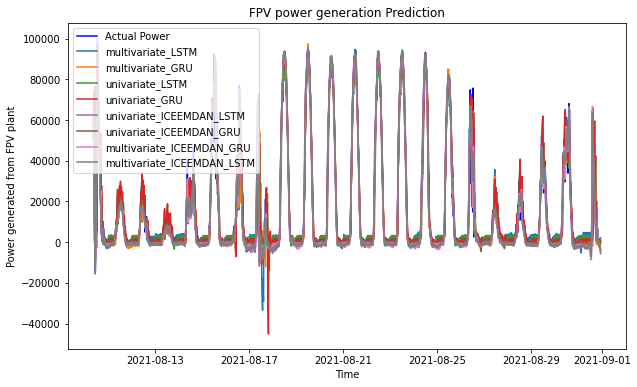

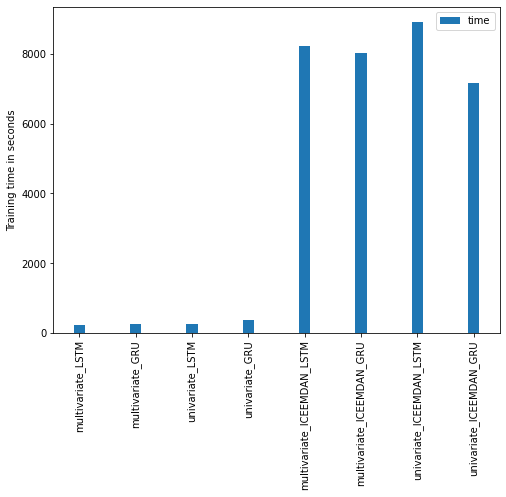

In [ ]:
y_test_unscaled = scaler_pred.inverse_transform(test_y.reshape(-1, 1))
plt.figure(figsize=(10,6))
plt.plot(test_dates[sw_width:-n_out],y_test_unscaled, color='blue', label='Actual Power')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_LSTM'],label='multivariate_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_GRU'],label='multivariate_GRU')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_LSTM'],label='univariate_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_GRU'],label='univariate_GRU')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_ICEEMDAN_LSTM'],label='univariate_ICEEMDAN_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_ICEEMDAN_GRU'],label='univariate_ICEEMDAN_GRU')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_ICEEMDAN_GRU'],label='multivariate_ICEEMDAN_GRU')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_ICEEMDAN_LSTM'],label='multivariate_ICEEMDAN_LSTM')


plt.title('FPV power generation Prediction')
plt.xlabel('Time')
plt.ylabel('Power generated from FPV plant')
plt.legend()
plt.show()

width = 0.2
x = np.arange(len(training_time_took))
Training_time=[v for v in training_time_took.values()]
plt.ylabel('Training time in seconds')
plt.bar(x , Training_time, width, label='time')
plt.xticks(ticks=x, labels=training_time_took.keys(),
            rotation=90)
_ = plt.legend()




In [ ]:
x = np.arange(len(RMSE))
width=0.2
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(8,10))
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
RMSE_value_unscaled=[v for v in RMSE.values()]
ax.bar(x-0.1 , RMSE_value_unscaled, width, color = 'red',label='RMSE')

#sMape_value_unscaled=[v for v in sMAPE.values()]
#ax.bar(x-0.3 , sMape_value_unscaled, width,color = 'black', label='sMAPE')

MAAPE_value_unscaled=[v for v in MAAPE.values()]
ax.bar(x-0.3 , MAAPE_value_unscaled, width,color = 'black', label='MAAPE')


R2_value_unscaled=[v for v in R2.values()]
ax2.bar(x+0.1 , R2_value_unscaled, width,color = 'green', label='R2')

#MAE_value_unscaled=[v for v in MAE.values()]
#plt.bar(x+0.3 , MAE_value_unscaled, width, label='MAE')
#labels = ax.get_xticklabels(RMSE.keys())
#ax.barh(group_names, group_data)
#group_data = list(data.values())
#group_names = list(data.keys())
#labels = ax.get_xticklabels()
#plt.setp(labels, rotation=45, horizontalalignment='right')

ax.set_xticks(x)
ax.set_xticklabels(labels=RMSE.keys(),
            rotation=90)

ax2.legend(loc=9)
ax.legend(loc=2)
ax.set_ylabel('RMSE, sMAPE in kW', color = 'g')
ax2.set_ylabel('R2', color = 'b')
#fig.tight_layout()
plt.show()


# Saving the values

In [ ]:
#### save in the drive
#/content/drive/MyDrive/forecasting_data2/15min_24h_test_pred_value
#/content/drive/MyDrive/forecasting_data2/15min_6h_test_pred_value
dump(test_y_scaled, open('/content/drive/MyDrive/forecasting_data2/v24_2022_11-01_60min_48h_test_pred_value/test_y_scaled.pkl', 'wb'))

dump(y_pred_scaled, open('/content/drive/MyDrive/forecasting_data2/v24_2022_11-01_60min_48h_test_pred_value/y_pred_scaled.pkl', 'wb'))
dump(test_y_unscaled, open('/content/drive/MyDrive/forecasting_data2/v24_2022_11-01_60min_48h_test_pred_value/test_y_unscaled.pkl', 'wb'))
dump(y_pred_unscaled, open('/content/drive/MyDrive/forecasting_data2/v24_2022_11-01_60min_48h_test_pred_value/y_pred_unscaled.pkl', 'wb'))

dump(training_time_took, open('/content/drive/MyDrive/forecasting_data2/v24_2022_11-01_60min_48h_test_pred_value/training_time_took.pkl', 'wb'))

#dump(model, open('/content/drive/MyDrive/forecasting_data2/15min_24h_test_pred_value/model.pkl', 'wb'))
#dump(y_pred_scaled['multivariate_ICEEMDAN_GRU'], open('/content/drive/MyDrive/forecasting_data2/15min_24h_test_pred_value/test_y_scaled.pkl', 'wb'))


# utilizing the saving value

In [ ]:
with open('/content/drive/MyDrive/forecasting_data2/15min_24h_test_pred_value/y_pred_scaled.pkl', 'rb') as f:
  all_ypred_scaled = load(f)
all_ypred_scaled

{'multivariate_GRU': array([[[5.0140345e-01],
         [5.7290363e-01],
         [6.1041880e-01],
         [6.4178747e-01]],
 
        [[6.4616698e-01],
         [6.8188274e-01],
         [6.9654113e-01],
         [7.1524936e-01]],
 
        [[4.0364183e-02],
         [2.7302315e-02],
         [1.3938194e-02],
         [9.1030449e-03]],
 
        ...,
 
        [[9.6034631e-04],
         [3.1512603e-03],
         [4.6508759e-03],
         [5.8073178e-03]],
 
        [[4.7809631e-04],
         [2.1775998e-03],
         [3.1109042e-03],
         [4.5214966e-03]],
 
        [[1.1653863e-03],
         [2.8134286e-03],
         [5.0316304e-03],
         [7.6185074e-03]]], dtype=float32),
 'multivariate_LSTM': array([[[ 5.2605873e-01],
         [ 5.9945047e-01],
         [ 6.3820207e-01],
         [ 6.7520666e-01]],
 
        [[ 6.4805442e-01],
         [ 6.7913169e-01],
         [ 6.8437481e-01],
         [ 7.0080686e-01]],
 
        [[ 1.8222684e-01],
         [ 1.7608202e-01],
         [ 

# ICEEMDAN-SE LSTM GRU

In [37]:
# power as kW
#/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw
## for 60 min resolution
## cimfs 7 is the clearness index so is not used later but here read

## CMFS and SE generation
import scipy.io as sio
mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs0.mat')
cimfs0= mat_contents['cimfs0']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs1.mat')
cimfs1= mat_contents['cimfs1']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs2.mat')
cimfs2= mat_contents['cimfs2']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs3.mat')
cimfs3= mat_contents['cimfs3']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs4.mat')
cimfs4= mat_contents['cimfs4']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs5.mat')
cimfs5= mat_contents['cimfs5']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs6.mat')
cimfs6= mat_contents['cimfs6']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs7.mat')
cimfs7= mat_contents['cimfs7']

mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs8.mat')
cimfs8= mat_contents['cimfs8']

#mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_all_imf_before_normalize_15powerkw_Nov22/cimfs9.mat')
#cimfs9= mat_contents['cimfs9']

# cimfs generation test
se0=[]
for i in np.arange(len(cimfs8)):
  se=ant.sample_entropy(cimfs8[i])
  se0.append(se)
  print('Sample entropy: %.3f' % se)

# cimfs generation test
se0=[]
for i in np.arange(len(cimfs0)):
  se=ant.sample_entropy(cimfs0[i])
  se0.append(se)
  print('Sample entropy: %.3f' % se)








def convert_5_imfs(cimf):
      cimf_allnew=[]
      cimf0= cimf[0]+cimf[1]+cimf[2]
      cimf1= cimf[3]+cimf[4]
      cimf2= cimf[5]
      cimf3= cimf[6]+cimf[7]
      cimf4= cimf[8]+cimf[9]
      #cimf4= cimf[8]+cimf[9]+cimf[10] 

      if cimf.shape[0]==15:
        cimf5=cimf[10]+cimf[11]+cimf[12]+cimf[13]+cimf[14]
      elif cimf.shape[0]==13:
        cimf5=cimf[10]+cimf[11]+cimf[12]
      else:
        cimf5=cimf[10]+cimf[11]+cimf[12]+cimf[13]
      cimf_allnew.append((cimf0,cimf1,cimf2,cimf3,cimf4,cimf5))
      return np.array(cimf_allnew)

cimfs0=convert_5_imfs(cimfs0)
cimfs0=cimfs0.reshape(cimfs0.shape[1],cimfs0.shape[2])

cimfs1=convert_5_imfs(cimfs1)
cimfs1=cimfs1.reshape(cimfs1.shape[1],cimfs1.shape[2])

cimfs2=convert_5_imfs(cimfs2)
cimfs2=cimfs2.reshape(cimfs2.shape[1],cimfs2.shape[2])

cimfs3=convert_5_imfs(cimfs3)
cimfs3=cimfs3.reshape(cimfs3.shape[1],cimfs3.shape[2])

cimfs4=convert_5_imfs(cimfs4)
cimfs4=cimfs4.reshape(cimfs4.shape[1],cimfs4.shape[2])

cimfs5=convert_5_imfs(cimfs5)
cimfs5=cimfs5.reshape(cimfs5.shape[1],cimfs5.shape[2])

cimfs6=convert_5_imfs(cimfs6)
cimfs6=cimfs6.reshape(cimfs6.shape[1],cimfs6.shape[2])

cimfs7=convert_5_imfs(cimfs7)
cimfs7=cimfs7.reshape(cimfs7.shape[1],cimfs7.shape[2])

cimfs8=convert_5_imfs(cimfs8)
cimfs8=cimfs8.reshape(cimfs8.shape[1],cimfs8.shape[2])






Sample entropy: 0.266
Sample entropy: 0.706
Sample entropy: 0.612
Sample entropy: 0.563
Sample entropy: 0.478
Sample entropy: 0.315
Sample entropy: 0.131
Sample entropy: 0.067
Sample entropy: 0.030
Sample entropy: 0.014
Sample entropy: 0.009
Sample entropy: 0.004
Sample entropy: 0.001
Sample entropy: 0.000
Sample entropy: 1.022
Sample entropy: 0.865
Sample entropy: 0.585
Sample entropy: 0.598
Sample entropy: 0.376
Sample entropy: 0.206
Sample entropy: 0.088
Sample entropy: 0.051
Sample entropy: 0.024
Sample entropy: 0.011
Sample entropy: 0.006
Sample entropy: 0.003
Sample entropy: 0.002
Sample entropy: 0.000


In [ ]:
cimfs8.shape

(6, 15892)

##multi and uni iceemdan se lstm gru

In [ ]:
# chnaged on 11/8/22 cimfs7
#                           cimfs7[i].reshape(-1,1), ,    cimfs 7 is the clearness index so is not used

### prediction modeling with 6 inputs

tf.compat.v1.reset_default_graph()


predictions_multi_LSTM=[]

start_time = time.time()
name='multivariate_ICEEMDAN_SE_LSTM'
#for i in np.arange(len(cimfs0)):
#for i in range(2,12):
for i in np.arange(len(cimfs0)):
    print(i)
    cimfs=np.column_stack((cimfs0[i].reshape(-1,1), 
                           cimfs1[i].reshape(-1,1), 
                           cimfs2[i].reshape(-1,1), 
                           cimfs3[i].reshape(-1,1), 
                           cimfs4[i].reshape(-1,1), 
                           cimfs5[i].reshape(-1,1), 
                           cimfs6[i].reshape(-1,1),

                           cimfs8[i].reshape(-1,1)))
    #prediction_out,history,model
    predictions_multi_LSTM.append(imf_trainer_LSTM(cimfs,name))

training_time_took[name]=time.time() - start_time 

'''
#
res_multi=np.column_stack((cres0.reshape(-1,1), 
                           cres1.reshape(-1,1), 
                           cres2.reshape(-1,1), 
                           cres3.reshape(-1,1), 
                           cres4.reshape(-1,1), 
                           cres5.reshape(-1,1), 
                           cres6.reshape(-1,1),
                           cres7.reshape(-1,1),
                           cres8.reshape(-1,1)))
predictions_multi_LSTM.append(imf_trainer_LSTM(res_multi,name))
'''

predictions_ICEEMDAN_SE_multi_LSTM1=sum(predictions_multi_LSTM)


predictions_multi_GRU=[]

name='multivariate_ICEEMDAN_SE_GRU'
start_time = time.time()
#for i in np.arange(len(cimfs0)):
for i in np.arange(len(cimfs0)):
    print(i)
    cimfs=np.column_stack((cimfs0[i].reshape(-1,1), 
                           cimfs1[i].reshape(-1,1), 
                           cimfs2[i].reshape(-1,1), 
                           cimfs3[i].reshape(-1,1), 
                           cimfs4[i].reshape(-1,1), 
                           cimfs5[i].reshape(-1,1), 
                           cimfs6[i].reshape(-1,1),

                           cimfs8[i].reshape(-1,1)))
    predictions_multi_GRU.append(imf_trainer_GRU(cimfs,name))

training_time_took[name]=time.time() - start_time 


#predictions_multi_GRU.append(imf_trainer_GRU(res_multi,name))
predictions_ICEEMDAN_SE_multi_GRU2=sum(predictions_multi_GRU)


   
### univar
imfs=cimfs8 
#res=cres8



predictions_LSTM=[]
name='univariate_ICEEMDAN_SE_LSTM'
start_time = time.time()


for i in np.arange(len(imfs)):
    print(i)
    imf=cimfs8[i].reshape(-1,1)
    #history['univariate_ICEEMDAN_LSTM'], model['univariate_ICEEMDAN_LSTM'], prediction['univariate_ICEEMDAN_LSTM'], training_time_t['univariate_ICEEMDAN_LSTM'], prediction_time_t['univariate_ICEEMDAN_LSTM']=imf_trainer(imf,test,val)
    predictions_LSTM.append(imf_trainer_uni_LSTM(imf, name))

training_time_took[name]=time.time() - start_time 


#res_uni=res.reshape(-1,1)
#predictions_LSTM.append(imf_trainer_uni_LSTM(res_uni, name))
predictions_ICEEMDAN_SE_uni_LSTM=sum(predictions_LSTM)



predictions_GRU=[]
name='univariate_ICEEMDAN_SE_GRU'
start_time = time.time()
for i in np.arange(len(imfs)):
    print(i)
    imf=cimfs8[i].reshape(-1,1)
    predictions_GRU.append(imf_trainer_uni_GRU(imf,name))

training_time_took[name]=time.time() - start_time 



#predictions_GRU.append(imf_trainer_uni_GRU(res_uni,name))
predictions_ICEEMDAN_SE_uni_GRU=sum(predictions_GRU)




Streaming output truncated to the last 5000 lines.
244/244 [==============================] - 2s 8ms/step - loss: 0.0045 - root_mean_squared_error: 0.0649 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0557
Epoch 274/300
244/244 [==============================] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0651.
Epoch 274: val_loss did not improve from 0.00337
244/244 [==============================] - 2s 8ms/step - loss: 0.0045 - root_mean_squared_error: 0.0651 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0554
Epoch 275/300
240/244 [============================>.] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0653.
Epoch 275: val_loss did not improve from 0.00337
244/244 [==============================] - 2s 8ms/step - loss: 0.0046 - root_mean_squared_error: 0.0653 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0556
Epoch 276/300
244/244 [==============================] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0648.
Epoch 276: val_loss did

## result only iceemdan se lstm gru

In [ ]:
# without  iceemdan lstm gru



test_y_scaled=test_y
test_y_unscaled = scaler_pred.inverse_transform(test_y_scaled.reshape(-1,1))



name='multivariate_GRU'
df_total_multi=df_total
df_multi, scaler_multi, dff=normalize(df_total_multi)
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_multi,minute) 
test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)



name='multivariate_LSTM'
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
nl = '\n'



### multivariate ICEEMDAN GRU
name='multivariate_ICEEMDAN_SE_GRU'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_multi_GRU2
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_multi_GRU2 ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='multivariate_ICEEMDAN_SE_LSTM'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_multi_LSTM1
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_multi_LSTM1 ## already the unscaled value
RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]




name='univariate_GRU'
df_total_uni=df_uni
df_uni, scaler_uni, dff=normalize(df_total_uni)
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_uni,minute) 
test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)

name='univariate_LSTM'
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)



name='univariate_ICEEMDAN_SE_GRU'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_uni_GRU
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_uni_GRU ## already the unscaled value
RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='univariate_ICEEMDAN_SE_LSTM'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_uni_LSTM
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_uni_LSTM ## already the unscaled value
RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]



print(f"RMSE: {RMSE}")

print(f"MAE:{MAE}")

print(f"sMAPE: {sMAPE}")

print(f"MAAPE:{MAAPE}")

print(f"R2 score:{R2}")

print(f"rmse_scaled:{RMSE_scaled}")


print(f"Total runtime for {'multivariate_GRU'}: {hms_string(training_time_took['multivariate_GRU'])}")
print(f"Total runtime for {'multivariate_LSTM'}: {hms_string(training_time_took['multivariate_LSTM'])}")

print(f"Total runtime for {'ICEEMDAN_SE_multivariate_GRU'}: {hms_string(training_time_took['multivariate_ICEEMDAN_SE_GRU'])}")
print(f"Total runtime for {'ICEEMDAN_SE_multivariate_LSTM'}: {hms_string(training_time_took['multivariate_ICEEMDAN_SE_LSTM'])}")



print(f"Total runtime for {'univariate_GRU'}: {hms_string(training_time_took['univariate_GRU'])}")
print(f"Total runtime for {'univariate_LSTM'}: {hms_string(training_time_took['univariate_LSTM'])}")

print(f"Total runtime for {'ICEEMDAN_SE_univariate_GRU'}: {hms_string(training_time_took['univariate_ICEEMDAN_SE_GRU'])}")
print(f"Total runtime for {'ICEEMDAN_SE_univariate_LSTM'}: {hms_string(training_time_took['univariate_ICEEMDAN_SE_LSTM'])}")

#sd=pd.DataFrame(y_pred_scaled['univariate_GRU'].reshape(-1,1), columns = ['Column_A'])
#sd

# without multivariate iccemdan gru all
#y_test_unscaled = scaler_pred.inverse_transform(test_y.reshape(-1, 1))
plt.figure(figsize=(10,10))
testing_figure=test_dates[sw_width:-n_out]
plt.plot(test_dates[sw_width:-n_out],test_y_unscaled, color='blue', label='Actual Power')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_LSTM'],label='multivariate_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_GRU'],label='multivariate_GRU')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_LSTM'],label='univariate_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_GRU'],label='univariate_GRU')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_ICEEMDAN_SE_LSTM'],label='univariate_ICEEMDAN_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_ICEEMDAN_SE_GRU'],label='univariate_ICEEMDAN_GRU')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_ICEEMDAN_SE_LSTM'],label='multivariate_ICEEMDAN_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_ICEEMDAN_SE_GRU'],label='multivariate_ICEEMDAN_GRU')





plt.title('FPV power generation Prediction')
plt.xlabel('Time')
plt.ylabel('Power generated from FPV plant')
plt.legend()
plt.show()

width = 0.2
x = np.arange(len(training_time_took))
Training_time=[v for v in training_time_took.values()]
plt.ylabel('Training time in seconds')
plt.bar(x , Training_time, width, label='time')
plt.xticks(ticks=x, labels=training_time_took.keys(),
            rotation=90)
_ = plt.legend()




## plot

In [ ]:
plt.figure(figsize=(12,10))
#testing_figure=test_dates[sw_width:-20*n_out+1]


plt.plot(test_dates[0:200],test_y_unscaled[0:200], color='blue', label='Actual Power')

plt.plot(test_dates[0:200],y_pred_unscaled['multivariate_GRU'][0:200],label='multivariate_GRU')

plt.plot(test_dates[0:200],y_pred_unscaled['multivariate_LSTM'][0:200],label='multivariate_LSTM')
plt.plot(test_dates[0:200],y_pred_unscaled['univariate_LSTM'][0:200],label='univariate_LSTM')
plt.plot(test_dates[0:200],y_pred_unscaled['univariate_GRU'][0:200],label='univariate_GRU')

plt.plot(test_dates[0:200],y_pred_unscaled['univariate_ICEEMDAN_SE_LSTM'][0:200],label='univariate_ICEEMDAN_LSTM')
plt.plot(test_dates[0:200],y_pred_unscaled['univariate_ICEEMDAN_SE_GRU'][0:200],label='univariate_ICEEMDAN_GRU')

plt.plot(test_dates[0:200],y_pred_unscaled['multivariate_ICEEMDAN_SE_LSTM'][0:200],label='multivariate_ICEEMDAN_LSTM')
plt.plot(test_dates[0:200],y_pred_unscaled['multivariate_ICEEMDAN_SE_GRU'][0:200],label='multivariate_ICEEMDAN_GRU')



plt.title('FPV power generation Prediction')
plt.xlabel('Time')
plt.ylabel('Power generated from FPV plant')
plt.legend()
plt.show()

# ICEEMDAN MEMD

## load mat files in python

In [ ]:
## if we want power as kw
#/content/drive/MyDrive/forecasting_data2/memd_imfpowerkw.mat
import scipy.io as sio
#mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_memd_matfile_nov22_60min/memd_imfpowerkw_nov22_60min.mat')
#imf_memd= mat_contents['imf_memd']

#memd_imfpowerkw_nov20_aug22_60min
mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/from_mat_memd_matfile_nov22_60min/memd_imfpowerkw_nov20_aug22_60min.mat')
imf_memd= mat_contents['imf_memd']


mat_contents

In [ ]:
'''
py_file_location = "/content/drive/MyDrive/forecasting_data2"
sys.path.append(os.path.abspath(py_file_location))

import MEMD_all
from MEMD_all import memd
warnings.simplefilter('ignore')

imf_memd=memd(df_total.values)
#/content/drive/MyDrive/forecasting_data2

dump(imf_memd, open('/content/drive/MyDrive/forecasting_data2/imf_memd.pkl', 'wb'))
'''

'\npy_file_location = "/content/drive/MyDrive/forecasting_data2"\nsys.path.append(os.path.abspath(py_file_location))\n\nimport MEMD_all\nfrom MEMD_all import memd\nwarnings.simplefilter(\'ignore\')\n\nimf_memd=memd(df_total.values)\n#/content/drive/MyDrive/forecasting_data2\n\ndump(imf_memd, open(\'/content/drive/MyDrive/forecasting_data2/imf_memd.pkl\', \'wb\'))\n'

In [ ]:
# if we want power as watt
#/content/drive/MyDrive/forecasting_data2/memd_imf.mat
'''
import scipy.io as sio
mat_contents=sio.loadmat('/content/drive/MyDrive/forecasting_data2/memd_imf.mat')
imf_memd= mat_contents['imf']
#mat_contents
'''

## save as pickle the matrix file

In [ ]:

dump(imf_memd, open('/content/drive/MyDrive/forecasting_data2/imf_memd.pkl', 'wb'))


## from matlab to drive

In [ ]:
with open('/content/drive/MyDrive/forecasting_data2/imf_memd.pkl', 'rb') as f:
  imf_memd= load(f)
imf_memd.shape
## matlab shape variableximfxlength



(9, 16, 23328)

## MEMD SE

In [ ]:
# cimfs generation test
se0=[]
for i in np.arange(len(imf_memd[8,:,:])):
  se=ant.sample_entropy(imf_memd[8,i,:])
  se0.append(se)
  print('Sample entropy: %.3f' % se)


imf_memd_coverted=[]
def convert_5_imfs(cimf):
      cimf_allnew=[]
      cimf0= cimf[0]+cimf[1]+cimf[2]
      cimf1= cimf[3]+cimf[4]+cimf[5]
      cimf2= cimf[6]
      cimf3= cimf[7]+cimf[8]+cimf[9]
      cimf4= cimf[10]+cimf[11]
      #cimf4= cimf[8]+cimf[9]+cimf[10] 

      if cimf.shape[0]==16:
        cimf5=cimf[12]+cimf[13]+cimf[14]+cimf[15]
      elif cimf.shape[0]==15:
        cimf5=cimf[12]+cimf[13]+cimf[14]
      else:
        cimf5=cimf[12]+cimf[13]
      cimf_allnew.append((cimf0,cimf1,cimf2,cimf3,cimf4,cimf5))
      return np.array(cimf_allnew)

cimfs0=convert_5_imfs(imf_memd[0,:,:])
imf_memd_coverted.append(cimfs0.reshape(cimfs0.shape[1],cimfs0.shape[2]))

cimfs1=convert_5_imfs(imf_memd[1,:,:])
imf_memd_coverted.append(cimfs1.reshape(cimfs1.shape[1],cimfs1.shape[2]))


cimfs2=convert_5_imfs(imf_memd[2,:,:])
imf_memd_coverted.append(cimfs2.reshape(cimfs2.shape[1],cimfs2.shape[2]))


cimfs3=convert_5_imfs(imf_memd[3,:,:])
imf_memd_coverted.append(cimfs3.reshape(cimfs3.shape[1],cimfs3.shape[2]))


cimfs4=convert_5_imfs(imf_memd[4,:,:])
imf_memd_coverted.append(cimfs4.reshape(cimfs4.shape[1],cimfs4.shape[2]))


cimfs5=convert_5_imfs(imf_memd[5,:,:])
imf_memd_coverted.append(cimfs5.reshape(cimfs5.shape[1],cimfs5.shape[2]))


cimfs6=convert_5_imfs(imf_memd[6,:,:])
imf_memd_coverted.append(cimfs6.reshape(cimfs6.shape[1],cimfs6.shape[2]))


cimfs7=convert_5_imfs(imf_memd[7,:,:])
imf_memd_coverted.append(cimfs7.reshape(cimfs7.shape[1],cimfs7.shape[2]))


cimfs8=convert_5_imfs(imf_memd[8,:,:])
imf_memd_coverted.append(cimfs8.reshape(cimfs8.shape[1],cimfs8.shape[2]))

imf_memd=np.array(imf_memd_coverted)
imf_memd.shape

### memd se lstm gru multi univariate

In [ ]:
# chnaged on 11/8/22 cimfs7
#                           cimfs7[i].reshape(-1,1),   ,    cimfs 7 is the clearness index so is not used
#                         imf_memd[7,i,:].reshape(-1,1),    ,     imf_memd[7,i,:] is the clearness index so is not used


#https://stackoverflow.com/questions/20186344/ipynb-import-another-ipynb-file
#https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab
#/content/drive/MyDrive/forecasting_data2

#https://github.com/mariogrune/MEMD-Python-/blob/master/MEMD_all.py

#imf = memd(X) returns a 3D matrix 'imf(M,N,L)' containing M multivariate IMFs, 
#hexavariate inputs (N=6), M is the number of IMFs extracted, and L is the data length.


#predictions_multi_LSTM.append(imf_trainer_LSTM(res_multi,name))
#predictions_multi_LSTM.append(sum(predict_cmemd_LSTM))
#predictions_multi_LSTM=[]
predict_cmemd_LSTM=[]
name='multivariate_emd_LSTM'
start_time = time.time()

for i in np.arange(imf_memd.shape[1]):
  print(i)
  cmemd=np.column_stack((imf_memd[0,i,:].reshape(-1,1),
                         imf_memd[1,i,:].reshape(-1,1),
                         imf_memd[2,i,:].reshape(-1,1),
                         imf_memd[3,i,:].reshape(-1,1),
                         imf_memd[4,i,:].reshape(-1,1),
                         imf_memd[5,i,:].reshape(-1,1),
                         imf_memd[6,i,:].reshape(-1,1),

                         imf_memd[8,i,:].reshape(-1,1)
                         ))

  predict_cmemd_LSTM.append(imf_trainer_LSTM(cmemd,name))

training_time_took[name]=time.time() - start_time 
predictions_emd_multi_LSTM=sum(predict_cmemd_LSTM)



predict_cmemd_GRU=[]
name='multivariate_emd_GRU'
start_time = time.time()

for i in np.arange(imf_memd.shape[1]):
  print(i)
  cmemd=np.column_stack((imf_memd[0,i,:].reshape(-1,1),
                         imf_memd[1,i,:].reshape(-1,1),
                         imf_memd[2,i,:].reshape(-1,1),
                         imf_memd[3,i,:].reshape(-1,1),
                         imf_memd[4,i,:].reshape(-1,1),
                         imf_memd[5,i,:].reshape(-1,1),
                         imf_memd[6,i,:].reshape(-1,1),

                         imf_memd[8,i,:].reshape(-1,1)
                         ))

  predict_cmemd_GRU.append(imf_trainer_GRU(cmemd,name))

training_time_took[name]=time.time() - start_time 
predictions_emd_multi_GRU=sum(predict_cmemd_GRU)





predict_uemd_LSTM=[]
name='univariate_emd_LSTM'
start_time = time.time()

for i in np.arange(imf_memd.shape[1]):
  print(i)
  cmemd=imf_memd[8,i,:].reshape(-1,1)                         
  predict_uemd_LSTM.append(imf_trainer_uni_LSTM(cmemd,name))

training_time_took[name]=time.time() - start_time 
predictions_emd_uni_LSTM=sum(predict_uemd_LSTM)


predict_uemd_GRU=[]
name='univariate_emd_GRU'
start_time = time.time()

for i in np.arange(imf_memd.shape[1]):
  print(i)
  cmemd=imf_memd[8,i,:].reshape(-1,1)                         
  predict_uemd_GRU.append(imf_trainer_uni_GRU(cmemd,name))

training_time_took[name]=time.time() - start_time 
predictions_emd_uni_GRU=sum(predict_uemd_GRU)



#from ipynb.fs.full.DM_test import *
#import import_ipynb
#import DM_test

# Results with all the code

In [ ]:
# without  iceemdan lstm gru



test_y_scaled=test_y
test_y_unscaled = scaler_pred.inverse_transform(test_y_scaled.reshape(-1,1))



name='multivariate_GRU'
df_total_multi=df_total
df_multi, scaler_multi, dff=normalize(df_total_multi)
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_multi,minute) 
test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)



name='multivariate_LSTM'
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
nl = '\n'



### multivariate ICEEMDAN GRU
name='multivariate_ICEEMDAN_SE_GRU'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_multi_GRU2
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_multi_GRU2 ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='multivariate_ICEEMDAN_SE_LSTM'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_multi_LSTM1
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_multi_LSTM1 ## already the unscaled value
RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='multivariate_emd_GRU'
y_pred_scaled[name]=predictions_emd_multi_GRU
y_pred_unscaled[name] = predictions_emd_multi_GRU ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='multivariate_emd_LSTM'
y_pred_scaled[name]=predictions_emd_multi_LSTM
y_pred_unscaled[name] = predictions_emd_multi_LSTM ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]



name='univariate_GRU'
df_total_uni=df_uni
df_uni, scaler_uni, dff=normalize(df_total_uni)
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_uni,minute) 
test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)

name='univariate_LSTM'
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)



name='univariate_ICEEMDAN_SE_GRU'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_uni_GRU
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_uni_GRU ## already the unscaled value
RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='univariate_ICEEMDAN_SE_LSTM'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_uni_LSTM
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_uni_LSTM ## already the unscaled value
RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]




name='univariate_emd_GRU'
y_pred_scaled[name]=predictions_emd_uni_GRU
y_pred_unscaled[name] = predictions_emd_uni_GRU ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='univariate_emd_LSTM'
y_pred_scaled[name]=predictions_emd_uni_LSTM
y_pred_unscaled[name] = predictions_emd_uni_LSTM ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]











print(f"RMSE: {RMSE}")

print(f"MAE:{MAE}")

print(f"sMAPE: {sMAPE}")

print(f"MAAPE:{MAAPE}")

print(f"R2 score:{R2}")

print(f"rmse_scaled:{RMSE_scaled}")


print(f"Total runtime for {'multivariate_GRU'}: {hms_string(training_time_took['multivariate_GRU'])}")
print(f"Total runtime for {'multivariate_LSTM'}: {hms_string(training_time_took['multivariate_LSTM'])}")

print(f"Total runtime for {'ICEEMDAN_SE_multivariate_GRU'}: {hms_string(training_time_took['multivariate_ICEEMDAN_SE_GRU'])}")
print(f"Total runtime for {'ICEEMDAN_SE_multivariate_LSTM'}: {hms_string(training_time_took['multivariate_ICEEMDAN_SE_LSTM'])}")

print(f"Total runtime for {'multivariate_emd_GRU'}: {hms_string(training_time_took['multivariate_emd_GRU'])}")
print(f"Total runtime for {'multivariate_emd_LSTM'}: {hms_string(training_time_took['multivariate_emd_LSTM'])}")


print(f"Total runtime for {'univariate_GRU'}: {hms_string(training_time_took['univariate_GRU'])}")
print(f"Total runtime for {'univariate_LSTM'}: {hms_string(training_time_took['univariate_LSTM'])}")

print(f"Total runtime for {'ICEEMDAN_SE_univariate_GRU'}: {hms_string(training_time_took['univariate_ICEEMDAN_SE_GRU'])}")
print(f"Total runtime for {'ICEEMDAN_SE_univariate_LSTM'}: {hms_string(training_time_took['univariate_ICEEMDAN_SE_LSTM'])}")

print(f"Total runtime for {'univariate_emd_GRU'}: {hms_string(training_time_took['univariate_emd_GRU'])}")
print(f"Total runtime for {'univariate_emd_LSTM'}: {hms_string(training_time_took['univariate_emd_LSTM'])}")

#sd=pd.DataFrame(y_pred_scaled['univariate_GRU'].reshape(-1,1), columns = ['Column_A'])
#sd

# Some results analysis

In [ ]:
#https://colab.research.google.com/drive/1k3PLdczAJOIrIprfhjZ-IRXzNhFJ_OTN#scrollTo=zknFRCgtAFVn

df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
sns.lineplot(x=df.index, y="cnt", data=df);
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);


fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)
sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4);

fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)
sns.pointplot(data=df, x='day_of_week', y='cnt', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='cnt', hue='season', ax=ax2);


plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();



#https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/timeseries/ipynb/timeseries_weather_forecasting.ipynb#scrollTo=AHRhLnBZAVJx

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")



#https://www.tensorflow.org/tutorials/structured_data/time_series

for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
# MAIN one



test_y_scaled=test_y
test_y_unscaled = scaler_pred.inverse_transform(test_y_scaled.reshape(-1,1))



name='multivariate_GRU'
df_total_multi=df_total
df_multi, scaler_multi, dff=normalize(df_total_multi)
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_multi,minute) 
test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)



name='multivariate_LSTM'
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
nl = '\n'


### multivariate ICEEMDAN GRU
name='multivariate_ICEEMDAN_GRU'
y_pred_scaled[name]=predictions_ICEEMDAN_multi_GRU2
y_pred_unscaled[name] = predictions_ICEEMDAN_multi_GRU2 ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='multivariate_ICEEMDAN_LSTM'
y_pred_scaled[name]=predictions_ICEEMDAN_multi_LSTM1
y_pred_unscaled[name] = predictions_ICEEMDAN_multi_LSTM1 ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

### multivariate ICEEMDAN GRU
name='multivariate_ICEEMDAN_SE_GRU'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_multi_GRU2
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_multi_GRU2 ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='multivariate_ICEEMDAN_SE_LSTM'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_multi_LSTM1
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_multi_LSTM1 ## already the unscaled value
RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]


name='multivariate_emd_GRU'
y_pred_scaled[name]=predictions_emd_multi_GRU
y_pred_unscaled[name] = predictions_emd_multi_GRU ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='multivariate_emd_LSTM'
y_pred_scaled[name]=predictions_emd_multi_LSTM
y_pred_unscaled[name] = predictions_emd_multi_LSTM ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]



name='univariate_GRU'
df_total_uni=df_uni
df_uni, scaler_uni, dff=normalize(df_total_uni)
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_uni,minute) 
test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)

name='univariate_LSTM'
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)


### univariate ICEEMDAN GRU
name='univariate_ICEEMDAN_GRU'
y_pred_scaled[name]=predictions_ICEEMDAN_uni_GRU
y_pred_unscaled[name] = predictions_ICEEMDAN_uni_GRU ## already unscaled in imf trainer

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='univariate_ICEEMDAN_LSTM'
y_pred_scaled[name]=predictions_ICEEMDAN_uni_LSTM
y_pred_unscaled[name] = predictions_ICEEMDAN_uni_LSTM ## already unscaled in imf trainer

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]


name='univariate_ICEEMDAN_SE_GRU'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_uni_GRU
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_uni_GRU ## already the unscaled value
RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='univariate_ICEEMDAN_SE_LSTM'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_uni_LSTM
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_uni_LSTM ## already the unscaled value
RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]





name='univariate_emd_GRU'
y_pred_scaled[name]=predictions_emd_uni_GRU
y_pred_unscaled[name] = predictions_emd_uni_GRU ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='univariate_emd_LSTM'
y_pred_scaled[name]=predictions_emd_uni_LSTM
y_pred_unscaled[name] = predictions_emd_uni_LSTM ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]







print(f"RMSE: {RMSE}")

print(f"MAE:{MAE}")

print(f"sMAPE: {sMAPE}")

print(f"MAAPE:{MAAPE}")

print(f"R2 score:{R2}")

print(f"rmse_scaled:{RMSE_scaled}")


print(f"Total runtime for {'multivariate_GRU'}: {hms_string(training_time_took['multivariate_GRU'])}")
print(f"Total runtime for {'multivariate_LSTM'}: {hms_string(training_time_took['multivariate_LSTM'])}")

print(f"Total runtime for {'ICEEMDAN_SE_multivariate_GRU'}: {hms_string(training_time_took['multivariate_ICEEMDAN_SE_GRU'])}")
print(f"Total runtime for {'ICEEMDAN_SE_multivariate_LSTM'}: {hms_string(training_time_took['multivariate_ICEEMDAN_SE_LSTM'])}")


print(f"Total runtime for {'univariate_GRU'}: {hms_string(training_time_took['univariate_GRU'])}")
print(f"Total runtime for {'univariate_LSTM'}: {hms_string(training_time_took['univariate_LSTM'])}")

print(f"Total runtime for {'ICEEMDAN_SE_univariate_GRU'}: {hms_string(training_time_took['univariate_ICEEMDAN_SE_GRU'])}")
print(f"Total runtime for {'ICEEMDAN_SE_univariate_LSTM'}: {hms_string(training_time_took['univariate_ICEEMDAN_SE_LSTM'])}")


#sd=pd.DataFrame(y_pred_scaled['univariate_GRU'].reshape(-1,1), columns = ['Column_A'])
#sd

[9.64199982e+01 3.07179996e+01 1.27236212e+03 8.34999975e+00
 3.55306657e+02 1.00000000e+02 5.58250702e+02 2.00000000e+00
 1.11107157e+05]


NameError: ignored

In [ ]:
# without emd an iceemdan lstm gru



test_y_scaled=test_y
test_y_unscaled = scaler_pred.inverse_transform(test_y_scaled.reshape(-1,1))



name='multivariate_GRU'
df_total_multi=df_total
df_multi, scaler_multi, dff=normalize(df_total_multi)
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_multi,minute) 
test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)



name='multivariate_LSTM'
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
nl = '\n'



### multivariate ICEEMDAN GRU
name='multivariate_ICEEMDAN_SE_GRU'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_multi_GRU2
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_multi_GRU2 ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='multivariate_ICEEMDAN_SE_LSTM'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_multi_LSTM1
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_multi_LSTM1 ## already the unscaled value
RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='multivariate_emd_GRU'
y_pred_scaled[name]=predictions_emd_multi_GRU
y_pred_unscaled[name] = predictions_emd_multi_GRU ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='multivariate_emd_LSTM'
y_pred_scaled[name]=predictions_emd_multi_LSTM
y_pred_unscaled[name] = predictions_emd_multi_LSTM ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]



name='univariate_GRU'
df_total_uni=df_uni
df_uni, scaler_uni, dff=normalize(df_total_uni)
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_uni,minute) 
test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)

name='univariate_LSTM'
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)



name='univariate_ICEEMDAN_SE_GRU'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_uni_GRU
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_uni_GRU ## already the unscaled value
RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='univariate_ICEEMDAN_SE_LSTM'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_uni_LSTM
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_uni_LSTM ## already the unscaled value
RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]




name='univariate_emd_GRU'
y_pred_scaled[name]=predictions_emd_uni_GRU
y_pred_unscaled[name] = predictions_emd_uni_GRU ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='univariate_emd_LSTM'
y_pred_scaled[name]=predictions_emd_uni_LSTM
y_pred_unscaled[name] = predictions_emd_uni_LSTM ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]











print(f"RMSE: {RMSE}")

print(f"MAE:{MAE}")

print(f"sMAPE: {sMAPE}")

print(f"MAAPE:{MAAPE}")

print(f"R2 score:{R2}")

print(f"rmse_scaled:{RMSE_scaled}")


print(f"Total runtime for {'multivariate_GRU'}: {hms_string(training_time_took['multivariate_GRU'])}")
print(f"Total runtime for {'multivariate_LSTM'}: {hms_string(training_time_took['multivariate_LSTM'])}")

print(f"Total runtime for {'ICEEMDAN_SE_multivariate_GRU'}: {hms_string(training_time_took['multivariate_ICEEMDAN_SE_GRU'])}")
print(f"Total runtime for {'ICEEMDAN_SE_multivariate_LSTM'}: {hms_string(training_time_took['multivariate_ICEEMDAN_SE_LSTM'])}")

print(f"Total runtime for {'multivariate_emd_GRU'}: {hms_string(training_time_took['multivariate_emd_GRU'])}")
print(f"Total runtime for {'multivariate_emd_LSTM'}: {hms_string(training_time_took['multivariate_emd_LSTM'])}")


print(f"Total runtime for {'univariate_GRU'}: {hms_string(training_time_took['univariate_GRU'])}")
print(f"Total runtime for {'univariate_LSTM'}: {hms_string(training_time_took['univariate_LSTM'])}")

print(f"Total runtime for {'ICEEMDAN_SE_univariate_GRU'}: {hms_string(training_time_took['univariate_ICEEMDAN_SE_GRU'])}")
print(f"Total runtime for {'ICEEMDAN_SE_univariate_LSTM'}: {hms_string(training_time_took['univariate_ICEEMDAN_SE_LSTM'])}")

print(f"Total runtime for {'univariate_emd_GRU'}: {hms_string(training_time_took['univariate_emd_GRU'])}")
print(f"Total runtime for {'univariate_emd_LSTM'}: {hms_string(training_time_took['univariate_emd_LSTM'])}")

#sd=pd.DataFrame(y_pred_scaled['univariate_GRU'].reshape(-1,1), columns = ['Column_A'])
#sd

[9.64199982e+01 3.07179996e+01 1.27236212e+03 8.34999975e+00
 3.55306657e+02 1.00000000e+02 5.58250702e+02 2.00000000e+00
 1.11107157e+05]
[1.]
RMSE: {'multivariate_GRU': 7738.295542611454, 'multivariate_LSTM': 9543.5609716521, 'multivariate_ICEEMDAN_SE_GRU': 4122.517632375734, 'multivariate_ICEEMDAN_SE_LSTM': 4160.350512441599, 'multivariate_emd_GRU': 7891.600306274144, 'multivariate_emd_LSTM': 6932.258328175113, 'univariate_GRU': 7732.480909614491, 'univariate_LSTM': 7543.178284144583, 'univariate_ICEEMDAN_SE_GRU': 4018.661351147193, 'univariate_ICEEMDAN_SE_LSTM': 4033.7020606898445, 'univariate_emd_GRU': 6397.428467149192, 'univariate_emd_LSTM': 7052.288090772892}
MAE:{'multivariate_GRU': 4403.917377642643, 'multivariate_LSTM': 4953.578538055019, 'multivariate_ICEEMDAN_SE_GRU': 2716.0580016787967, 'multivariate_ICEEMDAN_SE_LSTM': 2226.857623811592, 'multivariate_emd_GRU': 5552.94924811191, 'multivariate_emd_LSTM': 4125.701309062179, 'univariate_GRU': 4306.70718302558, 'univariate_LS

In [ ]:
# without emd



test_y_scaled=test_y
test_y_unscaled = scaler_pred.inverse_transform(test_y_scaled.reshape(-1,1))



name='multivariate_GRU'
df_total_multi=df_total
df_multi, scaler_multi, dff=normalize(df_total_multi)
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_multi,minute) 
test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)



name='multivariate_LSTM'
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
nl = '\n'



### multivariate ICEEMDAN GRU
name='multivariate_ICEEMDAN_SE_GRU'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_multi_GRU2
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_multi_GRU2 ## already the unscaled value

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='multivariate_ICEEMDAN_SE_LSTM'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_multi_LSTM1
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_multi_LSTM1 ## already the unscaled value
RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]



name='univariate_GRU'
df_total_uni=df_uni
df_uni, scaler_uni, dff=normalize(df_total_uni)
train, val, test, train_dates, val_dates, test_dates=split_dataset(df_uni,minute) 
test_x, test_y = sliding_window(test, sw_width=sw_width,n_out=n_out, in_start=0, increment=n_out,target_num=target_num)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2])) 
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)

name='univariate_LSTM'
y_pred_scaled[name] = model[name].predict(test_x)
y_pred_unscaled[name] = scaler_pred.inverse_transform(y_pred_scaled[name].reshape(-1,1))

RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)




name='univariate_ICEEMDAN_SE_GRU'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_uni_GRU
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_uni_GRU ## already the unscaled value
RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]

name='univariate_ICEEMDAN_SE_LSTM'
y_pred_scaled[name]=predictions_ICEEMDAN_SE_uni_LSTM
y_pred_unscaled[name] = predictions_ICEEMDAN_SE_uni_LSTM ## already the unscaled value
RMSE[name], sMAPE[name],MAAPE[name], MAE[name], R2[name], RMSE_scaled[name],y_pred_unscaled[name]= performance_eval(y_pred_unscaled[name],test_y_unscaled)
test_performance[name]=[0.008,RMSE_scaled[name]]











print(f"RMSE: {RMSE}")

print(f"MAE:{MAE}")

print(f"sMAPE: {sMAPE}")

print(f"MAAPE:{MAAPE}")

print(f"R2 score:{R2}")

print(f"rmse_scaled:{RMSE_scaled}")


print(f"Total runtime for {'multivariate_GRU'}: {hms_string(training_time_took['multivariate_GRU'])}")
print(f"Total runtime for {'multivariate_LSTM'}: {hms_string(training_time_took['multivariate_LSTM'])}")

print(f"Total runtime for {'ICEEMDAN_SE_multivariate_GRU'}: {hms_string(training_time_took['multivariate_ICEEMDAN_SE_GRU'])}")
print(f"Total runtime for {'ICEEMDAN_SE_multivariate_LSTM'}: {hms_string(training_time_took['multivariate_ICEEMDAN_SE_LSTM'])}")


print(f"Total runtime for {'univariate_GRU'}: {hms_string(training_time_took['univariate_GRU'])}")
print(f"Total runtime for {'univariate_LSTM'}: {hms_string(training_time_took['univariate_LSTM'])}")

print(f"Total runtime for {'ICEEMDAN_SE_univariate_GRU'}: {hms_string(training_time_took['univariate_ICEEMDAN_SE_GRU'])}")
print(f"Total runtime for {'ICEEMDAN_SE_univariate_LSTM'}: {hms_string(training_time_took['univariate_ICEEMDAN_SE_LSTM'])}")


#sd=pd.DataFrame(y_pred_scaled['univariate_GRU'].reshape(-1,1), columns = ['Column_A'])
#sd

[9.64199982e+01 3.07179996e+01 1.27236212e+03 8.34999975e+00
 3.55306657e+02 1.00000000e+02 5.58250702e+02 2.00000000e+00
 1.11107157e+05]
[1.]
RMSE: {'multivariate_GRU': 7738.295542611452, 'multivariate_LSTM': 9543.560971652096, 'multivariate_ICEEMDAN_SE_GRU': 4122.517632375733, 'multivariate_ICEEMDAN_SE_LSTM': 4160.350512441597, 'multivariate_emd_GRU': 7891.600306274141, 'multivariate_emd_LSTM': 6932.258328175113, 'univariate_GRU': 7732.480909614487, 'univariate_LSTM': 7543.17828414458, 'univariate_ICEEMDAN_SE_GRU': 4018.661351147192, 'univariate_ICEEMDAN_SE_LSTM': 4033.702060689843, 'univariate_emd_GRU': 6397.428467149192, 'univariate_emd_LSTM': 7052.28809077289}
MAE:{'multivariate_GRU': 4403.917377642641, 'multivariate_LSTM': 4953.578538055015, 'multivariate_ICEEMDAN_SE_GRU': 2716.0580016787953, 'multivariate_ICEEMDAN_SE_LSTM': 2226.857623811591, 'multivariate_emd_GRU': 5552.949248111909, 'multivariate_emd_LSTM': 4125.701309062179, 'univariate_GRU': 4306.707183025578, 'univariate_L

# plot

In [ ]:
# without multivariate iccemdan gru all
#y_test_unscaled = scaler_pred.inverse_transform(test_y.reshape(-1, 1))
plt.figure(figsize=(10,10))
testing_figure=test_dates[sw_width:-n_out]
plt.plot(test_dates[sw_width:-n_out],test_y_unscaled, color='blue', label='Actual Power')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_LSTM'],label='multivariate_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_GRU'],label='multivariate_GRU')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_LSTM'],label='univariate_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_GRU'],label='univariate_GRU')



plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_ICEEMDAN_SE_LSTM'],label='univariate_ICEEMDAN_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_ICEEMDAN_SE_GRU'],label='univariate_ICEEMDAN_GRU')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_ICEEMDAN_SE_LSTM'],label='multivariate_ICEEMDAN_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_ICEEMDAN_SE_GRU'],label='multivariate_ICEEMDAN_GRU')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_emd_LSTM'],label='multivariate_emd_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_emd_GRU'],label='multivariate_emd_GRU')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_emd_LSTM'],label='univariate_emd_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_emd_GRU'],label='univariate_emd_GRU')





plt.title('FPV power generation Prediction')
plt.xlabel('Time')
plt.ylabel('Power generated from FPV plant')
plt.legend()
plt.show()

width = 0.2
x = np.arange(len(training_time_took))
Training_time=[v for v in training_time_took.values()]
plt.ylabel('Training time in seconds')
plt.bar(x , Training_time, width, label='time')
plt.xticks(ticks=x, labels=training_time_took.keys(),
            rotation=90)
_ = plt.legend()




KeyError: ignored

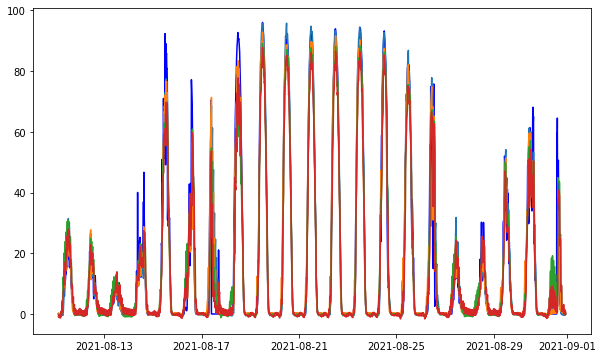

In [ ]:
#y_test_unscaled = scaler_pred.inverse_transform(test_y.reshape(-1, 1))
plt.figure(figsize=(10,6))
testing_figure=test_dates[sw_width:-n_out]
plt.plot(test_dates[sw_width:-n_out],test_y_unscaled, color='blue', label='Actual Power')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_LSTM'],label='multivariate_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_GRU'],label='multivariate_GRU')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_LSTM'],label='univariate_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_GRU'],label='univariate_GRU')

'''
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_ICEEMDAN_LSTM'],label='univariate_ICEEMDAN_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_ICEEMDAN_GRU'],label='univariate_ICEEMDAN_GRU')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_ICEEMDAN_GRU'],label='multivariate_ICEEMDAN_GRU')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_ICEEMDAN_LSTM'],label='multivariate_ICEEMDAN_LSTM')
'''

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_ICEEMDAN_SE_LSTM'],label='univariate_ICEEMDAN_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_ICEEMDAN_SE_GRU'],label='univariate_ICEEMDAN_GRU')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_ICEEMDAN_SE_LSTM'],label='multivariate_ICEEMDAN_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_ICEEMDAN_SE_GRU'],label='multivariate_ICEEMDAN_GRU')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_emd_LSTM'],label='multivariate_emd_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_emd_GRU'],label='multivariate_emd_GRU')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_emd_LSTM'],label='univariate_emd_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_emd_GRU'],label='univariate_emd_GRU')





plt.title('FPV power generation Prediction')
plt.xlabel('Time')
plt.ylabel('Power generated from FPV plant')
plt.legend()
plt.show()

width = 0.2
x = np.arange(len(training_time_took))
Training_time=[v for v in training_time_took.values()]
plt.ylabel('Training time in seconds')
plt.bar(x , Training_time, width, label='time')
plt.xticks(ticks=x, labels=training_time_took.keys(),
            rotation=90)
_ = plt.legend()




# bar chart form emse, mae, r2

In [ ]:
x = np.arange(len(RMSE))
width=0.2
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(8,10))
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
RMSE_value_unscaled=[v for v in RMSE.values()]
ax.bar(x-0.1 , RMSE_value_unscaled, width,label='RMSE')

#sMape_value_unscaled=[v for v in sMAPE.values()]
#ax.bar(x-0.3 , sMape_value_unscaled, width,color = 'black', label='sMAPE')

#MAAPE_value_unscaled=[v for v in MAAPE.values()]
#ax.bar(x-0.3 , MAAPE_value_unscaled, width,color = 'black', label='MAAPE')

MAE_value_unscaled=[v for v in MAE.values()]
ax.bar(x-0.3 , MAE_value_unscaled, width, label='MAE')



R2_value_unscaled=[v for v in R2.values()]
ax2.bar(x+0.1 , R2_value_unscaled, width, label='R2')

#MAE_value_unscaled=[v for v in MAE.values()]
#plt.bar(x+0.3 , MAE_value_unscaled, width, label='MAE')
#labels = ax.get_xticklabels(RMSE.keys())
#ax.barh(group_names, group_data)
#group_data = list(data.values())
#group_names = list(data.keys())
#labels = ax.get_xticklabels()
#plt.setp(labels, rotation=45, horizontalalignment='right')

ax.set_xticks(x)
ax.set_xticklabels(labels=RMSE.keys(),
            rotation=90)

ax2.legend(loc=9)
ax.legend(loc=2)
ax.set_ylabel('RMSE, MAE in kW')
ax2.set_ylabel('R2')
#fig.tight_layout()
plt.show()


# Saving the value

In [ ]:
#### save in the drive
#/content/drive/MyDrive/forecasting_data2/15min_24h_test_pred_value
#/content/drive/MyDrive/forecasting_data2/15min_6h_test_pred_value

#### save in the drive
#/content/drive/MyDrive/forecasting_data2/15min_24h_test_pred_value
#/content/drive/MyDrive/forecasting_data2/15min_6h_test_pred_value
dump(test_y_scaled, open('/content/drive/MyDrive/forecasting_data2/v25_60min_24h_test_pred_value/test_y_scaled.pkl', 'wb'))

dump(y_pred_scaled, open('/content/drive/MyDrive/forecasting_data2/v25_60min_24h_test_pred_value/y_pred_scaled.pkl', 'wb'))
dump(test_y_unscaled, open('/content/drive/MyDrive/forecasting_data2/v25_60min_24h_test_pred_value/test_y_unscaled.pkl', 'wb'))
dump(y_pred_unscaled, open('/content/drive/MyDrive/forecasting_data2/v25_60min_24h_test_pred_value/y_pred_unscaled.pkl', 'wb'))
dump(training_time_took, open('/content/drive/MyDrive/forecasting_data2/v25_60min_24h_test_pred_value/training_time_took.pkl', 'wb'))





'''

dump(test_y_scaled, open('/content/drive/MyDrive/forecasting_data2/v24_2022_11-01_60min_48h_test_pred_value/test_y_scaled.pkl', 'wb'))

dump(y_pred_scaled, open('/content/drive/MyDrive/forecasting_data2/v24_2022_11-01_60min_48h_test_pred_value/y_pred_scaled.pkl', 'wb'))
dump(test_y_unscaled, open('/content/drive/MyDrive/forecasting_data2/v24_2022_11-01_60min_48h_test_pred_value/test_y_unscaled.pkl', 'wb'))
dump(y_pred_unscaled, open('/content/drive/MyDrive/forecasting_data2/v24_2022_11-01_60min_48h_test_pred_value/y_pred_unscaled.pkl', 'wb'))

dump(training_time_took, open('/content/drive/MyDrive/forecasting_data2/v24_2022_11-01_60min_48h_test_pred_value/training_time_took.pkl', 'wb'))










dump(test_y_scaled, open('/content/drive/MyDrive/forecasting_data2/15min_24h_test_pred_value/test_y_scaled.pkl', 'wb'))

dump(y_pred_scaled, open('/content/drive/MyDrive/forecasting_data2/15min_24h_test_pred_value/y_pred_scaled.pkl', 'wb'))
dump(test_y_unscaled, open('/content/drive/MyDrive/forecasting_data2/15min_24h_test_pred_value/test_y_unscaled.pkl', 'wb'))
dump(y_pred_unscaled, open('/content/drive/MyDrive/forecasting_data2/15min_24h_test_pred_value/y_pred_unscaled.pkl', 'wb'))

dump(training_time_took, open('/content/drive/MyDrive/forecasting_data2/15min_24h_test_pred_value/training_time_took.pkl', 'wb'))
'''
#dump(model, open('/content/drive/MyDrive/forecasting_data2/15min_24h_test_pred_value/model.pkl', 'wb'))
#dump(y_pred_scaled['multivariate_ICEEMDAN_GRU'], open('/content/drive/MyDrive/forecasting_data2/15min_24h_test_pred_value/test_y_scaled.pkl', 'wb'))


# Utilizing the saving value

In [ ]:
with open('/content/drive/MyDrive/forecasting_data2/15min_6h_test_pred_value/test_y_scaled.pkl', 'rb') as f:
  test_y_scaled = load(f)

with open('/content/drive/MyDrive/forecasting_data2/15min_6h_test_pred_value/y_pred_scaled.pkl', 'rb') as f:
  y_pred_scaled = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15min_6h_test_pred_value/y_pred_unscaled.pkl', 'rb') as f:
  y_pred_unscaled = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15min_6h_test_pred_value/test_y_unscaled.pkl', 'rb') as f:
  test_y_unscaled = load(f)
with open('/content/drive/MyDrive/forecasting_data2/15min_6h_test_pred_value/training_time_took.pkl', 'rb') as f:
  training_time_took = load(f)


In [ ]:
#y_test_unscaled = scaler_pred.inverse_transform(test_y.reshape(-1, 1))
plt.figure(figsize=(10,6))
testing_figure=test_dates[sw_width:-n_out]
plt.plot(test_dates[sw_width:-n_out],test_y_unscaled, color='blue', label='Actual Power')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_LSTM'],label='multivariate_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_GRU'],label='multivariate_GRU')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_LSTM'],label='univariate_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_GRU'],label='univariate_GRU')



plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_ICEEMDAN_SE_LSTM'],label='univariate_ICEEMDAN_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_ICEEMDAN_SE_GRU'],label='univariate_ICEEMDAN_GRU')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_ICEEMDAN_SE_LSTM'],label='multivariate_ICEEMDAN_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_ICEEMDAN_SE_GRU'],label='multivariate_ICEEMDAN_GRU')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_emd_LSTM'],label='multivariate_emd_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['multivariate_emd_GRU'],label='multivariate_emd_GRU')

plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_emd_LSTM'],label='univariate_emd_LSTM')
plt.plot(test_dates[sw_width:-n_out],y_pred_unscaled['univariate_emd_GRU'],label='univariate_emd_GRU')





plt.title('FPV power generation Prediction')
plt.xlabel('Time')
plt.ylabel('Power generated from FPV plant')
plt.legend()
plt.show()

width = 0.2
x = np.arange(len(training_time_took))
Training_time=[v for v in training_time_took.values()]
plt.ylabel('Training time in seconds')
plt.bar(x , Training_time, width, label='time')
plt.xticks(ticks=x, labels=training_time_took.keys(),
            rotation=90)
_ = plt.legend()




NameError: ignored

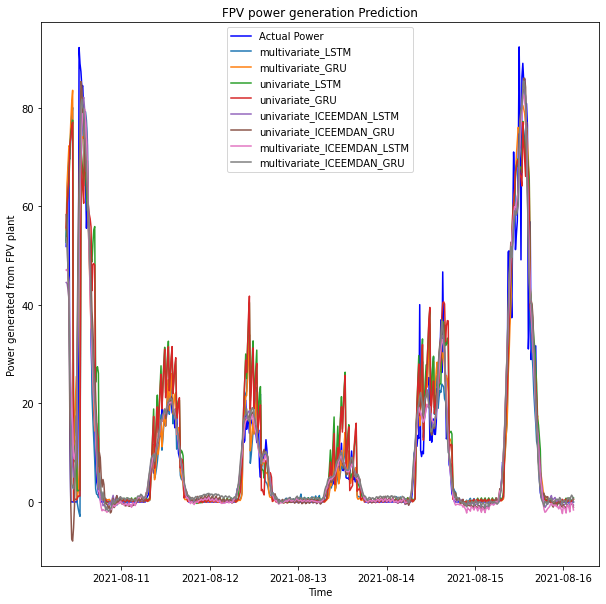

"\n| Location | |S |tring Locati | |---------------|\n -------------| | \n'best' | | | 0| | 'upper r|i|g|ht' 1| | \n'upper l|e|f|t' 2| | 'lower l|e|f|t' 3| |\n 'lower r|i|g|ht' 4| | 'right' | | | 5| | \n 'center |l|e|ft' 6| | 'center |r|i|ght' 7| |\n  'lower c|e|n|ter' 8| | 'upper c|e|n|ter' 9| \n  | 'center'| | | 10|\n"

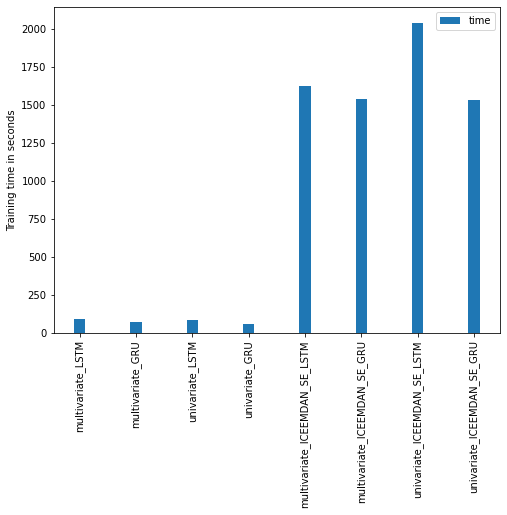

In [ ]:
#y_test_unscaled = scaler_pred.inverse_transform(test_y.reshape(-1, 1))
plt.figure(figsize=(10,10))
testing_figure=test_dates[sw_width:24*sw_width]
plt.plot(testing_figure,test_y_unscaled[0:len(testing_figure)], color='blue', label='Actual Power')

plt.plot(testing_figure,y_pred_unscaled['multivariate_LSTM'][0:len(testing_figure)],label='multivariate_LSTM')
plt.plot(testing_figure,y_pred_unscaled['multivariate_GRU'][0:len(testing_figure)],label='multivariate_GRU')
plt.plot(testing_figure,y_pred_unscaled['univariate_LSTM'][0:len(testing_figure)],label='univariate_LSTM')
plt.plot(testing_figure,y_pred_unscaled['univariate_GRU'][0:len(testing_figure)],label='univariate_GRU')



plt.plot(testing_figure,y_pred_unscaled['univariate_ICEEMDAN_SE_LSTM'][0:len(testing_figure)],label='univariate_ICEEMDAN_LSTM')
plt.plot(testing_figure,y_pred_unscaled['univariate_ICEEMDAN_SE_GRU'][0:len(testing_figure)],label='univariate_ICEEMDAN_GRU')

plt.plot(testing_figure,y_pred_unscaled['multivariate_ICEEMDAN_SE_LSTM'][0:len(testing_figure)],label='multivariate_ICEEMDAN_LSTM')
plt.plot(testing_figure,y_pred_unscaled['multivariate_ICEEMDAN_SE_GRU'][0:len(testing_figure)],label='multivariate_ICEEMDAN_GRU')






plt.title('FPV power generation Prediction')
plt.xlabel('Time')
plt.ylabel('Power generated from FPV plant')
plt.legend(loc=0) #
plt.show()

width = 0.2
x = np.arange(len(training_time_took))
Training_time=[v for v in training_time_took.values()]
plt.ylabel('Training time in seconds')
plt.bar(x , Training_time, width, label='time')
plt.xticks(ticks=x, labels=training_time_took.keys(),
            rotation=90)
_ = plt.legend()


'''
| Location | |S |tring Locati | |---------------|
 -------------| | 
'best' | | | 0| | 'upper r|i|g|ht' 1| | 
'upper l|e|f|t' 2| | 'lower l|e|f|t' 3| |
 'lower r|i|g|ht' 4| | 'right' | | | 5| | 
 'center |l|e|ft' 6| | 'center |r|i|ght' 7| |
  'lower c|e|n|ter' 8| | 'upper c|e|n|ter' 9| 
  | 'center'| | | 10|
'''

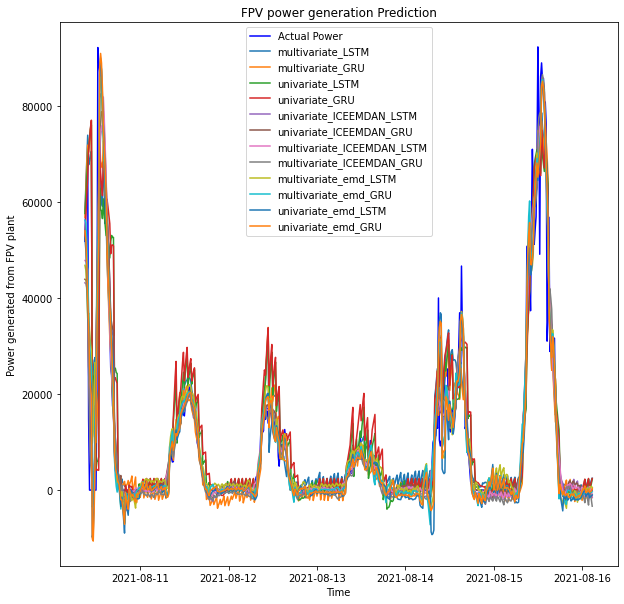

"\n| Location | |S |tring Locati | |---------------|\n -------------| | \n'best' | | | 0| | 'upper r|i|g|ht' 1| | \n'upper l|e|f|t' 2| | 'lower l|e|f|t' 3| |\n 'lower r|i|g|ht' 4| | 'right' | | | 5| | \n 'center |l|e|ft' 6| | 'center |r|i|ght' 7| |\n  'lower c|e|n|ter' 8| | 'upper c|e|n|ter' 9| \n  | 'center'| | | 10|\n"

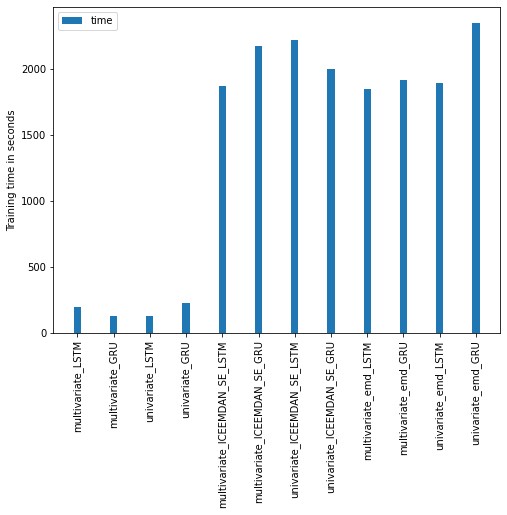

In [ ]:
#y_test_unscaled = scaler_pred.inverse_transform(test_y.reshape(-1, 1))
plt.figure(figsize=(10,10))
testing_figure=test_dates[sw_width:24*sw_width]
plt.plot(testing_figure,test_y_unscaled[0:len(testing_figure)], color='blue', label='Actual Power')

plt.plot(testing_figure,y_pred_unscaled['multivariate_LSTM'][0:len(testing_figure)],label='multivariate_LSTM')
plt.plot(testing_figure,y_pred_unscaled['multivariate_GRU'][0:len(testing_figure)],label='multivariate_GRU')
plt.plot(testing_figure,y_pred_unscaled['univariate_LSTM'][0:len(testing_figure)],label='univariate_LSTM')
plt.plot(testing_figure,y_pred_unscaled['univariate_GRU'][0:len(testing_figure)],label='univariate_GRU')



plt.plot(testing_figure,y_pred_unscaled['univariate_ICEEMDAN_SE_LSTM'][0:len(testing_figure)],label='univariate_ICEEMDAN_LSTM')
plt.plot(testing_figure,y_pred_unscaled['univariate_ICEEMDAN_SE_GRU'][0:len(testing_figure)],label='univariate_ICEEMDAN_GRU')

plt.plot(testing_figure,y_pred_unscaled['multivariate_ICEEMDAN_SE_LSTM'][0:len(testing_figure)],label='multivariate_ICEEMDAN_LSTM')
plt.plot(testing_figure,y_pred_unscaled['multivariate_ICEEMDAN_SE_GRU'][0:len(testing_figure)],label='multivariate_ICEEMDAN_GRU')

plt.plot(testing_figure,y_pred_unscaled['multivariate_emd_LSTM'][0:len(testing_figure)],label='multivariate_emd_LSTM')
plt.plot(testing_figure,y_pred_unscaled['multivariate_emd_GRU'][0:len(testing_figure)],label='multivariate_emd_GRU')

plt.plot(testing_figure,y_pred_unscaled['univariate_emd_LSTM'][0:len(testing_figure)],label='univariate_emd_LSTM')
plt.plot(testing_figure,y_pred_unscaled['univariate_emd_GRU'][0:len(testing_figure)],label='univariate_emd_GRU')





plt.title('FPV power generation Prediction')
plt.xlabel('Time')
plt.ylabel('Power generated from FPV plant')
plt.legend(loc=0) #
plt.show()

width = 0.2
x = np.arange(len(training_time_took))
Training_time=[v for v in training_time_took.values()]
plt.ylabel('Training time in seconds')
plt.bar(x , Training_time, width, label='time')
plt.xticks(ticks=x, labels=training_time_took.keys(),
            rotation=90)
_ = plt.legend()


'''
| Location | |S |tring Locati | |---------------|
 -------------| | 
'best' | | | 0| | 'upper r|i|g|ht' 1| | 
'upper l|e|f|t' 2| | 'lower l|e|f|t' 3| |
 'lower r|i|g|ht' 4| | 'right' | | | 5| | 
 'center |l|e|ft' 6| | 'center |r|i|ght' 7| |
  'lower c|e|n|ter' 8| | 'upper c|e|n|ter' 9| 
  | 'center'| | | 10|
'''

# ENDDDDDD HERE

# running some tests